In [1]:
#token 8cfc50c310f711544a8d2797e106018d1e300b2be4049285
import mdtraj as md
import numpy as np

import pyemma
import itertools
from os.path import isfile

#interface residues from 2k6d
ubq_residues = [i-1 for i in [8,40,41,42,43,44,47,48,49, 68,69,70,71,72,73,74,75,76]]
#indices adjusted for differences 2k6d construct and simulated construct
sh3_residues = [i+83-267 for i in [l for l in range(274,291)]+[l for l in range(316,324)]]

ubq_all = [i for i in range(0,76)]
sh3_all = [i for i in range(76,150)]

cpairs_ = np.array([pair for pair in itertools.product(ubq_residues, sh3_residues)])
cpairs_all = np.array([pair for pair in itertools.product(ubq_all, sh3_all)])

print("number of contact pairs %i"%len(cpairs_))
print("number of all pairs %i"%len(cpairs_all))

sh3_nat = [l for l in range(62)]
ubq_nat = [l for l in range(62,138)]
nat_all_pairs = np.array([pair for pair in itertools.product(sh3_nat, ubq_nat)])

nativepdb=md.load('/Users/solsson/2k6d.pdb')
skippable = []# [94, 134, 191, 253, 276, 280, 281, 297, 301, 305, 307, 318, 325, 328, 339, 353, 414, 453, 456, 473, 477, 549, 567, 596, 605, 606, 642, 665, 666, 751, 757, 778, 783, 785, 802, 816] #+ np.load('skippable_trajectories.npz')['arr_0'].tolist()

number of contact pairs 450
number of all pairs 5624


/Users/solsson/miniconda3/envs/pyemma/lib/python3.7/site-packages/mdtraj/formats/pdb/pdbfile.py:198: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  'cell vectors.', category=UserWarning)


In [2]:
nfsource = pyemma.coordinates.source([f"joined_strided_trajectories/trajectory_{i}.xtc" for i in range(1015) if i not in skippable], top="align_topol.pdb")

In [3]:

def remap_phi_psi(phi, psi):
    """
    Compute peptide-flip angle in ubiquitin according to Smith et al 2017
    """
    rphi = phi*180/np.pi+180
    rpsi = psi*180/np.pi+180
    orange = np.where((rphi+rpsi)>350)
    rpsi[orange] = rpsi[orange]-360
    return rpsi-rphi
    

In [4]:
dists,pairs=md.compute_contacts(nativepdb, contacts=nat_all_pairs)
sh3r = [i-267+83 for i in [275, 276, 277, 278, 279, 280,282,283,284,286, 301,302,303,304,305,306,317,319,320,321,322]]
ubqr = [i-1 for i in [7,8,11,13,41,42,45,47,49,66,67,68,69,70,71,72,73]] #[i-1 for i in [3,7,8,11,13,41,42,45,47,49,66,67,68,69,70,71,72,73]]
from itertools import product

In [5]:
res_pairs = np.array([[i,j]  for i, j in product(sh3r, ubqr) ])

In [6]:
res_pairs.shape

(357, 2)

In [7]:
feat = pyemma.coordinates.featurizer('align_topol.pdb')

ca = feat.select_Ca()
def to_ca(x):
    return [ca[_] for _ in x]

def to_ha(x):
    return np.concatenate([feat.select(f'resi {_+1} and mass > 2') for _ in x ]).tolist()

In [8]:
ubq_g0 = to_ha([2])
ubq_g1 = to_ha([6,7])
ubq_g2 = to_ha([10, 12])
ubq_g3 = to_ha([40, 41])
ubq_g4 = to_ha([44, 46, 48])
ubq_g5 = to_ha([65, 66, 67])
ubq_g6 = to_ha([68, 69, 70])
ubq_g7 = to_ha([71, 72])

In [9]:
sh3_g0 = to_ha([91, 92, 93])
sh3_g1 = to_ha([96, 98, 99])
sh3_g2 = to_ha([101, 102])
sh3_g3 = to_ha([117, 118])
sh3_g4 = to_ha([120, 121, 122])
sh3_g5 = to_ha([133, 135, 136]) 
sh3_g6 = to_ha([137, 138])

In [10]:
ca_idx = feat.select_Ca()[2:70]
pairs = []
for i,x in enumerate(ca_idx):
    for j,y in enumerate(ca_idx):
        if j>i:
            if np.abs(i-j)>5:
                pairs.append([x,y])

In [11]:
feat = pyemma.coordinates.featurizer('align_topol.pdb')

#feat.add_distances_ca(periodic=False, excluded_neighbors=4)

#feat.add_backbone_torsions(selstr='resi 23 to 39', cossin=True)
#feat.add_backbone_torsions(selstr='resi 50 to 55', cossin=True)
feat.add_group_mindist([ubq_g0, ubq_g1, ubq_g2, ubq_g3, ubq_g4, ubq_g5, ubq_g6, ubq_g7, 
                       sh3_g0, sh3_g1, sh3_g2, sh3_g3, sh3_g4, sh3_g5, sh3_g6],periodic=False)
#feat.add_residue_mindist(residue_pairs=nat_all_pairs[::2,:], threshold=0.8,periodic=False)

#feat.add_inverse_distances(np.array([[feat.select(f'name CA and resi {i}'), feat.select(f'name CA and resi {j}')] for i, j in itertools.product([52,51],[23,70,71]) ])[:,:,0])
#feat.add_chi1_torsions(' or '.join([f'resi {i}' for i in [23]]), cossin=True)
#feat.add_backbone_torsions(' or '.join([f'resi {i}' for i in [12,13,20,22,24,32,42,44,48,54,57,69]]), cossin=True)
feat.add_backbone_torsions(' or '.join([f'resi {i}' for i in range(69,76)]),cossin=True)
#feat.add_residue_mindist(residue_pairs=np.array(list(product(sh3r, ubqr))), threshold=0.8)
feat.add_minrmsd_to_ref("reference.pdb", atom_indices=to_ca(ubqr+sh3r), precentered=True)
#feat.add_chi1_torsions([f'resi {i}' for i in range(40,44)],cossin=True)


In [12]:
[feat.topology.atom(gxx[0]).residue for gxx in feat.active_features[0].group_definitions]

[PHE4,
 LEU8,
 THR12,
 ARG42,
 ALA46,
 LEU67,
 VAL70,
 LEU73,
 PHE17,
 GLN22,
 LEU27,
 ILE43,
 GLY46,
 PHE59,
 PHE63]

In [13]:
feat.topology.atom(feat.active_features[0].group_definitions[0][0]).residue.index

3

In [14]:
#UBQ RES
ARG42sc = feat.select("resi 41 and sidechain and mass > 2")
LEU71bb = feat.select("resi 70 and backbone")
LEU70sc = feat.select("resi 69 and sidechain")
ILE44sc = feat.select("resi 43 and sidechain")
ILE68sc = feat.select("resi 68 and sidechain")


GLU20bb = feat.select("resi 95 and backbone")
GLU26sc = feat.select("resi 101 and sidechain")
TRP47sc = feat.select("resi 122 and sidechain")
PRO60sc = feat.select("resi 135 and sidechain")
PHE63sc = feat.select("resi 138 and sidechain")



In [15]:
[feat.describe()[x] for x in torsion_index_in_data]

NameError: name 'torsion_index_in_data' is not defined

feat2 = pyemma.coordinates.featurizer('align_topol.pdb')
feat2.add_group_mindist([ARG42sc, LEU71bb, LEU70sc, ILE44sc, ILE68sc, 
                        GLU20bb,GLU26sc,TRP47sc,PRO60sc,PHE63sc],periodic=False)

source_simple = pyemma.coordinates.source([f"joined_strided_trajectories/trajectory_{i}.xtc" for i in range(1015) if i not in skippable] , features=feat2)

interface_features = source_simple.get_output()

In [16]:
source = pyemma.coordinates.source([f"joined_strided_trajectories/trajectory_{i}.xtc" for i in range(1015) if i not in skippable] , features=feat)

In [17]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

In [18]:
#data = [x[::5] for _,x in source.iterator(stride=1, chunk=0)]
data = source.get_output(stride = 1)

In [19]:
rmsds = [d[:,-1] for d in data ]
pincer = [np.load(f'_model/pincer_mode_{i}.npz.npy') for i in range(1015) if i not in skippable]
pflip = [np.load(f'_model/pepflip_{i}.npz.npy') for i in range(1015) if i not in skippable]
#chain_contact = [np.load(f'_model/inter_chain_dist_{i}.npz.npy') for i in range(1015) if i not in skippable]
chain_contact = [np.load(f'joined_strided_trajectories/trajectory_{i}_cf.npz')['arr_0'].ravel() for i in range(1015) if i not in skippable]


In [20]:
#junk_trajectories = [i for i,(t,r) in enumerate(zip(interface_features,rmsds)) if np.any(np.where((np.log10(t[:,5])<-0.5)*(np.log10(t[:,4])<-0.5)*r>0.5))]
junk_trajectories = [] 

In [ ]:
tica_objs = []
lags = [10,20,50,100,200,300,400,500,800,1000]#,400,500]
for l in lags:
    tica_objs.append(pyemma.coordinates.tica([d[:,:] for i, d in enumerate(data) if i not in junk_trajectories], lag=l, stride=2))

In [ ]:
plt.plot(lags,[t.ndim for t in tica_objs],'-o')

In [ ]:
to_bound = [_i for _i,_r in enumerate(rmsds) if np.any(_r<0.3)]
    
    

In [ ]:
gfhgf=plt.hist(np.concatenate([rmsds[_i] for _i in to_bound]), 1024, log=True)
    

In [ ]:
torsion_index_in_data=[i for i,f in enumerate(feat.describe()) if (f[:3]=="COS" or f[:3]=="SIN")][:]

In [ ]:
y0=tica_objs[-3].get_output()

In [ ]:
fe_=feat.describe()


In [ ]:
fe_[torsion_index_in_data[0]]

In [ ]:
ystacked = np.concatenate([t for i,t in enumerate(y0) ])

In [ ]:
tica_selected=tica_objs[-3]

In [ ]:
tica_objs2 = []
lags = [10,20,50,100,200,300,400,500]
for l in lags:
    tica_objs2.append(pyemma.coordinates.tica([d[:,torsion_index_in_data][cc>1.0] for d,cc in zip(data,chain_contact)], lag=l, stride=2))

In [ ]:
unbound_tica = tica_objs2[2]

In [ ]:
unbound_tica.cov_tau.shape

In [ ]:
unbound_tica.save('unbound_tica.pyemma', overwrite=True)

In [ ]:
unbound_only=unbound_tica.transform([d[:,torsion_index_in_data] for d,cc in zip(data,chain_contact)])

In [ ]:
unbound_trajs = np.load("unbound_ctermtic.npy").tolist()

In [71]:
unbound_project=np.vstack(unbound_only)

In [72]:
km2 = pyemma.coordinates.cluster_kmeans([u[:,:2] for u in unbound_only], k=12)

03-05-21 15:42:30 pyemma.coordinates.clustering.kmeans.KmeansClustering[57] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


In [73]:
plt.hist2d(unbound_project[cccat>1,0], unbound_project[cccat>1,1], bins=128, norm=mpl.colors.LogNorm())
plt.scatter(*km2.cluster_centers_[:].T,color='r')


NameError: name 'cccat' is not defined

In [1281]:
km2.save('cluster_unbound.pyemma', overwrite=True)

16-07-19 17:50:34 pyemma._base.serialization.h5file INFO     overwriting model "default" in file /


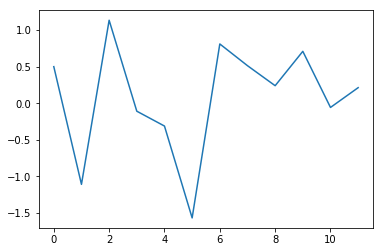

In [74]:
plt.plot(km2.cluster_centers_[:,0])

In [75]:
dtrajs_unbound = km2.dtrajs

In [78]:
km0 = pyemma.coordinates.cluster_kmeans([np.hstack([y[:,:4], r.reshape(-1,1)]) for y,r in zip(y0,rmsds)], 450)

In [79]:
dtrajs = km0.dtrajs

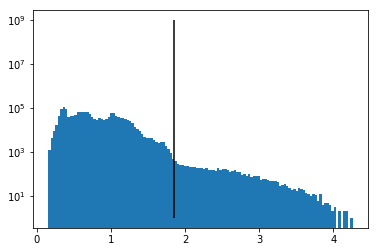

In [80]:
sdklfjs=plt.hist(np.concatenate(rmsds), bins=128,log=True)
plt.vlines(1.85,1,1e9)
#plt.xlim(1.5,4.5)
#plt.semilogx()

In [81]:
idx_, counts_ = np.unique(np.concatenate(dtrajs), return_counts=True)
ystack = np.concatenate(y0)

In [82]:
mean_lc_, std_lc_ = ystack[np.concatenate(dtrajs)==np.argmax(counts_),:4].mean(axis=0),ystack[np.concatenate(dtrajs)==np.argmax(counts_),:4].std(axis=0)

In [83]:
dtrajs_fixed = []
for dt,dtu,cc in zip(dtrajs, dtrajs_unbound,chain_contact):
    dt_ = dt.copy()
    dt_[cc>1.0] = km0.n_clusters + dtu[cc>1.0] # inject unbound state clusters
    dtrajs_fixed.append(dt_)

In [84]:
dtrajcat = np.concatenate(dtrajs_fixed)
ftrajcat = np.concatenate(rmsds)

unique_states = np.unique(dtrajcat)

pflipcat = np.concatenate(pflip)
pincercat = np.concatenate(pincer)


state_avg_pflip = [pflipcat[dtrajcat==u].mean() for u in unique_states]
state_avg_pincer = [pincercat[dtrajcat==u].mean() for u in unique_states]


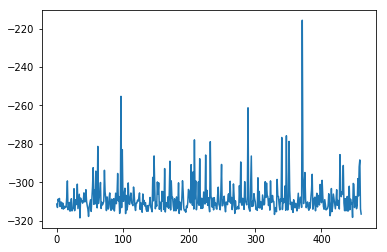

In [85]:
plt.plot(state_avg_pflip)

In [86]:
reindex_=np.unique(np.concatenate([dt[(pf<-200)] for dt,pf in zip(dtrajs_fixed,pflip)]))

dtrajs_fixed[424][np.where(pflip[424]<-200)]

dtrajs_fixedx = []
for dt,pf in zip(dtrajs_fixed, pflip):
    dt_ = dt.copy()
    minor_pflip = np.where(pf<-200)[0]
    if len(minor_pflip)>0:
        dt_[minor_pflip] = unique_states[-1] + 1 + dt_[minor_pflip] # inject unbound state clusters

    dtrajs_fixedx.append(dt_)

In [87]:
unique_states.max()

461

In [88]:
window = 70
dtrajs_fixed2 = []
for dt in dtrajs_fixedx:
    dt_ = dt.copy()
    ldt = len(dt_)
    for i in range(ldt):
        if i<window//2:
            state, scount = np.unique(dt[0:window], return_counts=True)
        elif i>(ldt-window//2):
            state, scount = np.unique(dt[-window:], return_counts=True)
        else:
            state, scount = np.unique(dt[i-window//2:i+window//2], return_counts=True)
            
        dt_[i] = state[np.argmax(scount)]
    dtrajs_fixed2.append(dt_.copy())
        

In [89]:
dtrajcat = np.concatenate(dtrajs_fixed2)
ftrajcat = np.concatenate(rmsds)

unique_states = np.unique(dtrajcat)

pflipcat = np.concatenate(pflip)
pincercat = np.concatenate(pincer)
rmsdcat = np.concatenate(rmsds)
cccat = np.concatenate(chain_contact)

state_avg_pflip = np.array([pflipcat[dtrajcat==u].mean() for u in unique_states])
state_avg_pincer = np.array([pincercat[dtrajcat==u].mean() for u in unique_states])
state_avg_rmsds = np.array([rmsdcat[dtrajcat==u].mean() for u in unique_states])
state_avg_cc = np.array([cccat[dtrajcat==u].mean() for u in unique_states])
dtc = np.concatenate(dtrajs_fixed2)
ftc = np.concatenate(unbound_only[:])[:,0]
state_avg_CTICM = np.array([ftc[dtc==i].mean() for i in np.unique(np.concatenate(dtrajs_fixed2))])
ftc = np.concatenate(unbound_only[:])[:,1]
state_avg_CTICM1 = np.array([ftc[dtc==i].mean() for i in np.unique(np.concatenate(dtrajs_fixed2))])

In [90]:
its_fixed = pyemma.msm.its( dtrajs_fixed2, lags=100,nsamples=100, errors='bayes')

03-05-21 16:25:22 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[61] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


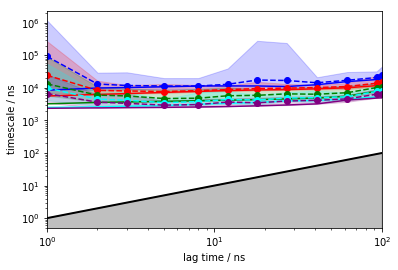

In [93]:
pyemma.plots.plot_implied_timescales(its_fixed,ylog=True, xlog=True, nits=5, units="ns")
plt.savefig('time_scales_bayes.pdf')

In [94]:
model = its_fixed.models[-4]

(500.0, 100000.0)

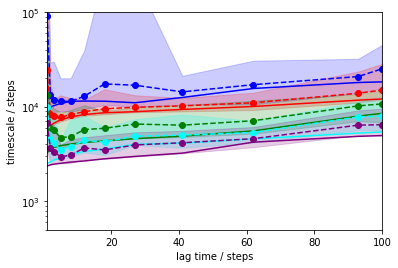

In [95]:
pyemma.plots.plot_implied_timescales(its_fixed,ylog=True, xlog=False, nits=5)
plt.ylim(5e3,1e5)


In [96]:
plt.plot(state_avg_pflip[reindex_obs_set])

NameError: name 'reindex_obs_set' is not defined

In [97]:
pyemma.plots.scatter_contour(state_avg_pflip[reindex_obs_set], state_avg_pincer[reindex_obs_set],  -np.log(model.stationary_distribution))

NameError: name 'reindex_obs_set' is not defined

In [98]:
pyemma.plots.contour(np.log(state_avg_cc[reindex_obs_set]), np.log(state_avg_rmsds[reindex_obs_set]),  model.eigenvectors_right()[:,3])

NameError: name 'reindex_obs_set' is not defined

In [99]:
state_avg_CTICM.shape,state_avg_rmsds.shape

((668,), (668,))

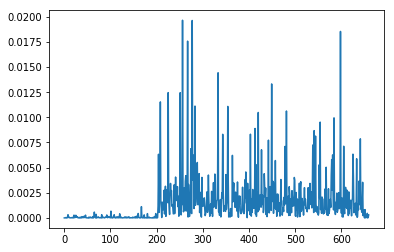

In [100]:
plt.plot(model.stationary_distribution)

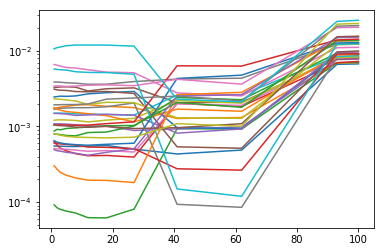

In [101]:
plt.semilogy(its_fixed.lags, [_m.stationary_distribution[np.argsort(its_fixed.models[-1].stationary_distribution)[-30:]] for _m in its_fixed.models])

In [102]:
[i for i,r in enumerate(rmsds) if np.all(r<.38)]

[144, 216, 252, 327, 407, 680]

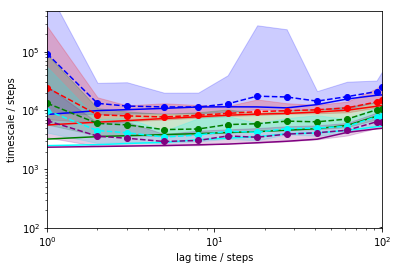

In [103]:
pyemma.plots.plot_implied_timescales(its_fixed,ylog=True,xlog=True, nits=5)
plt.ylim(1e3,5e5)

plt.savefig('time_scales_bayes.pdf')

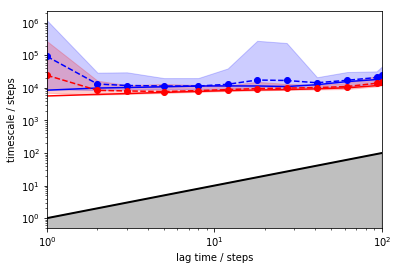

In [104]:
pyemma.plots.plot_implied_timescales(its_fixed,ylog=True,xlog=True, nits=2)


In [105]:
[np.where(np.isin(_m.active_set, list(range(351,361))))[0] for _m in its_fixed.models]

[array([161, 162, 163, 164]),
 array([161, 162, 163, 164]),
 array([161, 162, 163, 164]),
 array([161, 162, 163, 164]),
 array([161, 162, 163, 164]),
 array([161, 162, 163, 164]),
 array([161, 162, 163, 164]),
 array([161, 162, 163, 164]),
 array([160, 161, 162, 163]),
 array([160, 161, 162, 163]),
 array([156, 157, 158, 159]),
 array([156, 157, 158, 159])]

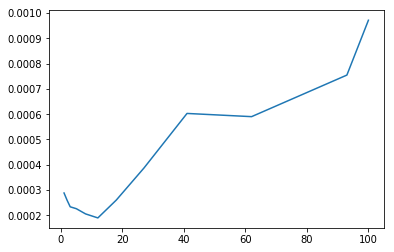

In [106]:
plt.plot(its_fixed.lags, [_m.stationary_distribution[np.where(np.isin(_m.active_set, list(range(351,361))))[0]].sum() for _m in its_fixed.models])

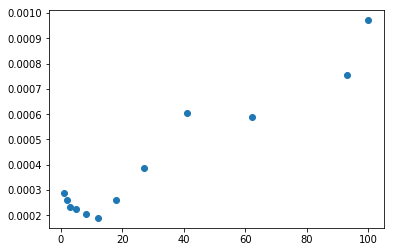

In [107]:
plt.plot(its_fixed.lags, [_m.stationary_distribution[np.where(np.isin(_m.active_set, list(range(351,361))))[0]].sum() for _m in its_fixed.models],'o')

In [108]:
ckt = model.cktest(15, mlags=8)

/Users/solsson/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 658 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/Users/solsson/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 653 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/Users/solsson/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 650 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/Users/solsson/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 643 components
  warnings.warn('truncated eigendec

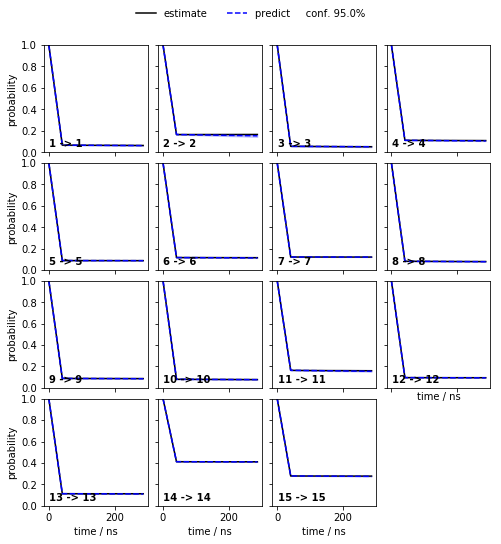

In [109]:
ax=pyemma.plots.plot_cktest(ckt,diag=True, figsize=(8,8))#;plt.tight_layout()
for i, ax_ in enumerate(ax[1][-2,:]):
    if i>2:
        ax_.set_xlabel('time / ns')
for i, ax_ in enumerate(ax[1][-1,:]):
    ax_.set_xlabel('time / ns')
    if i>2:
        ax[0].delaxes(ax_)
    
plt.savefig("ck_test_final_model.pdf")

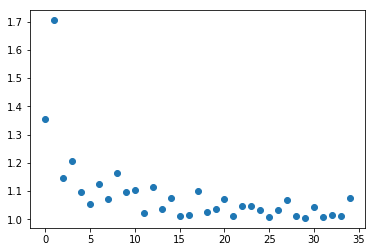

In [72]:
plt.plot(model.timescales()[:35]/model.timescales()[1:36], 'o')

In [1471]:
model

BayesianMSM(conf=0.95, connectivity='largest', count_mode='effective',
      dt_traj='1 step', lag=41, mincount_connectivity='1/n', nsamples=100,
      nsteps=25, reversible=True, show_progress=True, sparse=False,
      statdist_constraint=None)

In [1472]:
pcca = model.pcca(13)

In [1473]:
cgtm=pcca.coarse_grained_transition_matrix

In [1474]:
cgtm = np.maximum(cgtm,0)
cgtm = cgtm/cgtm.sum(axis=1, keepdims=True)

(<Figure size 864x555.149 with 1 Axes>, array([[0.2888348 , 0.        ],
        [0.40405996, 0.47847634],
        [0.54413163, 0.43188127],
        [0.47799338, 0.31967488],
        [0.69240983, 0.60507677],
        [0.62598357, 0.06416567],
        [0.60791136, 0.28507453],
        [0.51870323, 0.20159103],
        [0.71238263, 0.3891795 ],
        [0.38003084, 0.31775846],
        [0.        , 0.02290569],
        [1.        , 0.64253322],
        [0.43411014, 0.61061745]]))

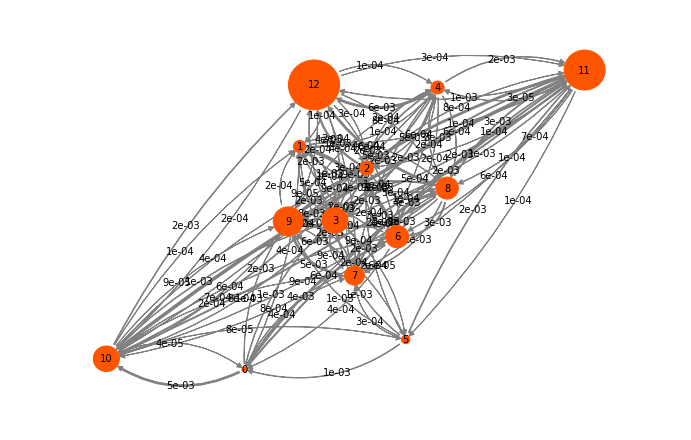

In [1475]:
pyemma.plots.plot_markov_model(cgtm)

In [1476]:
index_to_index=dict([(j,i) for i,j in enumerate(np.unique(np.concatenate(dtrajs_fixed2)))])

reindex_obs_set = np.array([index_to_index[i] for i in model.active_set])

In [1477]:
pcca.output_probabilities.shape,np.array(state_avg_rmsds).shape

((13, 641), (651,))

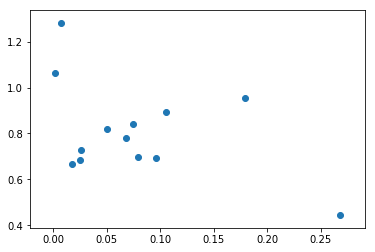

In [1478]:
plt.scatter(pcca.coarse_grained_stationary_probability,pcca.output_probabilities.dot(np.array(state_avg_rmsds)[reindex_obs_set]))

In [1479]:
pcca.output_probabilities.dot(np.array(state_avg_rmsds)[reindex_obs_set])

array([1.06467465, 0.72706004, 0.68319478, 0.69916522, 0.66507242,
       1.27904516, 0.69323586, 0.81770761, 0.77978451, 0.89207224,
       0.84264354, 0.95485489, 0.44632628])

In [1480]:
np.where(state_avg_cc>1)

(array([443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 647,
        648, 649, 650]),)

In [1481]:
pcca.output_probabilities.shape

(13, 641)

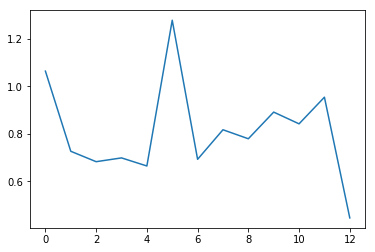

In [1482]:
plt.plot(pcca.output_probabilities.dot(np.array(state_avg_rmsds)[reindex_obs_set]))

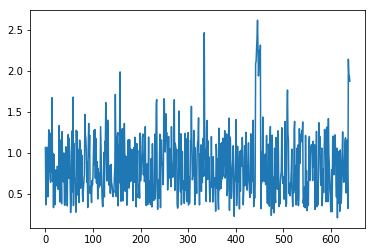

In [1483]:
plt.plot(state_avg_rmsds[reindex_obs_set])

In [1484]:
for s in reindex_obs_set[pcca.observation_probabilities[:].argmax(axis=1)]:
    print(state_avg_pincer[s])

AttributeError: 'PCCA' object has no attribute 'observation_probabilities'

In [1485]:
[state_avg_rmsd[model.active_set][pcca.metastable_assignments==i].mean() for i in range(6)]

NameError: name 'state_avg_rmsd' is not defined

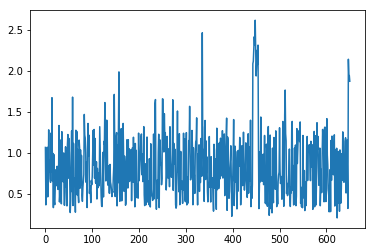

In [1486]:
plt.plot(state_avg_rmsds)

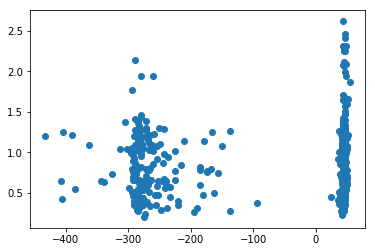

In [1487]:
plt.scatter(state_avg_pflip, state_avg_rmsds)

In [1488]:
pflip_cluster

NameError: name 'pflip_cluster' is not defined

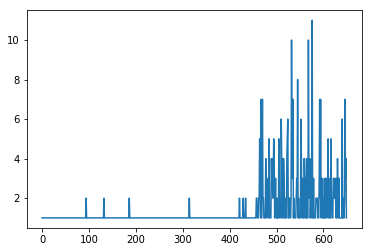

In [1489]:
plt.plot(np.diff(np.unique(np.concatenate(dtrajs_fixed2))))

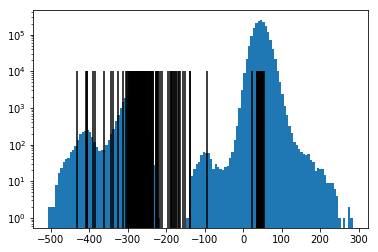

In [1490]:
plt.hist(np.concatenate(pflip), bins=128, log=True);
plt.vlines(state_avg_pflip, 0, 10000);
#plt.vlines(pflip_cluster.cluster_centers_.ravel(), 0, 10000, colors='m');
#[plt.annotate(f"{u}",(pflip_cluster.cluster_centers_.ravel()[u], 10000)) for u in range(8)]

(0.0, 2.5)

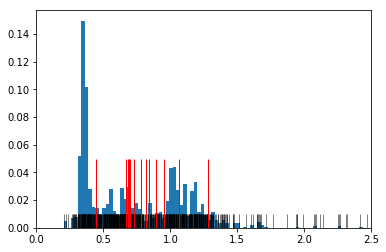

In [1491]:
plt.hist(state_avg_rmsds[reindex_obs_set],bins=92,weights=model.stationary_distribution)
plt.vlines(state_avg_rmsds, 0, 0.01, lw=0.5)
plt.vlines(pcca.output_probabilities.dot(state_avg_rmsds[reindex_obs_set]), 0, 0.05, lw=1, color='r')
plt.xlim(0.0,2.5)

In [1492]:
np.where(state_avg_rmsds[reindex_obs_set]<0.35)[0]

array([ 17,  53,  64,  89, 121, 191, 224, 236, 242, 278, 358, 364, 387,
       397, 408, 438, 453, 471, 475, 478, 481, 491, 506, 520, 544, 546,
       550, 567, 571, 600, 603, 614, 619, 636])

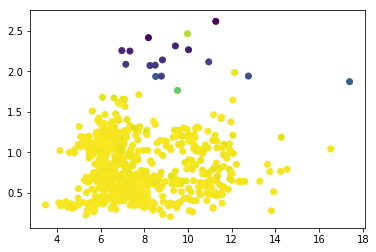

In [1493]:
plt.scatter(-np.log(model.stationary_distribution), state_avg_rmsds[reindex_obs_set], c=-np.log(state_avg_cc[reindex_obs_set]+1e-3) )

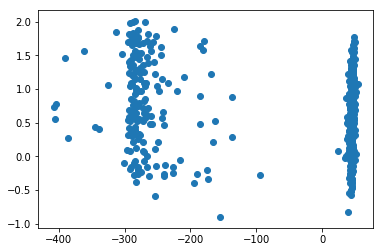

In [1494]:
plt.scatter(state_avg_pflip[reindex_obs_set], state_avg_pincer[reindex_obs_set])

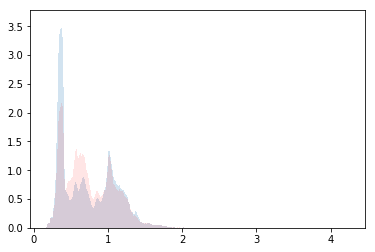

In [1495]:
gfhgf=plt.hist(np.concatenate(rmsds), 1024, log=False, weights=np.concatenate(model.trajectory_weights()), density=True, alpha=0.2)
gfhgf=plt.hist(np.concatenate(rmsds), 1024, log=False, alpha=0.1,color='r',density=True)
       

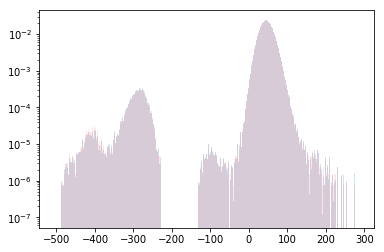

In [431]:
gfhgf=plt.hist(np.concatenate(pflip), 1024, log=True, weights=np.concatenate(model.trajectory_weights()), density=True, alpha=0.2)
gfhgf=plt.hist(np.concatenate(pflip), 1024, log=True, alpha=0.1,color='r',density=True)
       

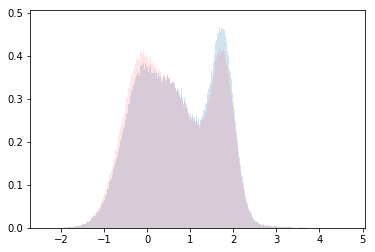

In [432]:
gfhgf=plt.hist(np.concatenate(pincer), 1024, log=False, weights=np.concatenate(model.trajectory_weights()), density=True, alpha=0.2)
gfhgf=plt.hist(np.concatenate(pincer), 1024, log=False, alpha=0.1,color='r',density=True)
       

In [1496]:
pcca.metastable_distributions[:,-10:].sum(axis=1)

AttributeError: 'PCCA' object has no attribute 'metastable_distributions'

In [1497]:
from scipy.spatial import cKDTree

class DisconnectedSelector(object):

    def __init__(self, ax, pos, ngl_widget, dtrajs, ftrajs, active_set, pair=(0,1), 
                        hist_data = None,
                        cluster_centers = None,
                        msm = None):
        from matplotlib.widgets import AxesWidget
        from ipywidgets import interact
        
        self.msm = msm
        self.selected_eigenfunction = 1
        
        self.dts = dtrajs
        self.fts = ftrajs
        self.n,self.m = pair
        self.pair = pair
        self.kdtree = cKDTree(pos[:,pair]) 
        self.index = 0 
        assert ngl_widget.trajectory_0.n_frames == pos.shape[0]
        self._data = pos
        self.x, self.y = self._data[:,pair].T
        self.idx_active_set = active_set[self.index]
        self.ax = ax
        self.dot, = self.ax.plot(pos[0,self.n],pos[0,self.m], '*', c='red', ms=7, zorder=25)

        self.label = self.ax.text(0.80, 0.95, f"state 0", transform=self.ax.transAxes)
        self.ngl_widget = ngl_widget
        
        self.ngl_widget.isClick = False
        self.selected_dtrajs = []
        self.excluded_dtrajs = []
        self.active_set = active_set
        # Connect axes to widget
        self.axes_widget = AxesWidget(self.ax)
        self.axes_widget.connect_event('button_release_event', self.onclick)

        # Connect widget to axes
        self.ngl_widget.observe(self.my_observer, "frame", "change")
        from IPython.display import display
        self.button = widgets.Button(description="Exclude trajs")
        self.button.on_click(self.on_button_clicked) 
        self.lines = [self.ax.plot([0],[0], zorder=15+i) for i in range(20)]

        self.ax.scatter(cluster_centers[self.active_set[:],self.pair[0]] ,
                        cluster_centers[self.active_set[:],self.pair[1]], zorder=11,
                       c=self.msm.eigenvectors_right()[:, self.selected_eigenfunction])

        self.ax.hist2d(hist_data[:,self.pair[0]], hist_data[:,self.pair[1]], bins=128,
                       norm=mpl.colors.LogNorm());

        self.cluster_centers = cluster_centers
        self.hist_data = hist_data
        display(self.button)

        interact(self.redraw, 
                 m=widgets.IntSlider(min=0,max=self._data.shape[1]-1,step=1,value=self.pair[0]),
                 n=widgets.IntSlider(min=0,max=self._data.shape[1]-1,step=1,value=self.pair[1]),
                 se=widgets.IntSlider(min=1,max=M2.nstates-1,step=1,value=self.selected_eigenfunction)
                )
        
    def redraw(self, m, n, se):
        self.selected_eigenfunction = se
        self.ax.clear()
        self.lines = [self.ax.plot([0],[0], zorder=15+i) for i in range(20)]

        self.pair = (m, n)
        self.m = m
        self.n = n
        self.x, self.y = self._data[:,self.pair].T
        self.kdtree = cKDTree(self._data[:,self.pair]) 
        
        for h,k in enumerate(self.selected_dtrajs):
            self.ax.lines[h].set_data(self.fts[k][:,self.pair[0]], self.fts[k][:,self.pair[1]])

        self.ax.scatter(self.cluster_centers[self.active_set[:],self.pair[0]] ,
                        self.cluster_centers[self.active_set[:],self.pair[1]], zorder=11, 
                        c=self.msm.eigenvectors_right()[:, self.selected_eigenfunction])

        self.ax.hist2d(self.hist_data[:,self.pair[0]], self.hist_data[:,self.pair[1]], bins=128,
                       norm=mpl.colors.LogNorm());

        self.dot.set_xdata((self.x[self.index]))
        self.dot.set_ydata((self.y[self.index]))
        self.dot.set_zorder(100)
        self.label.set_text(f"state {self.idx_active_set}")
        self.ngl_widget.isClick = True
        self.ngl_widget.frame = self.index
        self.ngl_widget

    def onclick(self, event):
        #self.button.description=f"{event}"
        data = [event.xdata, event.ydata]
        _, self.index = self.kdtree.query(x=data, k=1)
        self.idx_active_set = self.active_set[self.index]
        for line in self.ax.lines:
            line.set_data([0],[0])
            
        self.selected_dtrajs = [_i for _i,_dt in enumerate(self.dts) 
                           if np.any(_dt==self.idx_active_set) 
                           and _i not in self.excluded_dtrajs]

        for h,k in enumerate(self.selected_dtrajs):
            self.ax.lines[h].set_data(self.fts[k][:,self.pair[0]], self.fts[k][:,self.pair[1]])

        self.dot.set_xdata((self.x[self.index]))
        self.dot.set_ydata((self.y[self.index]))
        self.dot.set_zorder(100)
        self.label.set_text(f"state {self.idx_active_set}")
        self.ngl_widget.isClick = True
        self.ngl_widget.frame = self.index
        self.ngl_widget
        
    def on_button_clicked(self, b):
        self.excluded_dtrajs += self.selected_dtrajs
        
    def my_observer(self, change):
        r"""Here comes the code that you want to execute
        """
        self.ngl_widget.isClick = False
        _idx = change["new"]
        try:
            idx_active_set = self.active_set[_idx]
            self.dot.set_xdata((self.x[_idx]))
            self.dot.set_ydata((self.y[_idx]))   
            self.label.set_text(f"state {self.idx_active_set}")

        except IndexError as e:
            self.dot.set_xdata((self.x[0]))
            self.dot.set_ydata((self.y[0]))
            print("caught index error with index %s (new=%s, old=%s)" % (_idx, change["new"], change["old"]))



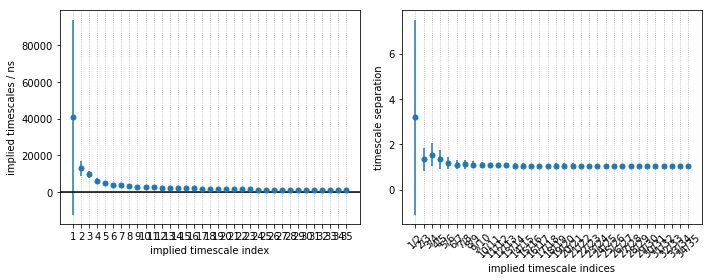

In [1498]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 35

timescales_mean = model.sample_mean('timescales', k=nits)
timescales_std = model.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean, 
    yerr=timescales_std, 
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:], 
    yerr=its_separation_err(
        timescales_mean, 
        timescales_std), 
    fmt='.', 
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')
    
axes[0].axhline(model.lag, lw=1.5, color='k')
axes[0].axhspan(0, model.lag, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()

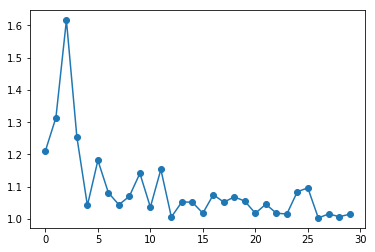

In [1499]:
plt.plot(model.timescales()[:30]/model.timescales()[1:31], '-o')

In [1500]:
dtc = np.concatenate(dtrajs_fixed2)
ftc = np.concatenate(unbound_only[:])[:,0]
state_avg_CTICM = np.array([ftc[dtc==i].mean() for i in np.unique(np.concatenate(dtrajs_fixed2))])
ftc = np.concatenate(unbound_only[:])[:,1]
state_avg_CTICM1 = np.array([ftc[dtc==i].mean() for i in np.unique(np.concatenate(dtrajs_fixed2))])

In [1501]:
cterm_order_cat = np.concatenate(unbound_only[:])[:,0]
cterm_order_cat1 = np.concatenate(unbound_only[:])[:,1]


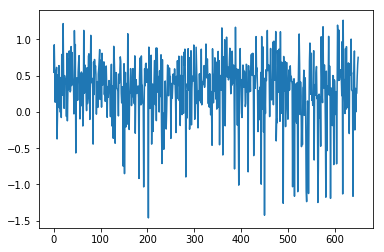

In [1502]:
plt.plot(state_avg_CTICM)

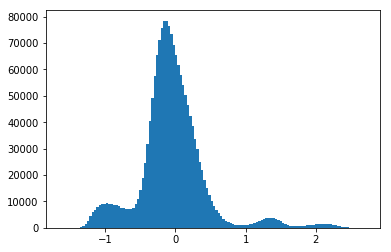

In [1503]:
plt.hist(ftc, bins=128);

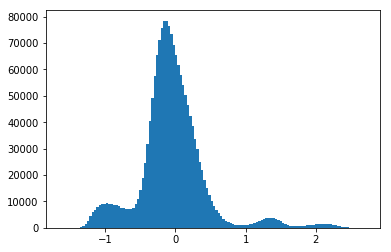

In [1504]:
plt.hist(cterm_order_cat1, bins=128);

In [2872]:
dtc = np.concatenate(dtrajs_fixed2)
ftc = np.concatenate(y0[:])
state_avg_tics = np.array([ftc[dtc==i,:].mean(axis=0) for i in np.unique(np.concatenate(dtrajs_fixed2))])

In [2873]:
dtc = np.concatenate(dtrajs_fixed2)
ftc = np.concatenate(chain_contact[:])
state_avg_icd = np.array([ftc[dtc==i].mean() for i in np.unique(np.concatenate(dtrajs_fixed2))])

In [2871]:
state_avg_tics[:,1]

array([ 0.82064867, -1.2842507 ,  0.52838796, -0.17949836,  1.0311358 ,
       -0.19408186,  0.5489979 ,  1.4425963 ,  0.2655297 ,  0.962058  ,
        0.2563242 , -0.49990442,  0.8756823 ,  0.26310524,  1.003935  ,
        0.1953211 ,  0.5608233 , -1.4294382 ,  1.029769  , -0.87095594,
       -1.0166909 ,  0.5588854 ,  0.56991106, -0.22398266,  0.18357363,
        0.26338395,  0.50022185, -0.76684844,  0.12861393,  1.1801652 ,
       -0.9643467 , -0.28494093,  1.0111624 ,  0.5087269 , -1.2880151 ,
        1.1278696 ,  0.8914937 ,  0.30571073, -0.24577305,  0.08595386,
       -1.0564955 , -1.6210825 ,  0.16654965,  0.8559802 , -0.08935561,
        0.90677595, -1.3249671 ,  0.810612  ,  1.5741237 , -0.16661403,
        0.8527865 ,  0.80796784,  0.84101933, -1.4805113 , -0.2779569 ,
        0.9629228 ,  0.91717964, -0.48893487,  1.3629067 , -0.91713166,
        0.7457546 , -0.04728909, -0.4855787 , -0.10473774, -1.1968793 ,
        1.1578906 ,  0.6621613 ,  1.4722048 , -0.02421171,  0.94

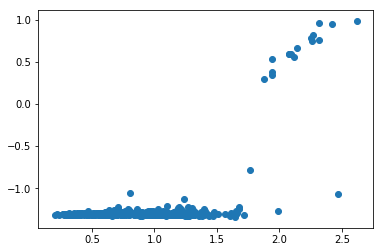

In [1509]:
plt.scatter(state_avg_rmsds, np.log(state_avg_cc))

In [99]:
import dbmr 
import msmtools as mt

In [100]:
C_ = mt.estimation.count_matrix(dtrajs_fixed2, lag=1, sliding=False, sparse_return=False)

Did not converge to a delta log-likelohood below 1e-16 (1.186009e+02) within 1000 iterations. Stopping.


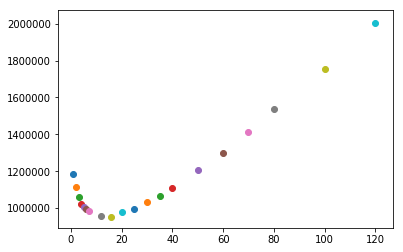

In [101]:
logndp = np.log(np.sum([len(dt)-80 for dt in dtrajs_fixed]))

for k in [1,2,3,4,5,6,7,12,16,20,25,30,35,40,50,60,70,80,100,120]:
    lamb,gam,lls = dbmr.estimate_dbmr(model.count_matrix_full, K=k )
    nparam = np.prod(np.shape(lamb))+np.prod(np.shape(gam))
    plt.scatter([k], [logndp*nparam-2*lls[-1]] )

In [102]:
lamb,gam,lls = dbmr.estimate_dbmr(model.count_matrix_full, K=30 )

In [2381]:
def coarsegrain_tmat(msmobj, memberships):
    if hasattr(msmobj, 'P') and hasattr(msmobj, 'stationary_distribution'):
        A = np.dot(np.dot(memberships.T, msmobj.P), memberships)
        pi_coarse = np.dot(memberships.T, msmobj.stationary_distribution)
        B = np.dot(np.dot(np.diag(1.0 / pi_coarse), memberships.T), np.diag(msmobj.stationary_distribution))
        B /= B.sum(axis=1, keepdims=True)

    else:
        import msmtools as mt
        A = np.dot(np.dot(memberships.T, msmobj), memberships)
        pi_coarse = np.dot(memberships.T, mt.analysis.statdist(msmobj))
        B = np.dot(np.dot(np.diag(1.0 / pi_coarse), memberships.T), np.diag(mt.analysis.statdist(msmobj)))
        B /= B.sum(axis=1, keepdims=True)


    # coarse-grained transition matrix
    W = np.linalg.inv(np.dot(memberships.T, memberships))
    if hasattr(msmobj, 'P'):
        A = np.dot(np.dot(memberships.T, msmobj.P), memberships)
    else:
        A = np.dot(np.dot(memberships.T, msmobj), memberships)
    _P_coarse = np.dot(W, A)

    # symmetrize and renormalize to eliminate numerical errors
    X = np.dot(np.diag(pi_coarse), _P_coarse)
    _P_coarse = X / X.sum(axis=1, keepdims=True)
    return _P_coarse, pi_coarse, B

In [2382]:
unbound_idx = unique_states[state_avg_cc>1]
bound_idx = unique_states[state_avg_cc<1]


reindexed_unbound = np.where(np.isin(model.active_set, unbound_idx))[0]
new_membership = model.metastable_memberships
new_membership = np.hstack((new_membership, np.zeros((model.nstates,1))))
new_membership[reindexed_unbound, -1] = 1.
new_membership[reindexed_unbound, :-1] = 0.
#new_membership = np.hstack((new_membership, np.zeros((model.nstates,1))))
# new_membership[np.argsort(model.metastable_memberships[:,-1])[-70:], -1] = 1.
# new_membership[np.argsort(model.metastable_memberships[:,-1])[-70:], :-1] = 0.

In [2384]:
cgmats_=[coarsegrain_tmat(p, new_membership2)[0] for p in model.sample_f('P')]
cgmats_=[np.maximum(cgmat,0) for cgmat in cgmats_]
cgmats_=[cgmat/cgmat.sum(axis=1, keepdims=True) for cgmat in cgmats_]

In [2385]:
bound_tmats=[cgmat[[12,14],:][:,[12,14]] for cgmat in cgmats_]
bound_tmats = [bound_tmat/bound_tmat.sum(axis=1, keepdims=True) for bound_tmat in bound_tmats]

In [2432]:
import msmtools as mt
np.mean([1./mt.analysis.mfpt(bound_tmat,12,14)*model.lag for bound_tmat in cgmats_]),mt.util.statistics.confidence_interval([1./mt.analysis.mfpt(bound_tmat,12,14)*model.lag for bound_tmat in cgmats_])


(0.43530289649933324, (0.3905113615708049, 0.48065514693811207))

In [2433]:
import msmtools as mt
np.mean([1./mt.analysis.mfpt(bound_tmat,14,12)*model.lag for bound_tmat in cgmats_]),mt.util.statistics.confidence_interval([1./mt.analysis.mfpt(bound_tmat,14,12)*model.lag for bound_tmat in cgmats_])


(6.131290767148998, (4.281471147332404, 7.843312901937704))

In [2357]:
unbound_idx = unique_states[state_avg_cc>1]
bound_idx = unique_states[state_avg_cc<1]


reindexed_unbound = np.where(np.isin(model.active_set, unbound_idx))[0]
new_membership2 = model.metastable_memberships
new_membership2 = np.hstack((new_membership, np.zeros((model.nstates,1))))
new_membership2[reindexed_unbound, -1] = 1.
new_membership2[reindexed_unbound, :-1] = 0.
new_membership2 = np.hstack((new_membership, np.zeros((model.nstates,1))))
new_membership2[np.argsort(model.metastable_memberships[:,-1])[-70:], -1] = 1.
new_membership2[np.argsort(model.metastable_memberships[:,-1])[-70:], :-1] = 0.

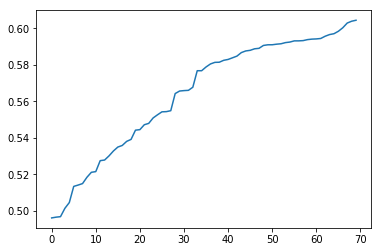

In [2302]:

plt.plot(model.metastable_memberships[np.argsort(model.metastable_memberships[:,-1])[-70:],-1])

In [2416]:
[0].shape

(213, 8)

In [3309]:
dtcontact = [((cc<1.0) * (ubo[:,0]>-0.5) ).astype(int) for cc,ubo in zip(chain_contact,unbound_only)]

In [3310]:
contact_its = pyemma.msm.timescales_msm(dtcontact, lags=50, errors='bayes')

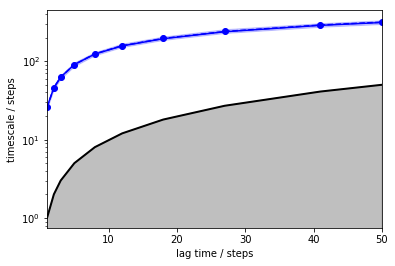

In [3311]:
pyemma.plots.plot_implied_timescales(contact_its)

In [3312]:
pure_association_msm = contact_its.models[-3]

In [3313]:

kon = 1./np.array(pure_association_msm.sample_f('mfpt', 0,1))/1994e-6

In [3314]:

koff=1./np.array(pure_association_msm.sample_f('mfpt', 1,0))#/1994e-6

In [3315]:
print (np.mean(kon), mt.util.statistics.confidence_interval(kon), "* 10^9 1/s/M")
print (1e3*np.mean(koff), 1e3*np.array(mt.util.statistics.confidence_interval(koff)), "* 10^6 1/s")

1.772406520246197 (1.6649755048666417, 1.8574887019984787) * 10^9 1/s/M
0.41913822845176424 [0.40974339 0.43130526] * 10^6 1/s


In [3316]:
1./np.array(pure_association_msm.sample_f('mfpt', 0,1))/1994e-6

array([1.7746658 , 1.82701001, 1.72703013, 1.69156937, 1.82968922,
       1.70378634, 1.79977065, 1.79213934, 1.7196922 , 1.76953877,
       1.76723266, 1.82448026, 1.69802161, 1.71074785, 1.73465702,
       1.79215262, 1.69382345, 1.8516687 , 1.79667074, 1.7855952 ,
       1.78243551, 1.79922042, 1.77744133, 1.81905542, 1.87527341,
       1.77964448, 1.8282688 , 1.77197441, 1.79353983, 1.76578124,
       1.80895082, 1.72430443, 1.78471726, 1.83743236, 1.61467276,
       1.66414844, 1.80821127, 1.83157242, 1.69887851, 1.82294138,
       1.85932105, 1.7572122 , 1.7837729 , 1.83245257, 1.67840139,
       1.83237064, 1.71498809, 1.7562313 , 1.76032207, 1.76684738])

In [3319]:
np.mean(koff/kon)*1e6,np.array(mt.util.statistics.confidence_interval(koff/kon))*1e6

(236.73179368549043, array([224.55830119, 259.62700823]))

In [3318]:
0.00023673179368549044*1e3

0.23673179368549044

In [3321]:
new_membership2[dtrajcat]

IndexError: index 796 is out of bounds for axis 0 with size 641

In [2502]:
committor_to_KD(0.5)

69.06592918359908

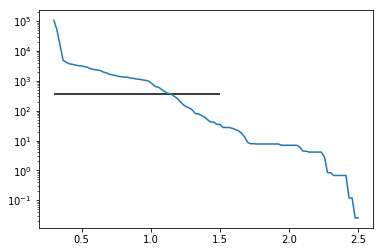

In [2572]:
def kd(pb):
    return (1-pb)/pb*2000
plt.semilogy(np.linspace(0.3,2.5,100),[kd(model.stationary_distribution[state_avg_rmsds[reindex_obs_set]<a].sum()) for a in np.linspace(0.3,2.5,100)])
plt.hlines(370, 0.3,1.5)


In [2449]:
from scipy.optimize import bisect

def committor_to_KD(p):
    concentration_micro_molar=1994.334288806385
    bound_p = model.stationary_distribution[tpt_.committor>p].sum()
    return (1-bound_p)/bound_p*concentration_micro_molar

/Users/solsson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


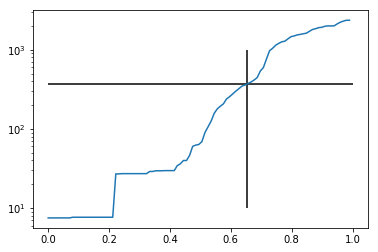

In [2452]:
plt.semilogy(np.linspace(0,1,100), [committor_to_KD(x) for x in np.linspace(0,1,100)])
committor_co = bisect(lambda x:committor_to_KD(x)-370, 0,1)
plt.hlines(370, 0,1)
plt.vlines(committor_co, 10,1e3)


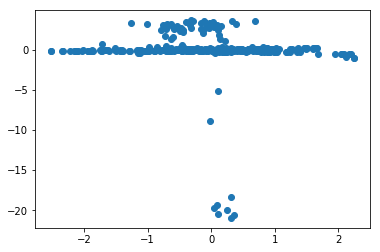

In [2541]:
plt.scatter(state_avg_tics[reindex_obs_set,4],model.eigenvectors_right()[:,5])

In [2304]:
state_avg_rmsds[np.where(np.isin(unique_states, model.active_set))[0][np.argsort(model.metastable_memberships[:,-3])[-40:]]].mean()
#state_avg_rmsds[] np.argsort(model.metastable_memberships[:,-1])[-25:]

0.7621487

In [2305]:
np.isin(np.argsort(model.metastable_memberships[:,-1])[-50:], np.where(model.metastable_assignments==21))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [2306]:
state_avg_rmsds[reindex_obs_set[116]]

1.3183256

In [2314]:
REDP=model.P[:,np.where(new_membership.argmax(axis=1)==17)[0]][np.where(new_membership.argmax(axis=1)==17)[0],:]
REDP/=REDP.sum(axis=1, keepdims=True)

In [2315]:
for ms_state in range(16):
    renormed_=model.stationary_distribution[np.where(new_membership.argmax(axis=1)==ms_state)[0]]
    renormed_/=renormed_.sum()
    print(ms_state, state_avg_rmsds[reindex_obs_set][np.where(new_membership.argmax(axis=1)==ms_state)[0]].dot(renormed_))

0 1.0262917280197144
1 0.5933900406946206
2 0.6383197455068843
3 0.728700729169671
4 0.5537369528325741
5 1.3234058200078072
6 0.5282546485970512
7 1.0147310781790395
8 0.7361088826103173
9 1.1741419018705217
10 0.666107932774026
11 1.0553720996106541
12 0.40408941380946917
13 2.178549668595414
14 0.0
15 0.0


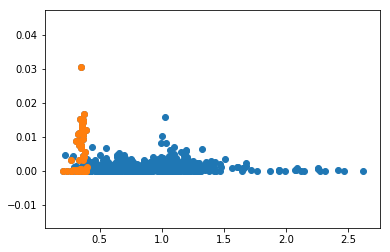

In [2316]:
plt.scatter(state_avg_rmsds[reindex_obs_set], model.stationary_distribution)
plt.scatter(state_avg_rmsds[reindex_obs_set][np.argsort(model.metastable_memberships[:,-1])[-60:]], model.stationary_distribution[np.argsort(model.metastable_memberships[:,-1])[-60:]])


In [2317]:
cgmat,cgpi,cgem=coarsegrain_tmat(model, new_membership)
cgmat=np.maximum(cgmat,0)
cgmat=cgmat/cgmat.sum(axis=1, keepdims=True)

(<Figure size 668.79x864 with 1 Axes>, array([[0.77406304, 1.        ],
        [0.20225493, 0.65454066],
        [0.39664995, 0.20363454],
        [0.32882853, 0.47305804],
        [0.16033362, 0.        ],
        [0.0730954 , 0.57707627],
        [0.41207952, 0.61609215],
        [0.32584315, 0.09564841],
        [0.22407299, 0.27177339],
        [0.52157739, 0.34167791],
        [0.46485511, 0.48259097],
        [0.41998361, 0.37439625],
        [0.14710007, 0.36394346],
        [0.        , 0.27960546]]))

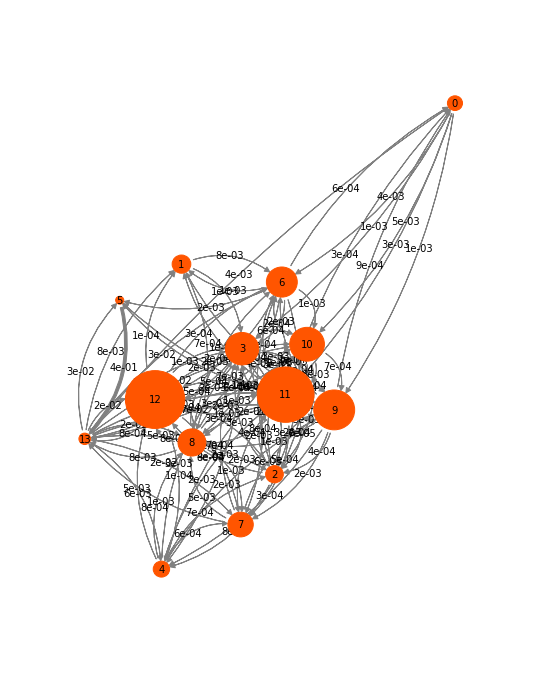

In [2318]:
pyemma.plots.plot_markov_model(cgmat,minflux=1e-5)

In [2319]:
cgpi

array([0.00193247, 0.0258152 , 0.02481699, 0.0795001 , 0.01798675,
       0.00744679, 0.09555871, 0.05065517, 0.0675203 , 0.10459881,
       0.07470797, 0.17794648, 0.26775851, 0.00375576])

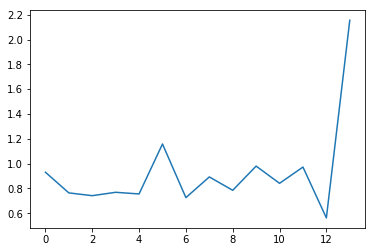

In [2320]:
plt.plot(state_avg_rmsds[reindex_obs_set].dot(new_membership)/new_membership.sum(axis=0))

In [2322]:
model.mfpt(np.where(new_membership.argmax(axis=1)==13)[0],np.where(new_membership.argmax(axis=1)==12)[0], )

10850.783286334467

In [2323]:
model.mfpt(np.where(new_membership.argmax(axis=1)==12)[0],np.where(new_membership.argmax(axis=1)==13)[0], )

63800.84921734006

In [2324]:
tpt_=pyemma.msm.tpt(model, np.where(new_membership.argmax(axis=1)==13)[0], np.where(new_membership.argmax(axis=1)==12)[0])
tpt_unbind=pyemma.msm.tpt(model, np.where(new_membership.argmax(axis=1)==12)[0], np.where(new_membership.argmax(axis=1)==13)[0])

In [2325]:
mflux=tpt_.coarse_grain([np.where(new_membership.argmax(axis=1)==i)[0] for i in range(new_membership.shape[1])])
mflux_unbind=tpt_unbind.coarse_grain([np.where(new_membership.argmax(axis=1)==i)[0] for i in range(new_membership.shape[1])])

In [2326]:
pathways_=tpt_.pathways(maxiter=2000)
pathways_unbind=tpt_unbind.pathways(maxiter=2000)

/Users/solsson/miniconda3/lib/python3.6/site-packages/msmtools/flux/sparse/pathways.py:310: RuntimeWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", RuntimeWarning)


/Users/solsson/miniconda3/lib/python3.6/site-packages/IPython/core/displayhook.py:271: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


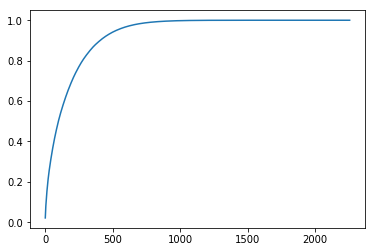

In [2327]:
plt.plot(np.cumsum(pathways_[1]/np.sum(pathways_[1])))

In [2328]:
state_avg_rmsds[reindex_obs_set][new_membership.argmax(axis=0)]

array([1.0262917 , 0.5792341 , 0.5784149 , 0.7828431 , 0.5586285 ,
       1.3822241 , 0.7404732 , 1.0344409 , 0.6214947 , 1.2698363 ,
       0.694148  , 1.0455532 , 0.36528265, 2.0885456 ], dtype=float32)

In [2329]:
cgpi

array([0.00193247, 0.0258152 , 0.02481699, 0.0795001 , 0.01798675,
       0.00744679, 0.09555871, 0.05065517, 0.0675203 , 0.10459881,
       0.07470797, 0.17794648, 0.26775851, 0.00375576])

In [1809]:
state_avg_rmsds[reindex_obs_set][397]

0.2234742

In [1810]:
pyemma.coordinates.save_traj(source, model.sample_by_state(50, subset=[397]), "lowest_rmsd.pdb")

17-07-19 13:41:14 pyemma.coordinates.api INFO     Created file lowest_rmsd.pdb


In [2330]:
pyemma.coordinates.save_trajs(source, 
                              model.sample_by_state(100, subset=new_membership.argmax(axis=0)),
                             prefix="pcca_")

['pcca_000000.xtc',
 'pcca_000001.xtc',
 'pcca_000002.xtc',
 'pcca_000003.xtc',
 'pcca_000004.xtc',
 'pcca_000005.xtc',
 'pcca_000006.xtc',
 'pcca_000007.xtc',
 'pcca_000008.xtc',
 'pcca_000009.xtc',
 'pcca_000010.xtc',
 'pcca_000011.xtc',
 'pcca_000012.xtc',
 'pcca_000013.xtc']

(<Figure size 864x864 with 1 Axes>, array([[0.        , 0.77469969],
        [0.81183226, 0.        ],
        [0.95559742, 1.        ],
        [0.89386218, 0.97408844],
        [0.83474806, 0.70699463],
        [0.94334127, 0.49843661],
        [0.22747469, 0.63086108],
        [0.9592025 , 0.19786585],
        [0.69134961, 0.40757332],
        [0.86926984, 0.88530704],
        [0.58823476, 0.84266994],
        [0.82694047, 0.15110065],
        [0.70498045, 0.342662  ],
        [1.        , 0.55921906]]))

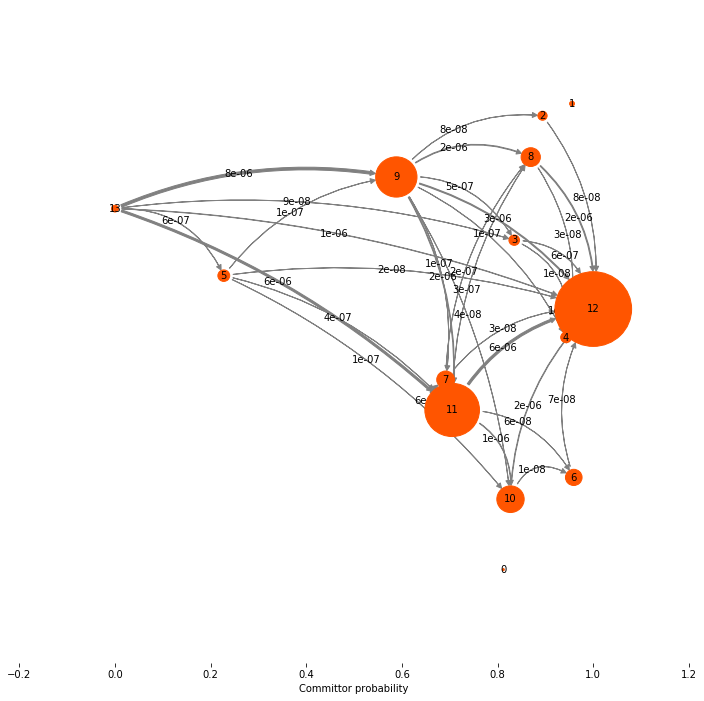

In [2575]:
pyemma.plots.plot_flux(mflux[-1],minflux=1e-8, state_labels=[str(i) for i in [13,0,1,2,3,4,5,6,7,8,9,10,11,12]])

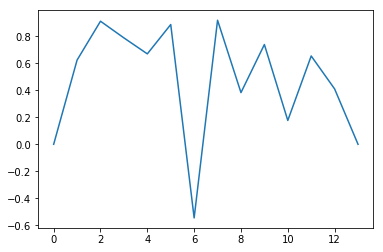

In [2332]:
plt.plot(mflux_unbind[-1].qminus-mflux[-1].qminus)

(<Figure size 864x864 with 1 Axes>, array([[0.        , 0.68032183],
        [0.18816774, 0.16994606],
        [0.04440258, 0.49477624],
        [0.10613782, 0.94917532],
        [0.16525194, 0.04876154],
        [0.05665873, 0.09605119],
        [0.77252531, 0.76757278],
        [0.0407975 , 0.26954727],
        [0.30865039, 0.        ],
        [0.13073016, 0.91005514],
        [0.41176524, 0.42853025],
        [0.17305953, 1.        ],
        [0.29501955, 0.84830577],
        [1.        , 0.59462639]]))

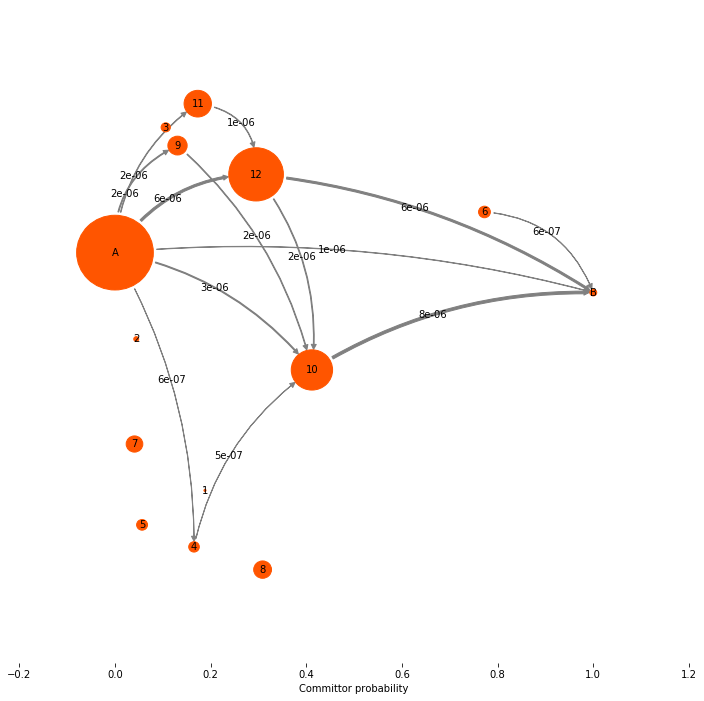

In [2333]:
pyemma.plots.plot_flux(mflux_unbind[-1],minflux=5e-7)

In [1814]:
for j in [i for i,dt in enumerate(model.discrete_trajectories_active) if np.any(np.isin(dt,np.where(new_membership[:,-2])[0]))  ][48:50]:
    first_dissociated=np.where(np.isin(model.discrete_trajectories_active[j], np.where(new_membership[:,-2])[0]))[0][0]
#if np.any(state_avg_rmsds[reindex_obs_set][model.discrete_trajectories_active[j][first_dissociated:]]<.5):
    plt.plot(pflip[j][first_dissociated:])# [reindex_obs_set][model.discrete_trajectories_active[j][first_dissociated:]], density=True)#, state_avg_rmsds[reindex_obs_set][model.discrete_trajectories_active[j][first_dissociated:]])
#        print(j)
#        plt.plot(state_avg_rmsds[reindex_obs_set][model.discrete_trajectories_active[j][:]])


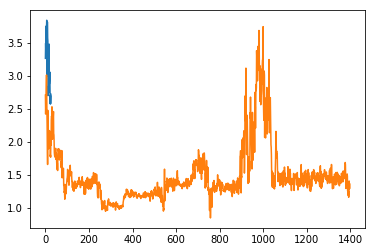

In [1815]:
for j in [i for i,dt in enumerate(model.discrete_trajectories_active) if np.any(np.isin(dt,np.where(new_membership[:,-2])[0]))  ][46:48]:
    first_dissociated=np.where(np.isin(model.discrete_trajectories_active[j], np.where(new_membership[:,-2])[0]))[0][0]
#if np.any(state_avg_rmsds[reindex_obs_set][model.discrete_trajectories_active[j][first_dissociated:]]<.5):
    plt.plot(rmsds[j][first_dissociated:])# [reindex_obs_set][model.discrete_trajectories_active[j][first_dissociated:]], density=True)#, state_avg_rmsds[reindex_obs_set][model.discrete_trajectories_active[j][first_dissociated:]])
#        print(j)
#        plt.plot(state_avg_rmsds[reindex_obs_set][model.discrete_trajectories_active[j][:]])


In [1565]:
cg_trajs = [new_membership[dt,:].argmax(axis=1) for dt in model.discrete_trajectories_active ]

cg_trajscat=np.concatenate(cg_trajs)


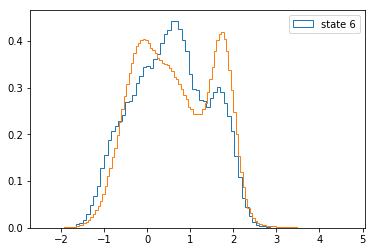

In [1839]:
for i in [6]:#,1,3,7]:
    plt.hist(pincercat[cg_trajscat==i],bins=64,density=True,histtype='step', label=f"state {i}");
plt.hist(pincercat,bins=128,density=True,histtype='step');
plt.legend();

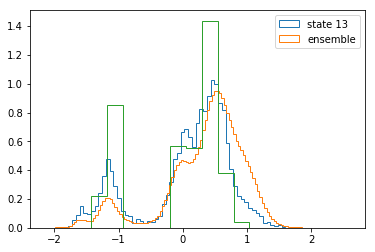

In [1656]:
for i in [13]:#,1,3,7]:
    plt.hist(cterm_order_cat[cg_trajscat==i],bins=64,density=True,histtype='step', label=f"state {i}");
plt.hist(cterm_order_cat,bins=128,density=True,histtype='step', label='ensemble');
plt.hist([state_avg_CTICM[reindex_obs_set][pw][0] for i, (pw, pww) in enumerate(zip(*pathways_))], weights=[pww for i, (pw, pww) in enumerate(zip(*pathways_))], bins=10,density=True, histtype='step');
#plt.hist(state_avg_CTICM[reindex_obs_set][np.array([st[0] for st in sim_trajs if len(st)<50])], bins=8,density=True, histtype='step')
plt.legend();

In [1675]:
transition_state_frames = np.where(np.logical_and(tpt_.committor[np.concatenate(model.discrete_trajectories_active)]>0.48,tpt_.committor[np.concatenate(model.discrete_trajectories_active)]<0.52) )[0]
#tpt_.committor[reindex_obs_set[dtrajcat]]

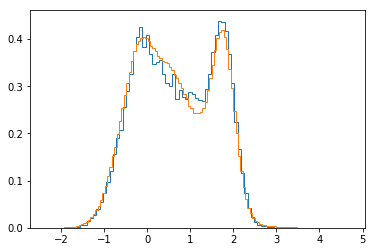

In [1823]:
plt.hist(pincercat[transition_state_frames],bins=64,density=True,histtype='step');
plt.hist(pincercat,bins=128,density=True,histtype='step');

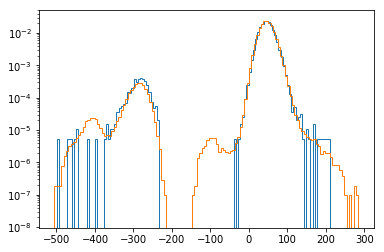

In [1824]:
plt.hist(pflipcat[transition_state_frames],bins=128,density=True,histtype='step')
plt.hist(pflipcat,bins=128,density=True,histtype='step',log=True);

In [1678]:
np.sum(pflipcat[transition_state_frames]<-200)/(np.sum(pflipcat[transition_state_frames]>-200)+np.sum(pflipcat[transition_state_frames]<-200))

0.02013792304126101

In [1679]:
np.sum(pflipcat[:]<-200)/(np.sum(pflipcat[:]>-200)+np.sum(pflipcat[:]<-200))

0.01597433309556719

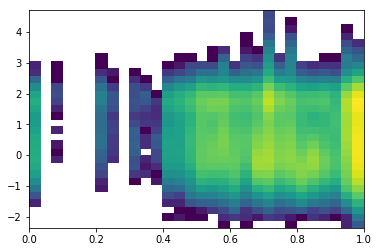

In [1687]:

plt.hist2d(tpt_.committor[np.concatenate(model.discrete_trajectories_active)] ,pincercat,bins=30,norm=mpl.colors.LogNorm());

In [2596]:
def axis_normed_hist2d(x, y, bins=10, ax=None, axis=1, norm=None, weights=None):
    _hist, _xedge, _yedge = np.histogram2d(x,
                                         y,
                                       bins=bins, weights=weights)
    _hist_norm = _hist/_hist.sum(axis=axis, keepdims=True)
    if ax==None:
        ax = plt.gca().pcolormesh(_xedge, _yedge, _hist_norm.T, norm=norm)
    else:
        ax.pcolormesh(_xedge, _yedge, _hist_norm.T, norm=norm)
    return ax

In [2598]:
model.trajectory_weights

<bound method _MSMEstimator.trajectory_weights of BayesianMSM(conf=0.95, connectivity='largest', count_mode='effective',
      dt_traj='1 step', lag=41, mincount_connectivity='1/n', nsamples=100,
      nsteps=25, reversible=True, show_progress=True, sparse=False,
      statdist_constraint=None)>

/Users/solsson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


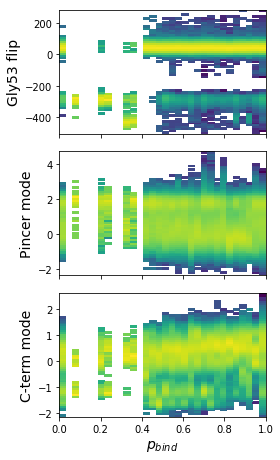

In [2654]:
fig,ax = plt.subplots(3,1,sharex=True, figsize=(4,6.5))
axis_normed_hist2d(tpt_.committor[np.concatenate(model.discrete_trajectories_active)], 
                   pflipcat, 
                   axis=1,
                   ax=ax[0],
                   bins=[32,64],
                  norm=mpl.colors.LogNorm(),
                  weights=np.concatenate(model.trajectory_weights()))
# ax[0].scatter(tpt_.qplus,
#            state_avg_pflip[reindex_obs_set],color='m', s=1)
axis_normed_hist2d(tpt_.committor[np.concatenate(model.discrete_trajectories_active)], 
                   pincercat, 
                   axis=1,
                   ax=ax[1],
                   bins=[32,64],
                  norm=mpl.colors.LogNorm(),
                  weights=np.concatenate(model.trajectory_weights()))
ax[0].set_ylabel("Gly53 flip", fontsize=14)
# ax[1].scatter(tpt_.qplus,
#            state_avg_pincer[reindex_obs_set],color='m', s=1)
axis_normed_hist2d(tpt_.committor[np.concatenate(model.discrete_trajectories_active)], 
                   cterm_order_cat, 
                   axis=1,
                   ax=ax[2],
                   bins=[32,64],
                  norm=mpl.colors.LogNorm(),
                  weights=np.concatenate(model.trajectory_weights()))
ax[1].set_ylabel("Pincer mode", fontsize=14)

# ax[2].scatter(tpt_.qplus,
#            state_avg_CTICM[reindex_obs_set],color='m', s=1)
for _ in ax:
    _.set_xlim(0,1)
ax[2].set_xlabel(r'$p_{bind}$', fontsize=14)
ax[2].set_ylabel("C-term mode", fontsize=14)
plt.tight_layout()
plt.savefig("mode_commitor.pdf")
#for i,(x,y) in enumerate(zip(mflux[-1].qplus,

/Users/solsson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


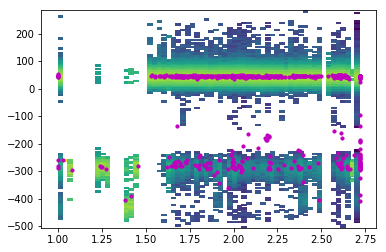

In [2336]:
fig,ax = plt.subplots(1,1)
axis_normed_hist2d(np.exp(tpt_.committor[np.concatenate(model.discrete_trajectories_active)]), 
                   pflipcat, 
                   axis=1,
                   ax=ax,
                   bins=[64,128],
                  norm=mpl.colors.LogNorm())
ax.scatter(np.exp(tpt_.qplus),
           state_avg_pflip[reindex_obs_set],color='m', s=10)
#for i,(x,y) in enumerate(zip(mflux[-1].qplus,
#           new_membership.T.dot(state_avg_pflip[reindex_obs_set])/new_membership.sum(axis=0))):
#    ax.annotate(f"{i}", (x,y), fontsize=20)

/Users/solsson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


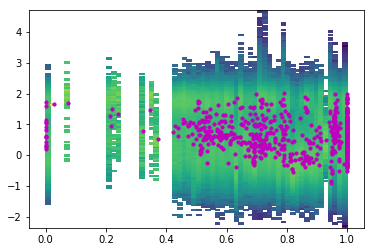

In [2337]:
fig,ax = plt.subplots(1,1)
axis_normed_hist2d(tpt_.committor[np.concatenate(model.discrete_trajectories_active)], 
                   pincercat, 
                   axis=1,
                   ax=ax,
                   bins=[64,128],
                  norm=mpl.colors.LogNorm())
ax.scatter(tpt_.qplus,
           state_avg_pincer[reindex_obs_set],color='m', s=10)
#for i,(x,y) in enumerate(zip(mflux[-1].qplus,
#           new_membership.T.dot(state_avg_pflip[reindex_obs_set])/new_membership.sum(axis=0))):
#    ax.annotate(f"{i}", (x,y), fontsize=20)

/Users/solsson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


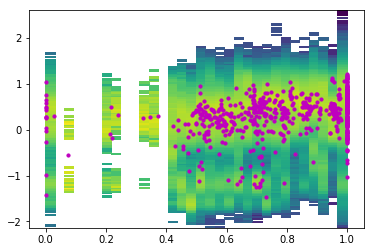

In [2338]:
fig,ax = plt.subplots(1,1)
axis_normed_hist2d(tpt_.committor[np.concatenate(model.discrete_trajectories_active)], 
                   cterm_order_cat, 
                   axis=1,
                   ax=ax,
                   bins=[32,128],
                  norm=mpl.colors.LogNorm())
ax.scatter(tpt_.qplus,
           state_avg_CTICM[reindex_obs_set],color='m', s=10)
# for i, (pw, pww) in enumerate(zip(*pathways_)):
#     plt.plot(tpt_.committor[pw],  state_avg_CTICM1[pw], c=plt.get_cmap('Reds_r')((i+0.5)/100.5), lw=10*pww/np.sum(pathways_[1][:10]))
#    # print(len(pw))
#     if i==100:
#         break
#for i,(x,y) in enumerate(zip(mflux[-1].qplus,
#           new_membership.T.dot(state_avg_pflip[reindex_obs_set])/new_membership.sum(axis=0))):
#    ax.annotate(f"{i}", (x,y), fontsize=20)

In [2339]:
committor_0_frames = tpt_.committor[np.concatenate(model.discrete_trajectories_active)]==0

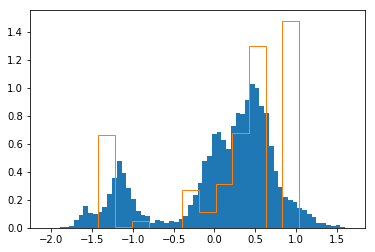

In [2340]:
plt.hist(cterm_order_cat[committor_0_frames], bins=64, density=True);
init_states = []
weights = []
for i, (pw, pww) in enumerate(zip(*pathways_)):
    init_states.append(state_avg_CTICM[pw[0]])
    weights.append(pww)
plt.hist(init_states, weights=weights, bins=12, density=True,histtype='step');



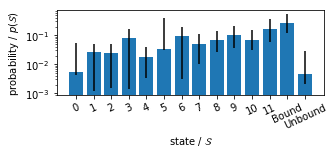

In [2650]:
fig,ax = plt.subplots(1,1, figsize=(4.75,2.25))
ax.bar(range(14),
        np.array(model.sample_f('stationary_distribution')).dot(new_membership).mean(axis=0),
       yerr=mt.util.statistics.confidence_interval(np.array(model.sample_f('stationary_distribution')).dot(new_membership)),
      log=True)
ax.set_xticks(range(14));
ax.set_xticklabels([f"{i}" for i in range(12)]+["Bound", "Unbound"], rotation=25)
ax.set_xlabel(r"state / $\mathcal{S}$")
ax.set_ylabel(r"probability / $p(\mathcal{S})$")
fig.tight_layout()
fig.savefig("cg_statdist.pdf")

In [1821]:
cg_state_samples = model.sample_by_state(50, subset=new_membership.argmax(axis=0))
trajs = pyemma.coordinates.save_trajs(source, cg_state_samples)

In [1822]:
trajs

['set_000000.xtc',
 'set_000001.xtc',
 'set_000002.xtc',
 'set_000003.xtc',
 'set_000004.xtc',
 'set_000005.xtc',
 'set_000006.xtc',
 'set_000007.xtc',
 'set_000008.xtc',
 'set_000009.xtc',
 'set_000010.xtc',
 'set_000011.xtc',
 'set_000012.xtc',
 'set_000013.xtc',
 'set_000014.xtc']

In [1626]:
cg_trajs = [new_membership[dt,:].argmax(axis=1) for dt in model.discrete_trajectories_active ]

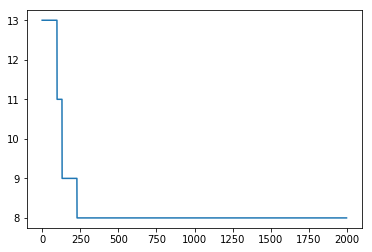

In [1627]:
plt.plot(cg_trajs[25])

In [1590]:
np.where([np.sum(np.isin([22,21], cgt))>1 for cgt in cg_trajs])

(array([], dtype=int64),)

In [1591]:
np.where([np.sum(np.isin([22,21,23], cgt))>1 for cgt in cg_trajs])

(array([], dtype=int64),)

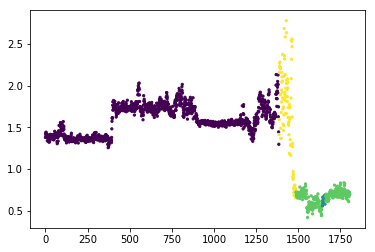

In [1729]:
k=946
plt.scatter(np.arange(rmsds[k].shape[0]), rmsds[k], c=cg_trajs[k]/23.,s=5)

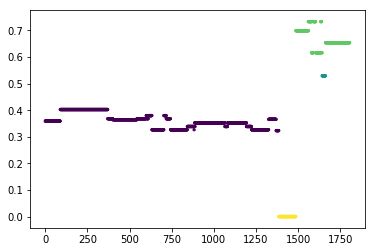

In [1593]:
plt.scatter(np.arange(rmsds[k].shape[0]), tpt_.committor[model.discrete_trajectories_active[k]], c=cg_trajs[k]/23.,s=5)

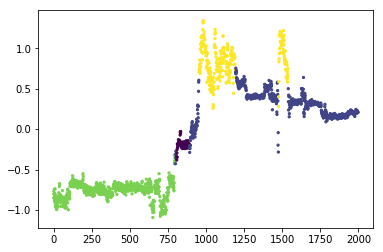

In [1594]:
plt.scatter(np.arange(rmsds[51].shape[0]), np.log(rmsds[51]), c=cg_trajs[51]/12.,s=5)

In [1595]:
for i in np.where([np.all(np.isin([19,18], cgt)) for cgt in cg_trajs])[0][:5]:
    plt.plot(cg_trajs[i])
    print(i)

In [1596]:
dtrajs_fixed2[25],model.discrete_trajectories_active[25]

(array([456, 456, 456, ..., 384, 384, 384], dtype=int32),
 array([447, 447, 447, ..., 379, 379, 379]))

In [1597]:
np.unique(cg_state_samples[-3][:,0],return_counts=True)

(array([ 21,  52, 107, 126, 192, 216, 229, 252, 312, 327, 343, 352, 374,
        390, 433, 438, 465, 546, 698, 722, 774]),
 array([4, 5, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 6, 2, 3, 3, 2, 3, 3, 6, 1]))

In [1598]:
trajs

['set_000000.xtc',
 'set_000001.xtc',
 'set_000002.xtc',
 'set_000003.xtc',
 'set_000004.xtc',
 'set_000005.xtc',
 'set_000006.xtc',
 'set_000007.xtc',
 'set_000008.xtc',
 'set_000009.xtc',
 'set_000010.xtc',
 'set_000011.xtc',
 'set_000012.xtc',
 'set_000013.xtc',
 'set_000014.xtc']

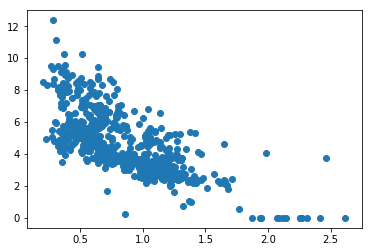

In [1624]:
plt.scatter(state_avg_rmsds[reindex_obs_set],-tpt_.qplus*np.log(model.stationary_distribution))
#plt.semilogy()

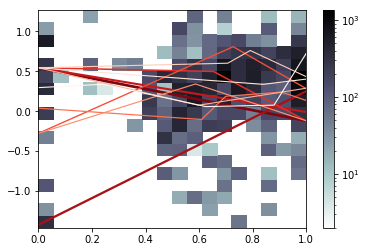

In [1731]:

im=plt.hist2d(tpt_.committor[np.concatenate(pathways_[0])],
           state_avg_CTICM[np.concatenate(pathways_[0])],
                                         bins=18,
                                         norm=mpl.colors.LogNorm(), cmap='bone_r');
plt.colorbar()
for i, (pw, pww) in enumerate(zip(*pathways_)):
    plt.plot(tpt_.committor[pw],  state_avg_CTICM[pw], c=plt.get_cmap('Reds_r')((i+0.5)/10.5), lw=10*pww/np.sum(pathways_[1][:5]))
    if i==10:
        break

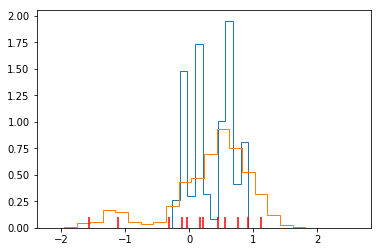

In [1601]:
plt.hist([state_avg_CTICM[pw][0] for i, (pw, pww) in enumerate(zip(*pathways_unbind))], weights=[pww for i, (pw, pww) in enumerate(zip(*pathways_unbind))], bins=10,density=True, histtype='step');

plt.hist(cterm_order_cat, bins=24,density=True, histtype='step');
plt.vlines(km2.cluster_centers_[:,0], 0, 0.1, color='r')

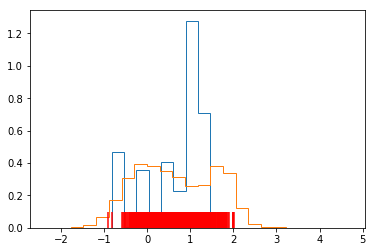

In [1602]:
plt.hist([state_avg_pincer[pw][0] for i, (pw, pww) in enumerate(zip(*pathways_unbind))], weights=[pww for i, (pw, pww) in enumerate(zip(*pathways_unbind))], bins=8,density=True, histtype='step');

plt.hist(pincercat, bins=24,density=True, histtype='step');
plt.vlines(state_avg_pincer, 0, 0.1, color='r')

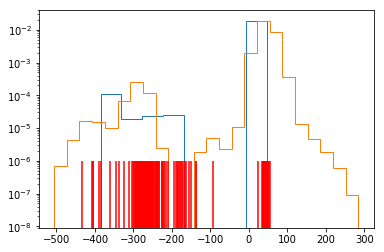

In [1603]:
plt.hist([state_avg_pflip[pw][0] for i, (pw, pww) in enumerate(zip(*pathways_unbind))], weights=[pww for i, (pw, pww) in enumerate(zip(*pathways_unbind))], bins=8,density=True, histtype='step');

plt.hist(pflipcat, bins=24,density=True, histtype='step',log=True);
plt.vlines(state_avg_pflip, 0, 0.000001, color='r')

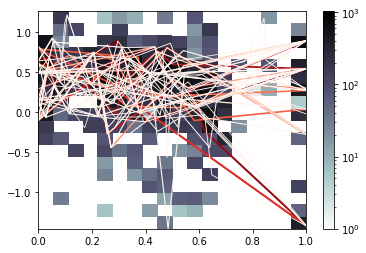

In [1604]:

im=plt.hist2d(tpt_unbind.committor[np.concatenate(pathways_unbind[0])],
           state_avg_CTICM[np.concatenate(pathways_unbind[0])],
                                         bins=18,
                                         norm=mpl.colors.LogNorm(), cmap='bone_r');
plt.colorbar()
for i, (pw, pww) in enumerate(zip(*pathways_unbind)):
    plt.plot(tpt_unbind.committor[pw],  state_avg_CTICM[pw], c=plt.get_cmap('Reds_r')((i+0.5)/16.5), lw=10*pww/np.sum(pathways_[1][:5]))
    if i==50:
        break

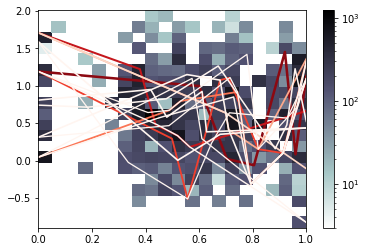

In [1605]:

im=plt.hist2d(tpt_.committor[np.concatenate(pathways_[0])],
           state_avg_pincer[np.concatenate(pathways_[0]) ],
                                         bins=20,
                                         norm=mpl.colors.LogNorm(), cmap='bone_r');
plt.colorbar()
for i, (pw, pww) in enumerate(zip(*pathways_)):
    plt.plot(tpt_.committor[pw],  state_avg_pincer[pw], c=plt.get_cmap('Reds_r')((i+0.5)/6.5), lw=10*pww/np.sum(pathways_[1][:5]))
    if i==15:
        break

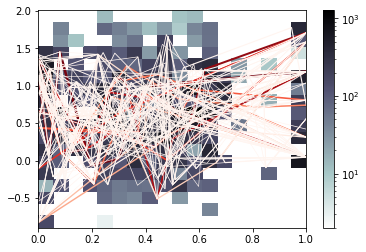

In [1606]:

im=plt.hist2d(tpt_unbind.committor[np.concatenate(pathways_unbind[0])],
           state_avg_pincer[np.concatenate(pathways_unbind[0])],
                                         bins=18,
                                         norm=mpl.colors.LogNorm(), cmap='bone_r');
plt.colorbar()
for i, (pw, pww) in enumerate(zip(*pathways_unbind)):
    plt.plot(tpt_unbind.committor[pw],  state_avg_pincer[pw], c=plt.get_cmap('Reds_r')((i+0.5)/16.5), lw=10*pww/np.sum(pathways_[1][:5]))
    if i==100:
        break

In [1607]:
contact_feature_index = np.array([i for i,f in enumerate(feat.describe()) if "GROUP_MINDIST" in f])

In [1608]:
contact_features_cat = np.log(np.mean(np.vstack([d[:, contact_feature_index] for d in data ]),axis=1) )

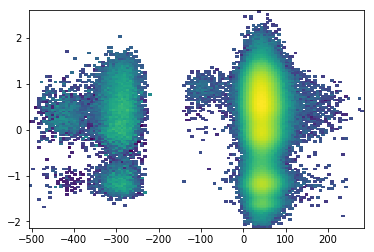

In [1609]:
plt.hist2d(pflipcat, unbound_project[:,0], bins=120, norm=mpl.colors.LogNorm(), weights=np.concatenate(model.trajectory_weights()));

In [344]:
[pw[0] for pw in pathways_[0][:20]]

[443,
 446,
 446,
 453,
 452,
 452,
 443,
 443,
 452,
 452,
 453,
 452,
 453,
 446,
 447,
 446,
 443,
 453,
 453,
 446]

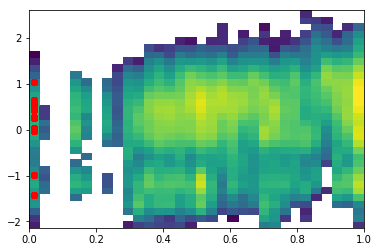

In [1621]:
plt.hist2d(tpt_.committor[np.concatenate(model.discrete_trajectories_active)], unbound_project[:,0], bins=32, norm=mpl.colors.LogNorm(), weights=np.concatenate(model.trajectory_weights()));
plt.scatter(tpt_.committor[[pw[0] for pw in pathways_[0][:]]]+0.015, state_avg_CTICM[reindex_obs_set][[pw[0] for pw in pathways_[0][:]]], c='r')

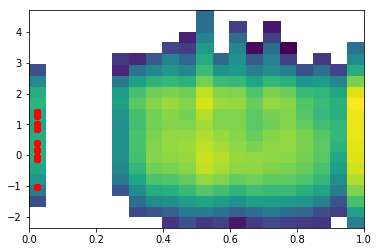

In [162]:
plt.hist2d(tpt_.committor[np.concatenate(model.discrete_trajectories_active)], pincercat, bins=20, norm=mpl.colors.LogNorm(), weights=np.concatenate(model.trajectory_weights()));
plt.scatter(tpt_.committor[[pw[0] for pw in pathways_[0][:10000]]]+0.025, pincercat[[pw[0] for pw in pathways_[0][:10000]]], c='r')

In [477]:
for a in pathways_[:10]:
    print(len(a))

2470
2470


In [229]:
sim_ul_lation = model.stimulate(20000,start=451)

plt.scatter(np.arange(20000)*80+80,state_avg_icd[sim_ul_lation],c=model.metastable_assignments[sim_ul_lation],s=2,cmap='jet')
#plt.semilogy()
plt.colorbar()

NameError: name 'state_avg_icd' is not defined

In [154]:
plt.scatter(state_avg_rmsd[sim_ul_lation], model.metastable_assignments[sim_ul_lation], s=2)


NameError: name 'state_avg_rmsd' is not defined

In [79]:
binding_=model.generate_traj(2000, start=451)

In [80]:
pyemma.coordinates.save_traj(source, binding_, "binding.pdb")

/Users/solsson/miniconda3/lib/python3.6/site-packages/pyemma/coordinates/data/fragmented_trajectory_reader.py:195: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ra = self.ra_indices[frag_inds] - offset


13-12-18 16:16:46 pyemma.coordinates.api INFO     Created file binding.pdb


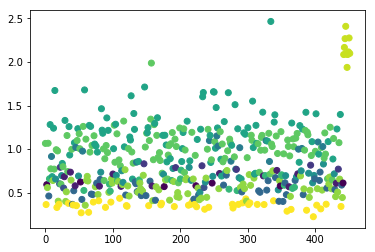

In [163]:
plt.scatter(np.arange(model.active_set.shape[0]), state_avg_rmsds[reindex_obs_set], c=new_membership.argmax(axis=1))

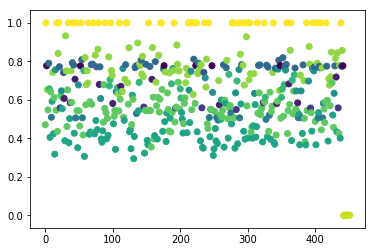

In [164]:
plt.scatter(np.arange(model.active_set.shape[0]), tpt_.committor, c=new_membership.argmax(axis=1))

In [165]:
trajs

['set_000000.xtc',
 'set_000001.xtc',
 'set_000002.xtc',
 'set_000003.xtc',
 'set_000004.xtc',
 'set_000005.xtc',
 'set_000006.xtc',
 'set_000007.xtc',
 'set_000008.xtc',
 'set_000009.xtc',
 'set_000010.xtc',
 'set_000011.xtc',
 'set_000012.xtc',
 'set_000013.xtc']

In [158]:
pyemma.plots.contour(state_avg_rmsd[model.active_set],state_avg_tics[model.active_set, 1], model.stationary_distribution)

NameError: name 'state_avg_rmsd' is not defined

In [159]:
model.active_set[-10:]

array([453, 454, 456, 457, 458, 459, 460, 461, 462, 464])

In [160]:
import msmtools as mt

In [161]:
rmsd_co = 0.4
reduced_MSM = model.P[state_avg_rmsd<rmsd_co, :][:, state_avg_rmsd<rmsd_co]
reduced_MSM = reduced_MSM/reduced_MSM.sum(axis=1, keepdims = True)


NameError: name 'state_avg_rmsd' is not defined

In [162]:
model.stationary_distribution[323]

0.00025546287426154475

In [163]:
np.where(state_avg_rmsd<rmsd_co)[0][35]

NameError: name 'state_avg_rmsd' is not defined

In [164]:
pcca_lrmsd = mt.analysis.pcca(reduced_MSM, 5)

NameError: name 'reduced_MSM' is not defined

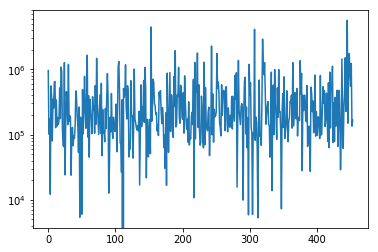

In [165]:
plt.semilogy([model.mfpt(np.argmax(model.stationary_distribution), i) for i in np.arange(model.nstates)])

In [206]:
fluxes = [pyemma.msm.tpt(model, [i], model.stationary_distribution.argsort()[::-1][:3]) for i in range(450,460)]

ValueError: set A or B defines more states, than given transition matrix.

In [166]:
[f.mfpt for f in fluxes]

NameError: name 'fluxes' is not defined

In [167]:
[plt.plot(state_avg_rmsd,f.committor) for f in  fluxes]

NameError: name 'fluxes' is not defined

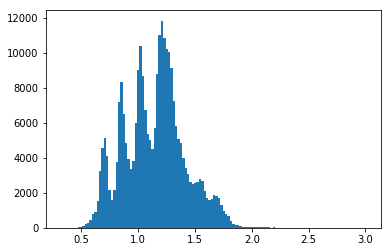

In [2997]:
plt.hist(np.concatenate(rmsds)[np.where(cg_trajscat==9)[0]],128);

In [1622]:
state_samples = model.sample_by_state(100)
pyemma.coordinates.save_trajs(source, state_samples, prefix="msm_")

['msm_000000.xtc',
 'msm_000001.xtc',
 'msm_000002.xtc',
 'msm_000003.xtc',
 'msm_000004.xtc',
 'msm_000005.xtc',
 'msm_000006.xtc',
 'msm_000007.xtc',
 'msm_000008.xtc',
 'msm_000009.xtc',
 'msm_000010.xtc',
 'msm_000011.xtc',
 'msm_000012.xtc',
 'msm_000013.xtc',
 'msm_000014.xtc',
 'msm_000015.xtc',
 'msm_000016.xtc',
 'msm_000017.xtc',
 'msm_000018.xtc',
 'msm_000019.xtc',
 'msm_000020.xtc',
 'msm_000021.xtc',
 'msm_000022.xtc',
 'msm_000023.xtc',
 'msm_000024.xtc',
 'msm_000025.xtc',
 'msm_000026.xtc',
 'msm_000027.xtc',
 'msm_000028.xtc',
 'msm_000029.xtc',
 'msm_000030.xtc',
 'msm_000031.xtc',
 'msm_000032.xtc',
 'msm_000033.xtc',
 'msm_000034.xtc',
 'msm_000035.xtc',
 'msm_000036.xtc',
 'msm_000037.xtc',
 'msm_000038.xtc',
 'msm_000039.xtc',
 'msm_000040.xtc',
 'msm_000041.xtc',
 'msm_000042.xtc',
 'msm_000043.xtc',
 'msm_000044.xtc',
 'msm_000045.xtc',
 'msm_000046.xtc',
 'msm_000047.xtc',
 'msm_000048.xtc',
 'msm_000049.xtc',
 'msm_000050.xtc',
 'msm_000051.xtc',
 'msm_000052

In [167]:
plt.hist(state_avg_rmsd[sim_ul_lation],bins=64)

NameError: name 'state_avg_rmsd' is not defined

In [168]:

plt.scatter(np.arange(len(dtc[::80])),state_avg_rmsd[dtc[::80]],c=dtc[::80],s=2)
plt.colorbar()

NameError: name 'state_avg_rmsd' is not defined

In [169]:
dtc=np.concatenate([dt for dt in model.discrete_trajectories_active if len(dt)])



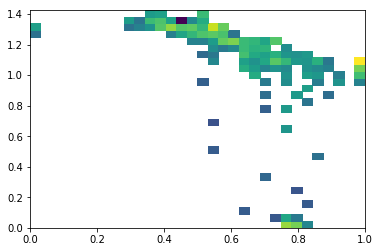

In [170]:
aebler=plt.hist2d(tpt_.committor[dtc], 
           np.exp(model.eigenvectors_right()[dtc, 1]), bins=32, norm = mpl.colors.LogNorm())

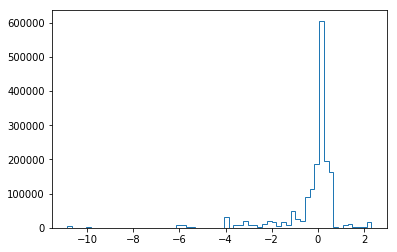

In [171]:
kjdfh=plt.hist(model.eigenvectors_right()[dtc, 5], bins=64,histtype='step')#, log=True)

In [172]:
np.argsort(model.eigenvectors_right()[dtc, 2])[::-1]

array([ 345143,  346125,  346135, ..., 1154743, 1154744, 1154991])

In [852]:
km0.transform([ystack[[ 222973, 1321043, 1321052],:4].reshape(3,-1)])

[array([[26],
        [26],
        [26]], dtype=int32)]

In [841]:
ystack[187436,:4].shape

(4,)

In [853]:
km0.cluster_centers_[26,:]

array([-0.7955725 ,  1.7411165 , -0.26889852, -0.7679217 ], dtype=float32)

In [790]:
model.metastable_distributions[:,-1]

array([0.0009537 , 0.00839639, 0.00568081, 0.00215608, 0.00287962,
       0.00157476, 0.00317427, 0.00414323, 0.00721575, 0.00088163])

ValueError: shape mismatch: objects cannot be broadcast to a single shape

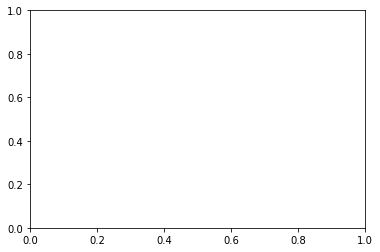

In [166]:
plt.bar(np.arange(1,8),pcca.coarse_grained_stationary_probability)

<BarContainer object of 20 artists>

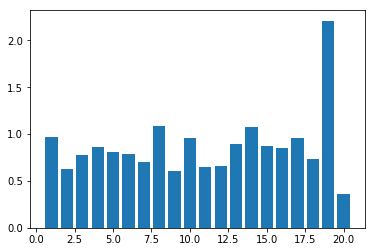

In [181]:
plt.bar(np.arange(1,21),new_membership.T.dot(state_avg_rmsds[reindex_obs_set])/new_membership.sum(axis=0) )

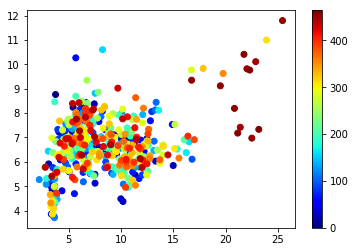

In [184]:
plt.scatter(np.array(state_avg_rmsds)[reindex_obs_set]*10,-np.log(model.stationary_distribution),c=model.active_set,cmap='jet')
plt.colorbar()
#plt.semilogx()

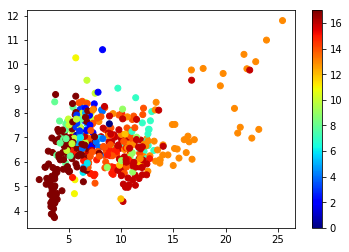

In [185]:
plt.scatter(np.array(state_avg_rmsds)[reindex_obs_set]*10,-np.log(model.stationary_distribution), c=model.metastable_assignments, cmap='jet')#,c=pcca.metastable_assignment/15.,cmap='jet')
plt.colorbar()
#plt.semilogx()

In [185]:
pcca.coarse_grained_stationary_probability

NameError: name 'pcca' is not defined

In [184]:
sd=plt.hist(np.concatenate(npinc)[dtc==137],bins=128, histtype='step',normed=True)
sff=plt.hist(np.concatenate(npinc)[dtc==450],bins=128, histtype='step',normed=True)
dsf=plt.hist(np.concatenate(npinc),bins=128, histtype='step',normed=True)

NameError: name 'npinc' is not defined

In [186]:
flux_ = pyemma.msm.tpt(model,[km0.n_clusters+1], [km0.n_clusters])

In [187]:
plt.scatter(flux_.committor,np.array(state_avg_rmsd)[model.active_set]*10)

NameError: name 'state_avg_rmsd' is not defined

In [188]:
model.sample_mean('mfpt',501, range(501))

AssertionError: Chosen set contains states that are not included in the active set.

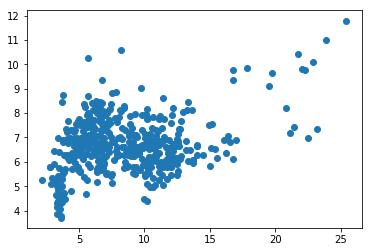

In [190]:
plt.scatter(np.array(state_avg_rmsds)[reindex_obs_set]*10,-np.log(model.stationary_distribution))

In [191]:
1.987*305*(-np.log(model.stationary_distribution[-1])+np.log(model.stationary_distribution[-2]))*1e-3

0.09249798612345589

In [190]:
state_reac_flux = np.array([np.max([np.sum(flux.flux[:,i]),np.sum(flux.flux[:,i])]) for i in model.active_set])
plt.scatter(np.log(state_reac_flux), flux.committor)

NameError: name 'flux' is not defined

In [191]:
def identify_k_kinetically_close_states(msmobj, stateidx, kinetic_distance, k):
    p0 = np.zeros(msmobj.stationary_distribution.shape)
    p0[stateidx] = 1
    return np.argsort(msmobj.propagate(p0, kinetic_distance))[-k:][::-1]

In [192]:

st_=identify_k_kinetically_close_states(model, model.stationary_distribution.argmax(), 2, k=50)
print(state_avg_rmsd[st_].dot(model.stationary_distribution[st_]/model.stationary_distribution[st_].sum()))
print(model.stationary_distribution[st_].sum())

0.35487017115938047
0.30047188982973944


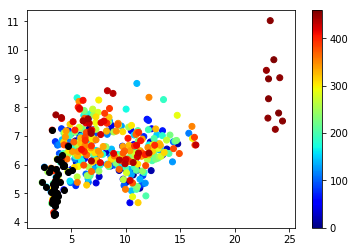

In [193]:
plt.scatter(np.array(state_avg_rmsd)[model.active_set]*10,-np.log(model.stationary_distribution),c=model.active_set,cmap='jet')
plt.colorbar()

plt.scatter(np.array(state_avg_rmsd)[st_]*10,-np.log(model.stationary_distribution[st_]),c='k')

#plt.semilogx()

[[<matplotlib.lines.Line2D at 0x1a7da2efd0>],

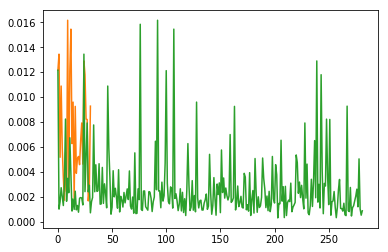

In [400]:
[plt.plot(model.stationary_distribution[identify_kinetically_close_states(model, model.stationary_distribution.argmax(), i)]) for i in range(3)]

/Users/solsson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


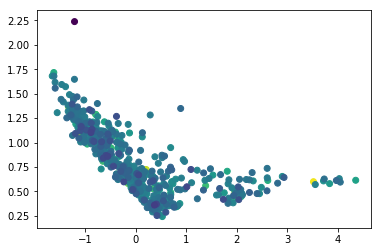

In [795]:
plt.scatter(np.array(state_avg_tics)[:,0], 
          np.array(state_avg_rmsd), c=-np.log(np.array(state_reac_flux)[np.argsort(state_reac_flux)[:][:]]))

plt.savefig('yo__.pdf')

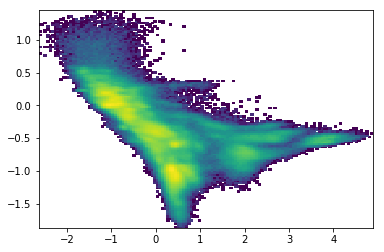

In [776]:

ksdjfn=plt.hist2d(ftc[:,0],np.log(np.concatenate(rmsds)),bins=128, norm=mpl.colors.LogNorm())

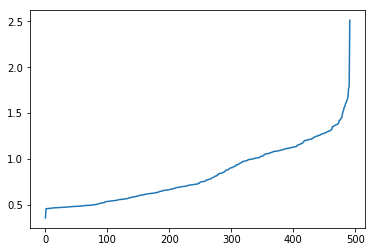

In [57]:
plt.plot(np.array(state_avg_rmsd)[model.active_set][np.argsort(np.array(state_avg_rmsd)[model.active_set])])

In [960]:
sampled_states=model.sample_by_distributions(cgem, 2nfsource000)
for i,sampls in enumerate(sampled_states[:]):
    filename = f"metastable_{i}.xtc"
    pyemma.coordinates.save_traj(nfsource, sampls, outfile=filename)
#model.metastable_distributions

16-12-18 10:52:44 pyemma.coordinates.api INFO     Created file metastable_0.xtc
16-12-18 10:52:49 pyemma.coordinates.api INFO     Created file metastable_1.xtc
16-12-18 10:52:53 pyemma.coordinates.api INFO     Created file metastable_2.xtc
16-12-18 10:53:03 pyemma.coordinates.api INFO     Created file metastable_3.xtc
16-12-18 10:53:13 pyemma.coordinates.api INFO     Created file metastable_4.xtc
16-12-18 10:53:24 pyemma.coordinates.api INFO     Created file metastable_5.xtc
16-12-18 10:53:28 pyemma.coordinates.api INFO     Created file metastable_6.xtc


In [946]:
np.any(np.concatenate(chain_contact)[np.isin(np.concatenate(dtrajs_fixed), range(450,460))]<1.)

False

In [933]:
[chain_contact[tidx][fidx] for tidx,fidx in sampled_states[6]]

[2.2580454,
 2.1059737,
 1.9726902,
 2.5217834,
 1.3718779,
 3.7909033,
 1.5384179,
 2.4320042,
 1.9862412,
 1.1004442,
 1.0032377,
 2.3545313,
 2.9192648,
 2.7522345,
 2.0574598,
 3.017028,
 3.395487,
 3.1248133,
 2.0305097,
 1.3535484,
 2.649192,
 2.2467391,
 1.2449284,
 1.1507345,
 2.2832115,
 2.3663008,
 2.4109447,
 3.0036654,
 1.5923675,
 1.0024571,
 2.5620916,
 1.0634409,
 2.6893363,
 1.4971793,
 1.6651876,
 2.1779635,
 1.4384458,
 2.6483824,
 1.1526407,
 1.0297675,
 3.1985512,
 1.4406823,
 1.2738488,
 2.014849,
 2.2309568,
 2.2435005,
 3.2203002,
 1.7138275,
 2.220412,
 1.6884952,
 2.423029,
 2.1473234,
 1.5904295,
 1.9085332,
 1.6086646,
 2.8860993,
 2.2138004,
 2.0148723,
 1.628149,
 2.8092303,
 1.5580838,
 2.6884446,
 1.5821079,
 2.648179,
 4.191892,
 1.6293222,
 2.1485376,
 2.203391,
 1.4203235,
 3.051839,
 2.3382876,
 2.861903,
 1.3332474,
 2.2138004,
 4.2411375,
 1.2342197,
 3.362003,
 1.0058492,
 1.0416532,
 1.3404664,
 1.7115283,
 2.6868403,
 1.2663019,
 1.7954123,
 1.80

In [961]:
sampled_states=model.sample_by_state(1000)
pyemma.coordinates.save_trajs(nfsource, sampled_states, prefix='state_', fmt='xtc')
#model.metastable_distributionssampled_states

['state_000000.xtc',
 'state_000001.xtc',
 'state_000002.xtc',
 'state_000003.xtc',
 'state_000004.xtc',
 'state_000005.xtc',
 'state_000006.xtc',
 'state_000007.xtc',
 'state_000008.xtc',
 'state_000009.xtc',
 'state_000010.xtc',
 'state_000011.xtc',
 'state_000012.xtc',
 'state_000013.xtc',
 'state_000014.xtc',
 'state_000015.xtc',
 'state_000016.xtc',
 'state_000017.xtc',
 'state_000018.xtc',
 'state_000019.xtc',
 'state_000020.xtc',
 'state_000021.xtc',
 'state_000022.xtc',
 'state_000023.xtc',
 'state_000024.xtc',
 'state_000025.xtc',
 'state_000026.xtc',
 'state_000027.xtc',
 'state_000028.xtc',
 'state_000029.xtc',
 'state_000030.xtc',
 'state_000031.xtc',
 'state_000032.xtc',
 'state_000033.xtc',
 'state_000034.xtc',
 'state_000035.xtc',
 'state_000036.xtc',
 'state_000037.xtc',
 'state_000038.xtc',
 'state_000039.xtc',
 'state_000040.xtc',
 'state_000041.xtc',
 'state_000042.xtc',
 'state_000043.xtc',
 'state_000044.xtc',
 'state_000045.xtc',
 'state_000046.xtc',
 'state_00004

(array([1.0000e+01, 1.7000e+01, 2.6000e+01, 6.6000e+01, 1.0200e+02,
        2.0000e+02, 2.9900e+02, 4.0700e+02, 4.6900e+02, 5.1400e+02,
        5.1400e+02, 5.2600e+02, 4.7200e+02, 5.0500e+02, 5.1400e+02,
        6.7000e+02, 7.9600e+02, 9.9300e+02, 1.1210e+03, 1.1720e+03,
        1.0650e+03, 1.1260e+03, 1.0920e+03, 1.1470e+03, 1.1460e+03,
        1.3090e+03, 1.4970e+03, 1.6560e+03, 1.8950e+03, 2.1100e+03,
        2.4350e+03, 2.5910e+03, 3.0430e+03, 3.3760e+03, 3.8220e+03,
        4.2520e+03, 4.7240e+03, 5.2850e+03, 5.9560e+03, 6.9620e+03,
        7.6170e+03, 8.6360e+03, 9.4620e+03, 1.0133e+04, 1.0993e+04,
        1.1827e+04, 1.2287e+04, 1.2909e+04, 1.3042e+04, 1.3183e+04,
        1.3428e+04, 1.3561e+04, 1.3664e+04, 1.3608e+04, 1.3854e+04,
        1.4099e+04, 1.4302e+04, 1.4629e+04, 1.4295e+04, 1.3884e+04,
        1.2941e+04, 1.1893e+04, 1.0898e+04, 9.5340e+03, 8.0360e+03,
        6.7370e+03, 5.7570e+03, 4.9880e+03, 4.6500e+03, 4.2970e+03,
        4.2760e+03, 4.4040e+03, 4.4800e+03, 4.63

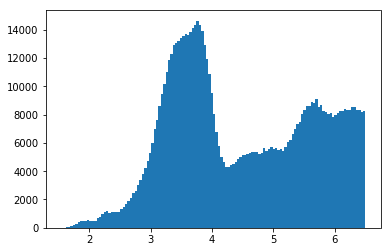

In [329]:
plt.hist(np.concatenate(rmsds)[np.concatenate(rmsds)<0.65]*10.,bins=128)

In [732]:
its_fixed_hmm = pyemma.msm.timescales_hmsm(dtrajs_fixed,nstates=20, lags=100, errors='bayes')

/Users/solsson/miniconda3/lib/python3.6/site-packages/msmtools/analysis/dense/decomposition.py:555: RuntimeWarning: divide by zero encountered in log
  -1.0 * tau / np.log(np.abs(evals[np.logical_not(ind_abs_one)]))
Process ForkPoolWorker-242:
Process ForkPoolWorker-244:
Process ForkPoolWorker-243:
Process ForkPoolWorker-241:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
 

KeyboardInterrupt: 

  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/pyemma/_base/estimator.py", line 138, in _estimate_param_scan_worker
    estimator.estimate(X, **params)


  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/pyemma/_base/estimator.py", line 138, in _estimate_param_scan_worker
    estimator.estimate(X, **params)
  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/pyemma/_base/estimator.py", line 415, in estimate
    self._model = self._estimate(X)
  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/multiprocess/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/pyemma/_base/estimator.py", line 415, in estimate
    self._model = self._estimate(X)
  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/pyemma/_base/estimator.py", line 415, in estimate
    self._model = self._estimate(X)
  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/pyemma/msm/estimators/bayesian_hmsm.py", line 184, in _estimate
    super(BayesianHMSM, self)._estimate(dtrajs)
  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/pyemma/

In [21]:
Y = tica_objs[-1].get_output(stride=1)

In [26]:
for i,y in enumerate(Y):
    np.savez_compressed(f'tica_all_pairwise_{i}.npz', y[:, :50])

In [22]:
%matplotlib inline 
import matplotlib as mpl
from matplotlib import pyplot as plt

In [23]:
ys=np.vstack([y[:,:200] for y in Y])

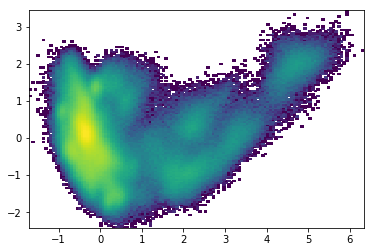

In [27]:
sdfjkh=plt.hist2d(ys[:,0],ys[:,3], bins=128, norm=mpl.colors.LogNorm())


In [154]:
tica_objs[0].

SyntaxError: invalid syntax (<ipython-input-154-37682b422b1b>, line 1)

In [155]:
source.filenames[1006]

['traj_noPBC/SH3_Ubq_Solv_944_eq_restart0_nowater_nopbc.xtc']

In [156]:
[i for i,y in enumerate(Y) if np.any(y[:,3]>11)]

[]

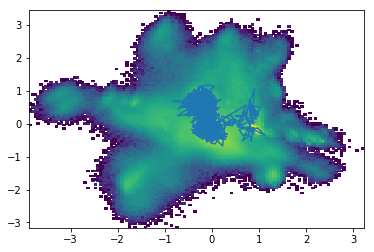

In [190]:
sdfjkh=plt.hist2d(ys[:,4],ys[:,5], bins=128, norm=mpl.colors.LogNorm())
plt.plot(Y[21][:,4], Y[21][:,5] )

In [158]:
source.filenames[21]

['traj_noPBC/SH3_Ubq_Solv_21_eq_prod_nowater_nopbc.xtc']

[[<matplotlib.lines.Line2D at 0x1a842f3550>],

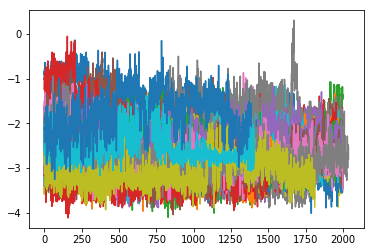

In [159]:
[plt.plot(Y[_][:,0]) for _ in [i for i,y in enumerate(Y) if np.any(y[:,0]<-3.1)]]

[[<matplotlib.lines.Line2D at 0x1a4101bac8>],

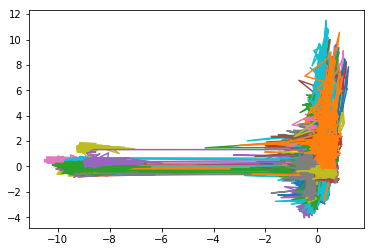

In [553]:
[plt.plot(Y[_][:,2],Y[_][:,3] ) for _ in [i for i,y in enumerate(Y) if np.any(y[:,0]<-1.5)][:]]

In [30]:
import simplex

In [31]:
Y[0].shape

(213, 52)

In [32]:

vertices = simplex.find_vertices_inner_simplex([y[::5,:] for y in Y], take_max_dims=20)
s = simplex.simplex_misfit(Y, vertices, extrema=False)


pass 1
pass 2
pass 3
pass 4
pass 5
pass 6
pass 7
pass 8
pass 9
pass 10
pass 11
pass 12
pass 13
pass 14
pass 15
pass 16
pass 17
pass 18
pass 19
pass 20


In [33]:
import pyemma

from pyemma.msm.estimators.lagged_model_validators import ChapmanKolmogorovValidator
from pyemma.msm.estimators.maximum_likelihood_msm import MaximumLikelihoodMSM
from pyemma.util.discrete_trajectories import index_states


class CoreSetMSM(MaximumLikelihoodMSM):
    r"""Coresetmsm"""
    __serialize_version = 0
    __serialize_fields = ()
    def __init__(self, lag=1, count_mode='sliding', connectivity='largest',
                 dt_traj='1 step', maxiter=1000000,
                 mincount_connectivity='1/n'):
        
        # Check count mode:
        self.count_mode = str(count_mode).lower()
        if self.count_mode not in ('sliding', 'sample'):
            raise ValueError('count mode ' + count_mode + ' is unknown. Only \'sliding\' and \'sample\' are allowed.')

        super(CoreSetMSM, self).__init__(lag=lag, reversible=True, count_mode=count_mode, sparse=False,
                                                   connectivity=connectivity, dt_traj=dt_traj, score_method=None,
                                                   score_k=None, mincount_connectivity=mincount_connectivity,
                                                   maxiter=maxiter)
    def _estimate(self, dtrajs):
        self._is_estimated = True

        self._C_full = simplex.milestoning_count_matrix(dtrajs, 
                                          lag = self.lag, 
                                          return_scrapped = False,
                                          return_mass_matrix = False)
        
        self._nstates_full = self._C_full.shape[0]
        
        self.active_set = msmtools.estimation.largest_connected_set(self._C_full)
        P = msmtools.estimation.tmatrix(
            self._C_full[self.active_set, :][:, self.active_set], 
            reversible = self.reversible)
        
        self._active_state_indexes = index_states(dtrajs, subset=self.active_set)
        
        self._dtrajs_full = dtrajs
        self._connected_sets = msmtools.estimation.connected_sets(self._C_full)
        self.set_model_params(P=P, pi=msmtools.analysis.statdist(P), reversible=self.reversible,
        dt_model=self.timestep_traj.get_scaled(self.lag))

        return self

In [194]:
def featurize_msmtraj(traj, ftrajs):
    return np.array([ftrajs[frame[0]][frame[1]] for frame in traj])
        

In [195]:

def whiten(X):
    U, s, Vt = np.linalg.svd(X-X.mean(axis=0), full_matrices=False)
    return U[:,:].dot(Vt[:,:])

def whiten_trajectories(trajs):
    cdat = np.concatenate(trajs)
    wcdat = whiten(cdat)
    return np.split(wcdat, np.cumsum([len(d) for d in trajs][:-1]))

In [92]:
cdata = np.concatenate(data)

In [93]:
plt.hist2d(cdata[:,4],cdata[:,3],bins=128,norm=mpl.colors.LogNorm())

IndexError: index 4 is out of bounds for axis 1 with size 3

In [107]:
second_select = [i for i,dt in enumerate(yprime) if not np.any(dt[:,0]>5)]

In [196]:
rmsds_selected0 = [y for i,y in enumerate(rmsds) if i not in np.where(ldelta!=0)[0]]
pincer_selected0 = [y for i,y in enumerate(pincer) if i not in np.where(ldelta!=0)[0]]
pflip_selected0 = [y for i,y in enumerate(pflip) if i not in np.where(ldelta!=0)[0]]

rmsds_selected = [y for i,y in enumerate(rmsds_selected0) if i in second_select]
pincer_selected = [y for i,y in enumerate(pincer_selected0) if i in second_select]
pflip_selected = [y for i,y in enumerate(pflip_selected0) if i in second_select]

In [536]:
wdat= whiten_trajectories([d for i,d in enumerate(data)])
wdat = [np.hstack((w, y[:,:9].reshape(-1,9))) for i,(w,y) in enumerate(zip(wdat, yprime)) if i in second_select]

In [592]:
km = pyemma.coordinates.cluster_kmeans([y[:,:9] for y in yprime], 384)

In [593]:
dtred = km.dtrajs

In [594]:
rhmmits = pyemma.msm.timescales_msm(dtred, lags=150)#, errors='bayes')

In [598]:
rhmmits = pyemma.msm.timescales_hmsm(dtred, 12, lags=100, errors='bayes')

/Users/solsson/miniconda3/lib/python3.6/site-packages/msmtools/analysis/dense/decomposition.py:545: SpectralWarning: Multiple eigenvalues with magnitude one.
  warnings.warn('Multiple eigenvalues with magnitude one.', SpectralWarning)


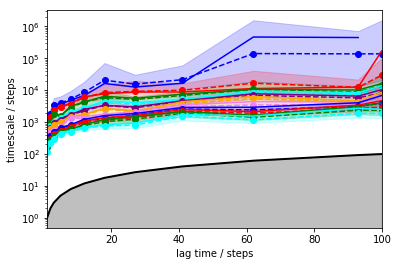

In [599]:
pyemma.plots.plot_implied_timescales(rhmmits,xlog=False)
#plt.xlim(10,90)
#plt.ylim(10,5e4)

In [603]:
hmm=rhmmits.models[-4]

In [604]:
hmm.eigenvectors_right_obs[:,1]

array([-6.78904430e-02, -8.91413487e-01, -5.57307017e-01, -2.20968385e-01,
        2.45089604e+00,  4.31170225e-02, -2.39650676e-02, -7.68765405e-03,
       -7.01088743e-02, -9.05873061e-01, -4.03435115e-01, -3.41824805e-01,
       -5.57307017e-01, -7.29601703e-02,  2.88353227e+00, -5.57307017e-01,
       -5.50293631e-01, -5.90685029e-02, -3.41824805e-01, -2.99232452e-01,
       -6.88491081e-02, -7.68765405e-03, -6.88491081e-02, -2.30172679e-01,
       -2.30052217e-01, -4.02998148e-01, -7.68765405e-03, -6.88491106e-02,
       -2.29230173e-01, -2.16818608e-01, -4.03435115e-01, -4.03435115e-01,
       -5.39943334e-02, -5.57307017e-01, -2.37140413e-02, -3.48839854e-01,
       -6.88491081e-02, -5.41261049e-01, -7.68765405e-03, -4.38621034e-01,
        6.90699515e-01, -6.36990298e-02, -2.48387968e-01, -4.03435115e-01,
       -5.53488996e-01, -6.98862126e-02, -9.05873061e-01, -5.55612188e-01,
       -3.33397110e-01, -2.46355920e-02, -7.23814500e-02, -1.37824861e-01,
       -6.88491081e-02, -

(<Figure size 432x288 with 2 Axes>,
 {'mappable': <matplotlib.contour.QuadContourSet at 0x1aa8d78b38>,
  'cbar': <matplotlib.colorbar.Colorbar at 0x1a76bf5710>})

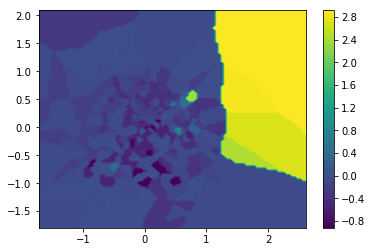

In [617]:
pyemma.plots.plot_contour(km.cluster_centers_[:,8], km.cluster_centers_[:, 7], hmm.eigenvectors_right_obs[:,1])

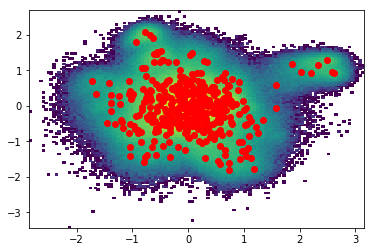

In [622]:
plt.hist2d(np.concatenate(yprime)[:,8],np.concatenate(yprime)[:,7],bins=128,norm=mpl.colors.LogNorm())

plt.scatter(km.cluster_centers_[:,8], km.cluster_centers_[:, 7],c='r')

In [625]:
noise_=np.where(km.cluster_centers_[:,8]>1.3)[0]

In [631]:
dtr2= [dt for dt in dtred if not np.any(np.in1d(dt, noise_))]

In [634]:
rhmmits = pyemma.msm.timescales_hmsm(dtr2, 12, lags=100, errors='bayes')

(10, 100000.0)

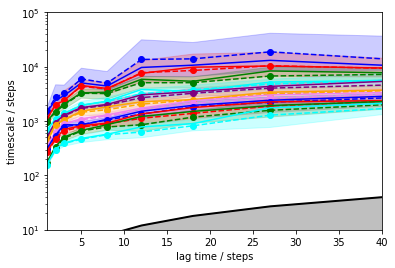

In [639]:
pyemma.plots.plot_implied_timescales(rhmmits,xlog=False)
plt.xlim((1,40))
plt.ylim((10,1e5))

In [641]:
hmm2=rhmmits.models[7]

(<Figure size 530.187x864 with 1 Axes>, array([[0.        , 0.46750443],
        [0.14372889, 0.5337547 ],
        [0.31208949, 0.43170361],
        [0.0953368 , 1.        ],
        [0.35492918, 0.25955494],
        [0.1897591 , 0.37018091],
        [0.17246626, 0.77583829],
        [0.29194276, 0.63047721],
        [0.61364279, 0.41546669],
        [0.00951373, 0.72150175],
        [0.10965684, 0.        ],
        [0.41030731, 0.68908581]]))

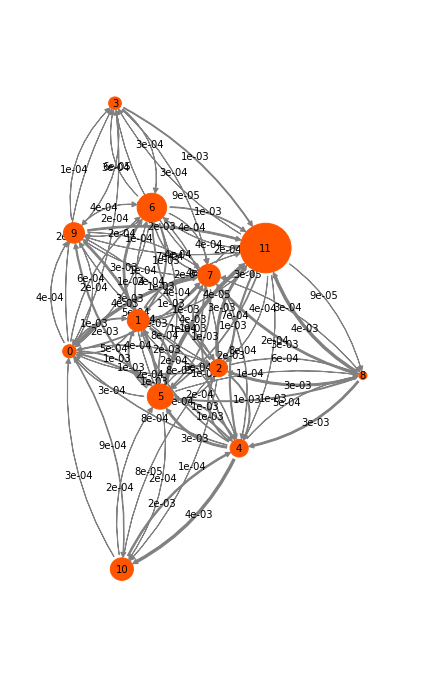

In [642]:
pyemma.plots.plot_markov_model(hmm2)

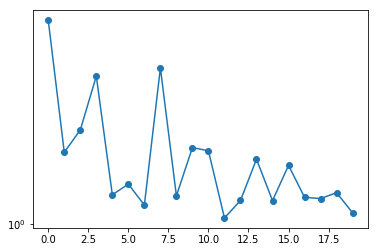

In [597]:
plt.semilogy(hmm.timescales()[:20]/hmm.timescales()[1:21], 'o-')

In [575]:
hmm.timescales()[:20]

array([24366.64435616,  6629.06906615,  5464.81050978,  4738.69394451,
        4383.96803024,  2763.98807688,  2446.90650652,  1795.70084554,
        1619.61380879])

In [643]:
ckt=hmm.cktest()

/Users/solsson/miniconda3/lib/python3.6/site-packages/pyemma/util/statistics.py:60: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')
/Users/solsson/miniconda3/lib/python3.6/site-packages/msmtools/analysis/dense/decomposition.py:388: RuntimeWarning: divide by zero encountered in true_divide
  R = R / np.sqrt(s[np.newaxis, :])
/Users/solsson/miniconda3/lib/python3.6/site-packages/msmtools/analysis/dense/decomposition.py:388: RuntimeWarning: invalid value encountered in true_divide
  R = R / np.sqrt(s[np.newaxis, :])
/Users/solsson/miniconda3/lib/python3.6/site-packages/msmtools/analysis/dense/decomposition.py:389: RuntimeWarning: invalid value encountered in true_divide
  L = L / np.sqrt(s[np.newaxis, :])
/Users/solsson/miniconda3/lib/python3.6/site-packages/msmtools/analysis/dense/decomposition.py:388: RuntimeWarning: invalid value encountered in sqrt
  R = R / np.sqrt(s[np.newaxis, :])
/Users

(<Figure size 720x540 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1ac27fbcf8>,
       dtype=object))

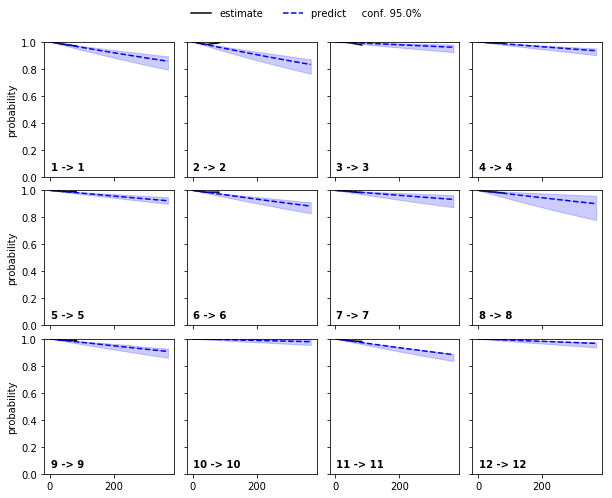

In [644]:
pyemma.plots.plot_cktest(ckt,diag=True)

In [546]:
pcca = hmm.pcca(10)

In [547]:
PCCTM=np.maximum(pcca.coarse_grained_transition_matrix, 0)
PCCTM = PCCTM/PCCTM.sum(axis=1)

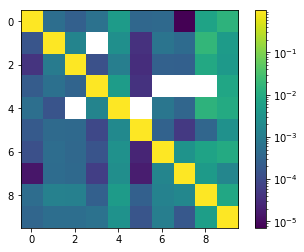

In [548]:
plt.imshow(PCCTM, norm=mpl.colors.LogNorm());plt.colorbar()

In [549]:
PCCTM

array([[9.71488040e-01, 5.06129508e-04, 2.70120608e-04, 6.03495187e-04,
        4.78613523e-03, 3.69301745e-04, 4.09197563e-04, 7.06590873e-06,
        6.72369415e-03, 1.48356448e-02],
       [1.58498631e-04, 9.71727488e-01, 1.48399816e-03, 0.00000000e+00,
        2.55850330e-03, 3.87728324e-05, 6.69776749e-04, 4.50836454e-04,
        1.82697370e-02, 4.64294617e-03],
       [4.15771745e-05, 9.95184005e-04, 9.84217160e-01, 1.36162409e-04,
        1.11147881e-03, 3.32364058e-05, 2.81218156e-04, 2.62996067e-04,
        8.88124187e-03, 4.03945029e-03],
       [2.24129062e-04, 5.52019502e-04, 3.20144380e-04, 9.85971756e-01,
        4.90319631e-03, 4.05039539e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.00205666e-03],
       [5.45736923e-04, 1.56583034e-04, 0.00000000e+00, 1.45747046e-03,
        9.71373808e-01, 0.00000000e+00, 7.28787652e-04, 3.52593180e-04,
        1.53557989e-02, 1.00309630e-02],
       [2.03937730e-04, 4.19632802e-04, 4.13252852e-04, 9.15939029e-05,
   

(<Figure size 864x354.268 with 1 Axes>, array([[0.40101775, 0.25916124],
        [0.60000478, 0.1502764 ],
        [0.54555091, 0.        ],
        [1.        , 0.34743629],
        [0.44404438, 0.10120789],
        [0.42057713, 0.41003186],
        [0.26751181, 0.01566928],
        [0.        , 0.03645398],
        [0.19874181, 0.24249687],
        [0.55570109, 0.30403619]]))

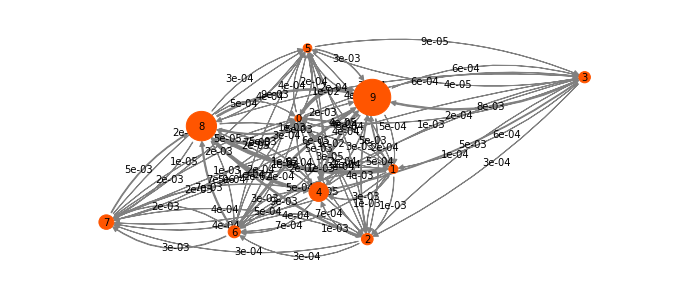

In [550]:
pyemma.plots.plot_network(PCCTM, state_sizes=pcca.coarse_grained_stationary_probability)

(<Figure size 498.065x864 with 1 Axes>, array([[0.        , 0.38551426],
        [0.37416821, 0.51734393],
        [0.37990612, 1.        ],
        [0.20942758, 0.60073606],
        [0.19203372, 0.42212884],
        [0.16719502, 0.        ],
        [0.35523181, 0.30150001],
        [0.57646464, 0.27217255],
        [0.19554179, 0.19315949],
        [0.24986394, 0.75876345]]))

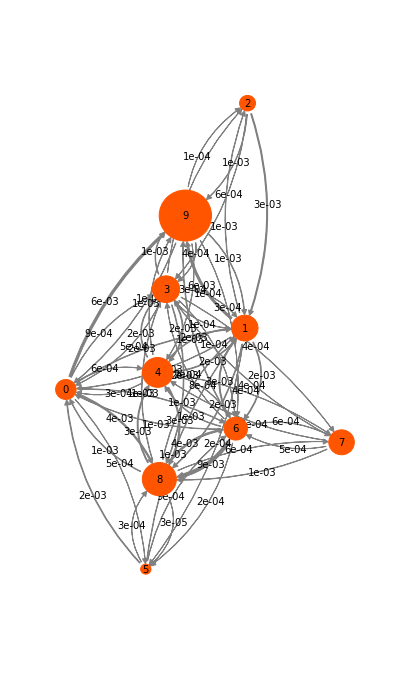

In [567]:
pyemma.plots.plot_markov_model(hmm)

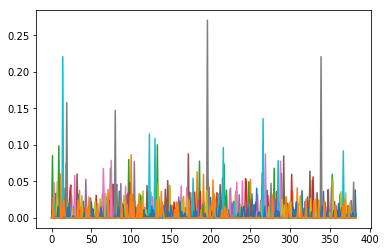

In [645]:
plt.plot(hmm.metastable_distributions.T)

In [646]:
dcat=np.concatenate(wdat)

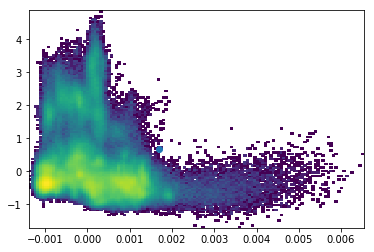

In [647]:
plt.hist2d(dcat[:,1],dcat[:,3],bins=128,norm=mpl.colors.LogNorm())
plt.scatter(km.cluster_centers_[:,1],km.cluster_centers_[:,3])

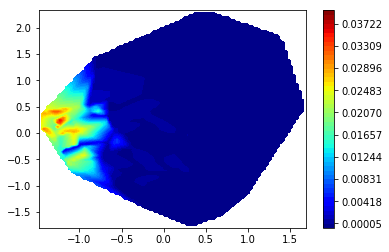

In [648]:
pyemma.plots.contour(km.cluster_centers_[:,1],km.cluster_centers_[:,3],hmm.metastable_distributions[-1])

In [45]:
def avg_by_state(ftrajs, dtrajs):
    dtc = np.concatenate(dtrajs)
    ftc = np.concatenate(ftrajs)
    dstates = np.unique(dtc)
    return [ftc[np.where(dtc==d)].mean(axis=0) for d in dstates]

In [651]:
dtc = np.concatenate(dtred[:])
ftc = np.concatenate(rmsds_selected[:])
dstates = np.unique(dtc)

In [652]:
[np.array([ftc[dtc==d].mean(axis=0) for d in dstates]).dot(msd) for msd in hmm.metastable_distributions]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1513893 but corresponding boolean dimension is 1545759

In [572]:
[np.array([ftc[dtc==d].min(axis=0) for d in dstates]).dot(msd) for msd in hmm.metastable_distributions]

[0.4255178310098076,
 0.42864577657304237,
 0.48121382349797326,
 0.5256483589230012,
 0.6834045905877071,
 0.46834818324245125,
 0.7010539916815675,
 0.7330487953769158,
 0.7741717849109839,
 0.2669498762155862]

In [232]:
ftc[np.where(dtc==0)].mean(axis=0)

1.5670742

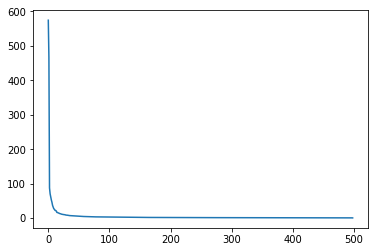

In [268]:
plt.plot(hmm.timescales())

In [846]:
np.where(["GROUP_MINDIST" in f for f in feat.describe()])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104]),)

In [854]:
[np.any(d[:104]<0.4, axis=1) for d in data]

[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  Tr

In [591]:
data[0].shape

(213, 3)

In [790]:
dtrajs_fixed_batches = np.array_split(np.random.permutation(dtrajs_fixed), 5)

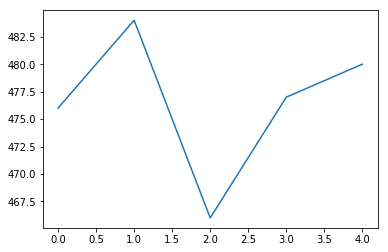

In [791]:
plt.plot([len(set(np.concatenate(dtb))) for dtb in dtrajs_fixed_batches])

In [792]:
bootstrap = [pyemma.msm.estimate_markov_model(dt.tolist(), lag=90) for dt in dtrajs_fixed_batches]

In [793]:
import msmtools


In [794]:
msmtools.util.statistics.confidence_interval(np.vstack([b.timescales()[:10] for b in bootstrap]))

(array([6531.73986595, 4483.35196979, 3795.66602537, 3454.69527092,
        2546.53040354, 2322.84576375, 2181.79202487, 1880.45223444,
        1676.11466943, 1585.48811767]),
 array([18527.10742689,  8003.21450235,  5788.72020954,  4926.5588091 ,
         3881.01727692,  2777.16458499,  2615.15247077,  2276.47776653,
         2199.44578524,  1995.09037105]))

In [ ]:
chemshift_order = ['hn','n','ca', 'cb', 'ha', 'co']

In [802]:
cs_=np.array_split(np.loadtxt('state_000490_camshift.cs'), 6, axis=1)

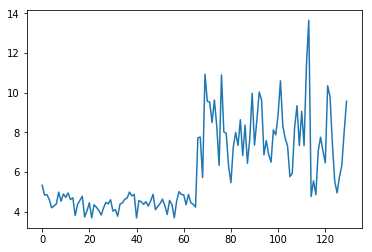

In [816]:
plt.plot([c.mean(axis=0)[np.where(c.mean(axis=0)<100)] for c in cs_][-2])

In [1848]:
def load_camshift(fn, no_time = True):
    with open(fn, 'r') as f:
        for i,f in enumerate(f.readlines()):
            if i==0:
                fields = [field for field in f.split() if field not in ["#!", "FIELDS"] ]
    data = np.loadtxt(fn)
    if no_time == False:
        time = data[:, 0].copy()
    data = data[:, [i for i,s in enumerate(fields) if s != 'time']]
    fields = [s for s in fields if s != 'time']
    if no_time:
        return fields, data
    else:
        return fields, data, time



In [1850]:
fields, djnata = load_camshift("msm_{:06d}_camshift.cs".format(400) , no_time=True)

In [1851]:

state_cs = []
for i,a in enumerate(model.active_set):
    state_cs.append(load_camshift("msm_{:06d}_camshift.cs".format(i) , no_time=True)[-1].mean(axis=0))

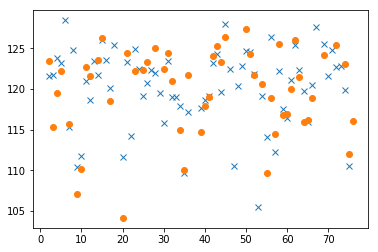

In [1852]:
plt.plot([int(f_.split('_')[-1])+1 for f_ in  np.array(fields)[[i for i,f in enumerate(fields) if "nh" in f]].tolist()][:70], model.stationary_distribution.dot(np.array(state_cs))[[i for i,f in enumerate(fields) if "nh" in f][:70]],'x')
plt.plot(np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,0],np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,-1:],'o')

In [1853]:
state_cs=np.array(state_cs)

In [1855]:
np.__version__

'1.14.2'

In [1865]:
ridx_exp = np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,0].astype(int)
ridx_camshift = np.array([int(f_.split('_')[-1])+1 for f_ in  np.array(fields)[[i for i,f in enumerate(fields) if "nh" in f]].tolist()][:70])
reindex_camshift = np.isin(ridx_camshift, ridx_exp)
reindex_exp = np.isin(ridx_exp,ridx_camshift)
obs_both = ridx_camshift[reindex_camshift]
#obs_both,reindex_camshift,reindex_exp = np.intersect1d(ridx_camshift,ridx_exp, return_indices=True)


In [1866]:
(np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,-1][reindex_exp]-model.stationary_distribution.dot(np.array(state_cs))[[i for i,f in enumerate(fields) if "nh" in f][:70]][reindex_camshift]).std()


2.920816829602947

In [1867]:

joint_obs=list(set([int(f_.split('_')[-1])+1 for f_ in  np.array(fields)[[i for i,f in enumerate(fields) if "nh" in f]].tolist()][:70]).intersection(np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,0].astype(int)))

In [1868]:
np.array([int(f_.split('_')[-1])+1 for f_ in  np.array(fields)[[i for i,f in enumerate(fields) if "nh" in f]].tolist()][:70])

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73,
       74, 75])

In [1869]:
def weighed_variance(data, weights, return_mean=False):
    """
        data: KxL
        weights: K
    """
    weighed_mean = weights.dot(data).reshape(1, -1)
    weighed_variance = weights.dot((data - weighed_mean)**2)
    if return_mean:
        return weighed_variance, weighed_mean
    else:
        return weighed_variance

In [1870]:
CS_sim=np.array(state_cs)[:,[i for i,f in enumerate(fields) if "nh" in f][:70]][:,reindex_camshift]

In [3425]:
CS_sim.shape

(641, 51)

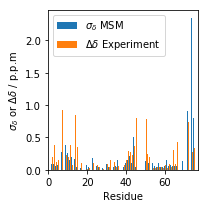

In [2989]:
fig,ax=plt.subplots(ncols=1, figsize=(3,3))
ax.bar(ridx_camshift[reindex_camshift]-0.25,weighed_variance(np.array(state_cs)[:,[i for i,f in enumerate(fields) if "nh" in f][:70]][:,reindex_camshift], model.stationary_distribution), width=0.5, label=r"$\sigma_{\delta}$ MSM")
ax.bar(ridx_exp[reindex_exp]+0.25, np.abs(np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,1][reindex_exp]-np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,-1][reindex_exp]), width=0.5, label=r"$\Delta\delta$ Experiment" )
ax.legend()
ax.set_xlabel('Residue')
ax.set_ylabel(r'$\sigma_{\delta}$ or $\Delta\delta$ / p.p.m')
ax.set_xlim(0,77)
fig.tight_layout()
fig.savefig('taerte2.pdf')

np.std(model.stationary_distribution.dot(np.array(state_cs)[:,[i for i,f in enumerate(fields) if "nh" in f][:70]][:,reindex_camshift])-np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,-4][reindex_exp]) 

In [2174]:
def p_associated(conc, k, saturation_conc=1994.334288806385):
    probs = 1-1./(1+np.exp(-k/(conc-saturation_conc)))
    return 2*(probs-0.5)

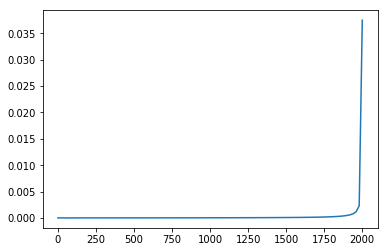

In [2175]:
plt.plot(np.linspace(0,2000,100), p_associated(np.linspace(0,1993,100), 0.1))

(507139, 70)

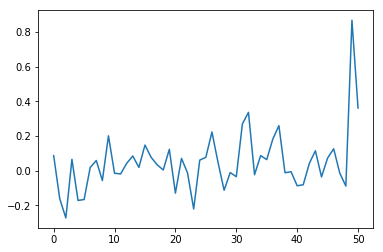

In [1995]:
unbound_density = model.stationary_distribution [np.array(state_avg_cc[reindex_obs_set])>1.]#+1
unbound_density /= unbound_density.sum()
plt.plot(unbound_density.dot(
    np.array(state_cs)[np.array(state_avg_cc[reindex_obs_set])>1.][:,[i for i,f in enumerate(fields) if "nh" in f][:70]][:,reindex_camshift])-model.stationary_distribution.dot(np.array(state_cs)[:,[i for i,f in enumerate(fields) if "nh" in f][:70]][:,reindex_camshift]))

In [2100]:
titration_data= np.loadtxt("data_from_Kalyan/TITR_15N_7C_ED.txt")

In [2122]:
conc_data_=titration_data[0, 1:]
cs_data_=titration_data[1:, 1:][reindex_exp]

Standardize CS titrations

In [2128]:
cs_data_mf = cs_data_-cs_data_.mean(axis=1,keepdims=True)
cs_data_std = cs_data_mf/cs_data_mf.std(axis=1, keepdims=True)

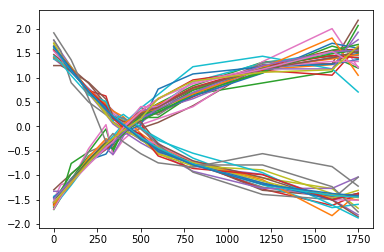

In [2131]:
plt.plot(conc_data_,cs_data_std.T);

Transform basis shifts to standardized scale

In [2214]:
n_cs_unbound = np.load("ubq_only_cs.npy")[:,reindex_camshift].mean(axis=0)#-cs_data_.mean(axis=1)
n_cs_unbound_std = n_cs_unbound#/cs_data_mf.std(axis=1)
n_cs_bound = model.stationary_distribution.dot(np.array(state_cs)[:,[i for i,f in enumerate(fields) if "nh" in f][:70]][:,reindex_camshift])#-cs_data_.mean(axis=1)
n_cs_bound_std = n_cs_bound#/cs_data_mf.std(axis=1)


In [2215]:
n_cs_unbound_std

array([121.60977578, 121.61733963, 123.74027095, 123.08868081,
       115.18811229, 110.39785704, 111.78607125, 121.02741167,
       118.54587673, 121.69573148, 125.93724707, 120.16085086,
       111.67919338, 123.32485381, 124.88705799, 119.24693738,
       120.72869313, 121.99203223, 115.709968  , 123.40906121,
       118.99467588, 117.89483546, 109.61271774, 117.05518135,
       117.61237523, 118.75602021, 119.37391669, 123.34910921,
       124.1837186 , 119.33974699, 127.97083063, 124.74248582,
       125.06388761, 121.78128409, 119.22676391, 114.1121627 ,
       126.36535516, 112.33845513, 122.18681087, 117.59624991,
       116.38317055, 121.09777114, 125.49782271, 122.39469035,
       119.7867089 , 115.93539423, 120.60952706, 125.42861013,
       122.78632897, 120.78857681, 111.00559389])

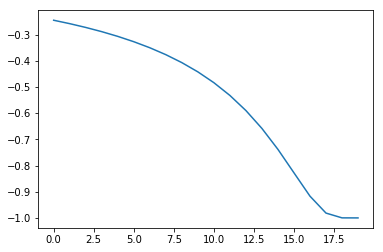

In [2216]:
plt.plot(p_associated(np.linspace(0,1990,20).reshape(-1,1), -k))

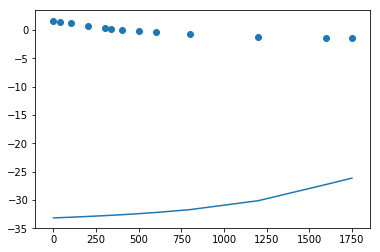

In [2236]:
k=1000
titration = p_associated(conc_data_.reshape(-1,1), k)*n_cs_unbound_std[-2]+(1-p_associated(conc_data_.reshape(-1,1), k))*n_cs_bound_std[-2]

plt.plot(conc_data_,(titration.reshape(-1)-cs_data_.mean(axis=1)[-2])/cs_data_.std(axis=1)[-2] );
plt.scatter(conc_data_,cs_data_std[-2]);

In [2234]:
n_cs_unbound_std-n_cs_bound_std

array([ 0.00092414, -0.05602246, -0.0632018 , -0.11376198, -0.17993219,
       -0.03714342,  0.09138643, -0.00162401, -0.07330924, -0.00818362,
       -0.02715114,  0.02301004,  0.00744759, -0.02175997,  0.01086932,
        0.11383989, -0.0152722 ,  0.01242614, -0.05133845,  0.0258366 ,
       -0.02510515,  0.00155727,  0.00384493, -0.0830692 ,  0.00676402,
        0.08454557,  0.22068987,  0.20477913, -0.0753838 , -0.27147122,
       -0.02694493,  0.04704356,  0.49779445, -0.08779849,  0.04278845,
        0.04322003,  0.00980473,  0.04152569, -0.01266625,  0.03642328,
       -0.01008719,  0.04025838,  0.03728394,  0.01128349,  0.00766419,
        0.00822077,  0.07701634, -0.06379257,  0.09589107,  0.88986405,
        0.50313953])

<BarContainer object of 70 artists>

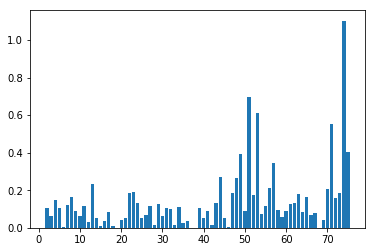

In [3441]:
plt.bar(ridx_camshift[:], np.abs(np.array(state_cs)[np.array(state_avg_cc[reindex_obs_set])>1.5][:,[i for i,f in enumerate(fields) if "nh" in f][:70]].mean(axis=0) 
        -np.array(state_cs)[np.array(state_avg_cc[reindex_obs_set])<0.5][:,[i for i,f in enumerate(fields) if "nh" in f][:70]].mean(axis=0)))#.shape

In [2004]:
state_avg_rmsds[reindex_obs_set]

array([1.0650139 , 0.36319593, 0.591328  , 0.55758554, 1.0672832 ,
       0.46110845, 0.65942365, 1.2797155 , 0.7716346 , 0.9146975 ,
       0.68339646, 0.63827467, 1.2406489 , 0.7695824 , 1.6728466 ,
       0.65575826, 0.9928273 , 0.32963443, 0.97849095, 0.40128067,
       0.36598927, 0.6005411 , 0.791176  , 0.5968132 , 0.695487  ,
       0.83497936, 0.79780614, 0.55190396, 0.68269545, 1.333005  ,
       0.3990832 , 0.5090518 , 1.1555383 , 0.74188286, 0.37644023,
       1.2580413 , 0.9315916 , 0.734897  , 0.64323217, 0.99764884,
       0.3650743 , 0.35800415, 0.5207925 , 1.072614  , 0.5784425 ,
       1.0189801 , 0.35040006, 1.0971527 , 1.2230465 , 0.6901244 ,
       1.1762794 , 1.0040841 , 0.6216832 , 0.2696073 , 0.42264688,
       0.9769001 , 1.2666496 , 0.52382886, 1.6799502 , 0.35486427,
       1.1139964 , 0.6401891 , 0.6861749 , 0.6327396 , 0.27411732,
       1.2749761 , 0.96527624, 1.2603886 , 0.48353952, 1.0403154 ,
       0.47837797, 0.39138412, 1.1547858 , 1.0566298 , 0.56764

In [2002]:
model.sample_by_state(10,[0])[0]

array([[ 862, 1032],
       [ 862,  835],
       [  55, 1027],
       [  50, 1257],
       [ 330,   72],
       [  55, 1289],
       [  55, 1280],
       [  55,  933],
       [ 862,  841],
       [ 862, 1017]])

In [3285]:
def PHI_EX(fingerprint):
    return np.dot(fingerprint[0][1:], 1e-3*fingerprint[1][1:])


In [3286]:
phi_ex=[PHI_EX(model.fingerprint_correlation(CS_sim[:,i])) for i in range(CS_sim.shape[1])]

In [1875]:
jointly_observed_hn=np.array(state_cs)[:,[i for i,f in enumerate(fields) if "nh" in f][:70]][:,reindex_camshift]

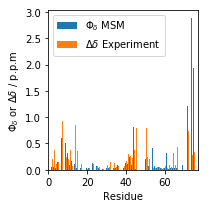

In [3387]:
#plt.plot(ridx_camshift[reindex_camshift],jointly_observed_hn.var(axis=0),'o')
fig, ax = plt.subplots(1, figsize=(3,3))
plt.bar(ridx_camshift[reindex_camshift]-0.25,np.array(phi_ex), width=0.5, label=r"$\Phi_{\delta}$ MSM")
plt.bar(ridx_exp[reindex_exp]+0.25, np.abs(np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,1][reindex_exp]-np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,-1][reindex_exp]), width=0.5, label=r"$\Delta\delta$ Experiment" )
ax.legend()
ax.set_xlabel('Residue')
ax.set_ylabel(r'$\Phi_{\delta}$ or $\Delta\delta$ / p.p.m')
ax.set_xlim(0,77)
fig.tight_layout()
fig.savefig('taerte2.pdf')

(0, 1)

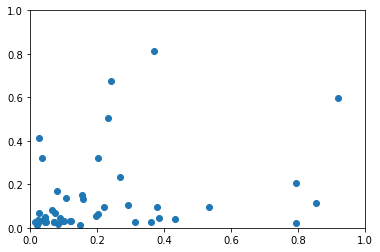

In [3391]:
plt.scatter(np.abs(np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,1][reindex_exp]-np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,-1][reindex_exp]),np.array(phi_ex)) 
plt.xlim(0,1)
plt.ylim(0,1)

In [3394]:
np.corrcoef(np.abs(np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,1][reindex_exp]-np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,-1][reindex_exp]),np.array(phi_ex))

array([[1.        , 0.24943868],
       [0.24943868, 1.        ]])

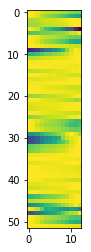

In [1884]:
plt.imshow(np.loadtxt('data_from_Kalyan/TITR_15N_7C_ED.txt')[1:,1:]/np.loadtxt('data_from_Kalyan/TITR_15N_7C_ED.txt')[1:,1:].max(axis=1, keepdims=True))

In [1885]:
np.loadtxt('data_from_Kalyan/TITR_15N_7C_ED.txt')[0]

array([   0.,    0.,   40.,  100.,  200.,  300.,  340.,  400.,  500.,
        600.,  800., 1200., 1600., 1750.])

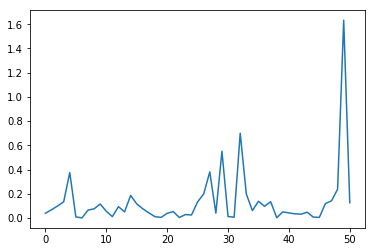

In [1158]:
plt.plot(np.abs(jointly_observed_hn[cgem.argmax(axis=0)==12,:].T.dot(model.stationary_distribution[cgem.argmax(axis=0)==12]/model.stationary_distribution[cgem.argmax(axis=0)==12].sum())-jointly_observed_hn[cgem.argmax(axis=0)==13,:].T.dot(model.stationary_distribution[cgem.argmax(axis=0)==13]/model.stationary_distribution[cgem.argmax(axis=0)==13].sum())))

16-12-18 16:30:48 matplotlib.legend WARNING  No handles with labels found to put in legend.


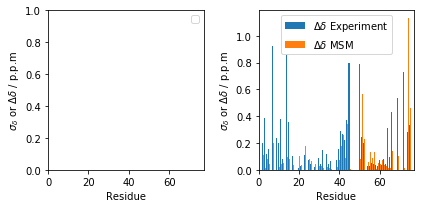

In [1161]:
fig,ax=plt.subplots(ncols=2, figsize=(6,3))
#ax[0].bar(ridx_camshift[reindex_camshift]-0.25,weighed_variance(np.array(state_cs)[:,[i for i,f in enumerate(fields) if "nh" in f][:70]][:,reindex_camshift], model.stationary_distribution)**0.5, width=0.5, label=r"$\sigma_{\delta}$ MSM")
#ax[0].bar(ridx_camshift[reindex_camshift]+0.25,phi_ex, width=0.5, label=r"$\Phi_{\mathrm{ex}}$ MSM")
ax[1].bar(ridx_exp[reindex_exp]-0.250, np.abs(np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,1][reindex_exp]-np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,-1][reindex_exp]), width=0.5, label=r"$\Delta\delta$ Experiment" )
ax[1].bar(ridx_camshift[reindex_camshift]+0.250, np.abs(jointly_observed_hn[:,:].T.dot(model.stationary_distribution)-jointly_observed_hn[cgem.argmax(axis=0)==13,:].T.dot(model.stationary_distribution[cgem.argmax(axis=0)==13]/model.stationary_distribution[cgem.argmax(axis=0)==13].sum())), width=0.5, label=r"$\Delta\delta$ MSM" )

ax[0].legend()
ax[0].set_xlabel('Residue')
ax[0].set_ylabel(r'$\sigma_{\delta}$ or $\Delta\delta$ / p.p.m')
ax[0].set_xlim(0,77)

ax[1].legend()
ax[1].set_xlabel('Residue')
ax[1].set_ylabel(r'$\sigma_{\delta}$ or $\Delta\delta$ / p.p.m')
ax[1].set_xlim(0,77)
fig.tight_layout()
fig.savefig('taerte2.pdf')

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
        True, False,  True, False, False, False, False, False,  True,
        True, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False,  True, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [923]:
model.timescales()

array([7031.33069035, 5153.00895119, 2693.6529311 , 2268.14036122,
       2159.59621061, 1747.76122549, 1511.11978338, 1385.7905866 ,
       1246.59825421, 1152.3623857 , 1078.39518233, 1047.92425504,
        899.56258589,  877.06778489,  856.59480502,  809.00829317,
        739.54932275,  707.38000814,  674.51324356,  659.51278823,
        631.76940041,  575.92596156,  551.901079  ,  541.18510577,
        522.59370832,  489.40898204,  466.75738015,  456.46997279,
        449.08885577,  413.4924026 ,  410.22311606,  393.75322607,
        388.99655494,  367.27460452,  361.63017375,  359.8383531 ,
        357.82500711,  337.86811976,  334.22181715,  315.31938623,
        304.8372486 ,  300.5012048 ,  298.65108608,  293.38983519,
        284.49722956,  283.50713553,  263.9140419 ,  262.66558808,
        259.16008385,  251.40700135,  246.97309859,  241.56531066,
        240.25112436,  237.07332105,  229.15016721,  226.03862281,
        222.99272724,  219.27018034,  217.16634093,  215.71857

In [1341]:
model.stationary_distribution[450:]/model.stationary_distribution[450:].sum()

array([0.13672808, 0.27692502, 0.010355  , 0.17742948, 0.04870728,
       0.03163947, 0.21102455, 0.00525979, 0.07605511, 0.02587623])

In [1021]:
cs_dmat=((np.array(state_cs)[:,:].T-np.array(state_cs)[:,:,None])**2).sum(axis=1)

In [1022]:
s,v,d = np.linalg.svd(cs_dmat)

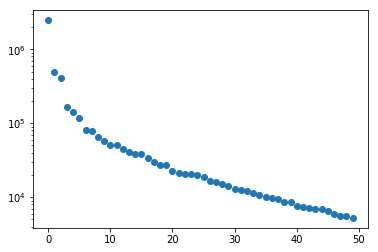

In [1027]:
plt.semilogy(v[:50],'o')

In [75]:
from sklearn.cluster import k_means

In [76]:
kmcenters_, kmassignments_, junk =  k_means(np.array(state_cs), 16)

In [77]:
np.unique(kmassignments_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32),
 array([ 8, 83, 37, 27, 12, 54,  9,  3, 44,  1, 41, 80, 28, 26, 30,  9]))

In [987]:
np.abs(np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,1][reindex_exp]-np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,-1][reindex_exp])

array([0.198, 0.385, 0.118, 0.154, 0.921, 0.234, 0.203, 0.378, 0.081,
       0.854, 0.36 , 0.102, 0.016, 0.025, 0.107, 0.073, 0.044, 0.02 ,
       0.089, 0.044, 0.15 , 0.121, 0.045, 0.065, 0.072, 0.158, 0.292,
       0.27 , 0.222, 0.37 , 0.794, 0.793, 0.242, 0.202, 0.026, 0.027,
       0.049, 0.046, 0.039, 0.025, 0.07 , 0.035, 0.083, 0.046, 0.312,
       0.095, 0.433, 0.533, 0.733, 0.279, 0.338])

In [982]:
np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,-1][reindex_exp]

array([123.386, 115.267, 119.513, 122.149, 115.642, 107.122, 110.137,
       122.653, 121.651, 123.502, 126.314, 118.508, 104.136, 124.463,
       122.199, 122.38 , 123.327, 125.061, 122.458, 124.432, 120.975,
       114.984, 110.031, 121.664, 114.707, 117.933, 118.996, 124.084,
       125.276, 123.267, 126.341, 127.378, 124.325, 121.658, 120.584,
       109.647, 118.899, 114.455, 125.534, 116.816, 116.883, 120.001,
       126.007, 121.495, 115.893, 116.186, 118.853, 124.125, 125.414,
       123.018, 111.952])

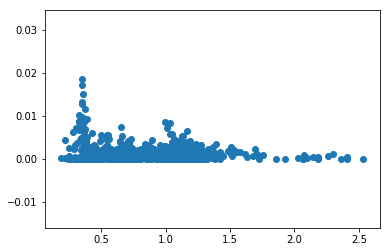

In [354]:
plt.scatter(np.array(state_avg_rmsd)[reindex_obs_set], model.stationary_distribution)

/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


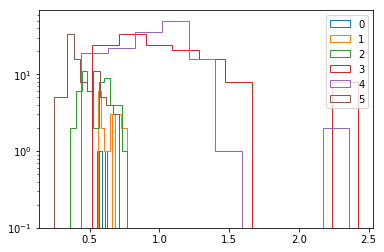

In [917]:
for i in range(model.n_metastable):
    plt.hist([state_avg_rmsd[model.active_set[i]] for i in np.where(model.metastable_assignments==i)[0]],log=True, histtype='step', normed=False, label=f"{i}")
plt.legend()

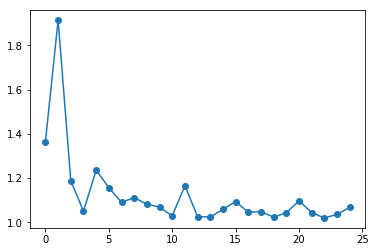

In [996]:
plt.plot(model.timescales()[:25]/model.timescales()[1:26], '-o')

In [48]:
pcca13 = model.pcca(13)

(<Figure size 864x511.119 with 1 Axes>, array([[1.        , 0.38107736],
        [0.18066572, 0.48002461],
        [0.        , 0.38998059],
        [0.48295904, 0.23352851],
        [0.58722467, 0.37102786],
        [0.36785911, 0.14519958],
        [0.14076911, 0.        ],
        [0.38672761, 0.3726353 ],
        [0.52957247, 0.59157258],
        [0.81232653, 0.24654336],
        [0.33137855, 0.5035263 ],
        [0.60085802, 0.11043875],
        [0.16263062, 0.21986361]]))

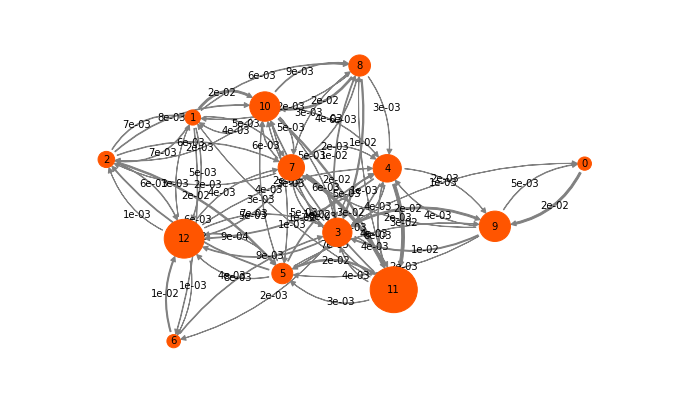

In [999]:
pyemma.plots.plot_markov_model(full_PCCA_TM, minflux=1e-4)

array([2, 5, 4, 3, 4, 3, 2, 5, 1, 4, 2, 3, 4, 3, 5, 0, 1, 4, 5, 3, 4, 2,
       3, 3, 4, 3, 4, 5, 3, 4, 3, 1, 4, 2, 3, 3, 4, 5, 4, 3, 2, 5, 1, 1,
       4, 4, 5, 1, 3, 5, 4, 4, 4, 2, 5, 4, 0, 5, 4, 3, 4, 5, 4, 5, 3, 5,
       2, 3, 4, 4, 3, 5, 5, 4, 5, 2, 5, 4, 4, 4, 2, 3, 3, 3, 3, 3, 2, 0,
       4, 3, 4, 4, 5, 4, 5, 5, 3, 1, 5, 3, 5, 3, 4, 3, 4, 2, 4, 3, 2, 4,
       3, 3, 4, 4, 4, 4, 5, 3, 2, 1, 3, 3, 3, 4, 4, 4, 5, 2, 5, 3, 4, 5,
       4, 3, 4, 2, 1, 4, 2, 5, 4, 4, 5, 4, 3, 3, 3, 4, 2, 4, 3, 5, 5, 5,
       4, 4, 2, 4, 3, 3, 3, 3, 5, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 4, 5, 5,
       4, 1, 3, 4, 3, 5, 4, 3, 2, 5, 4, 3, 2, 5, 3, 3, 3, 4, 4, 5, 4, 1,
       5, 4, 3, 4, 4, 3, 5, 3, 4, 4, 2, 5, 1, 1, 5, 3, 2, 0, 2, 4, 3, 3,
       1, 2, 3, 4, 4, 5, 5, 4, 1, 5, 4, 3, 4, 5, 4, 1, 3, 4, 3, 4, 3, 3,
       3, 5, 4, 5, 4, 4, 5, 2, 3, 5, 5, 3, 2, 3, 5, 4, 4, 3, 4, 2, 4, 2,
       2, 4, 3, 5, 3, 4, 3, 4, 5, 4, 4, 1, 3, 2, 4, 5, 5, 5, 5, 5, 4, 4,
       4, 3, 5, 3, 4, 4, 5, 3, 5, 4, 0, 4, 2, 3, 3,

In [349]:
crmsds = np.concatenate(rmsds)

In [350]:
for i in range(model.n_metastable):
    k=plt.hist(crmsds[model.metastable_assignments[dtc]==i],bins=128, normed=True, histtype='step')

IndexError: index 836 is out of bounds for axis 0 with size 674

In [998]:
full_PCCA_TM=np.maximum(pcca13.coarse_grained_transition_matrix,0)
full_PCCA_TM = full_PCCA_TM/full_PCCA_TM.sum(axis=1, keepdims=True)

In [1445]:
pcca.coarse_grained_stationary_probability.argmax()

9

/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


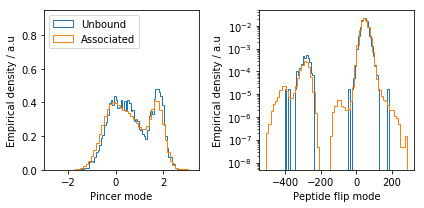

In [196]:
fig,ax = plt.subplots(ncols=2,figsize=(6,3))
ax[0].hist(pincercat[np.concatenate(chain_contact)>1],bins=64,histtype='step',normed=True, label="Unbound")
ax[0].hist(pincercat[np.concatenate(chain_contact)<1],bins=64,histtype='step',normed=True, label="Associated")
#ax[0].hist(pincercat[model.metastable_assignments[np.concatenate(dtrajs_fixed)]==9],bins=64,histtype='step',normed=True, label="Bound")

#ax[0].hist(pincercat[model.metastable_assignments[np.concatenate(dtrajs_fixed)]==12],bins=64,histtype='step',normed=True, label="Low RMSD")

ax[0].set_xlabel('Pincer mode')
ax[0].set_ylabel('Empirical density / a.u')
ax[0].set_ylim((0,0.95))
ax[0].set_xlim((-3,3.5))

ax[0].legend(loc='upper left')
ax[1].hist(pflipcat[np.concatenate(chain_contact)>1],bins=64,histtype='step',normed=True)
ax[1].hist(pflipcat[np.concatenate(chain_contact)<1],bins=64,histtype='step',normed=True,log=True)
#ax[1].hist(pflipcat[model.metastable_assignments[np.concatenate(dtrajs_fixed)]==9],bins=64,histtype='step',normed=True, label="Bound")

#ax[1].hist(pflipcat[model.metastable_assignments[np.concatenate(dtrajs_fixed)]==12],bins=64,histtype='step',normed=True, label="Low RMSD")

ax[1].set_xlabel('Peptide flip mode')
ax[1].set_ylabel('Empirical density / a.u')
fig.tight_layout()
fig.savefig('gmodes_empirical.pdf')

In [482]:
dtc = np.concatenate(dtrajs_fixed)
ftc = np.concatenate(npinc)
state_avg_pinc = np.array([ftc[dtc==i].mean() for i in range(km0.n_clusters+2)])

In [483]:
dtc = np.concatenate(dtrajs_fixed)
ftc = np.concatenate(npepf)
state_avg_pf = np.array([ftc[dtc==i].mean() for i in range(km0.n_clusters+2)])

In [182]:
pcca.memberships[0]

array([0.01783065, 0.00778027, 0.00058499, 0.03225952, 0.01487346,
       0.03954376, 0.01038274, 0.01525894, 0.02182422, 0.01183111,
       0.00421938, 0.0613144 , 0.08143092, 0.12521275, 0.55565288])

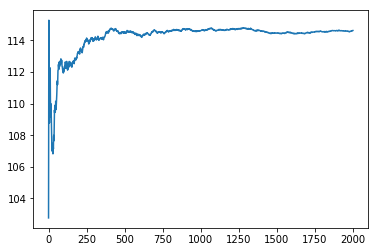

In [272]:
plt.plot((djnata.cumsum(axis=0)/np.arange(1,2001).reshape(-1,1))[:,-1])

In [202]:
__ft=model.simulate(5000,start=491)

IndexError: index 491 is out of bounds for axis 0 with size 454

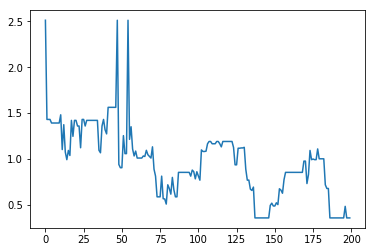

In [460]:
#plt.plot(state_cs[__ft[:200], :][:,[i for i,f in enumerate(fields) if "hn" in f][41:44]])
#plt.plot(state_cs[__ft[:200], :][:,[i for i,f in enumerate(fields) if "hn" in f][7:10]])

plt.plot(np.array(state_avg_rmsd)[model.active_set][__ft[:200]])

In [203]:
plt.plot(state_cs[__ft[:200], :][:,[i for i,f in enumerate(fields) if "hn" in f][65:69]])


NameError: name 'state_cs' is not defined

In [204]:
jdhfks=plt.hist(np.concatenate(npinc), bins=128, normed=True)
plt.vlines(state_avg_pinc[model.active_set], 0,0.5,lw=0.1)

NameError: name 'npinc' is not defined

In [549]:
jdhfks=plt.hist(np.concatenate(npepf), bins=128, normed=True, log=True)
plt.vlines(state_avg_pf[model.active_set], 0,0.02,lw=0.1)

NameError: name 'npepf' is not defined

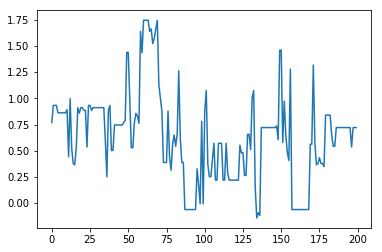

In [461]:
plt.plot(state_avg_pinc[model.active_set][__ft[:200]])

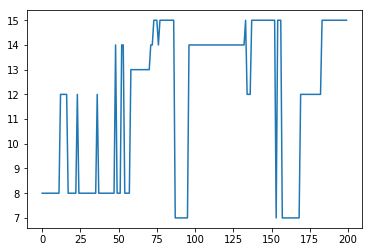

In [363]:
plt.plot(pcca2.metastable_assignment[__ft[:200]])

In [364]:
sampled_states=model.sample_by_distributions(model.metastable_distributions, 2000)
pyemma.coordinates.save_trajs(source, sampled_states, fmt='xtc',prefix="metastable_")

/Users/solsson/miniconda3/lib/python3.6/site-packages/pyemma/coordinates/data/fragmented_trajectory_reader.py:195: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ra = self.ra_indices[frag_inds] - offset


['metastable_000000.xtc',
 'metastable_000001.xtc',
 'metastable_000002.xtc',
 'metastable_000003.xtc',
 'metastable_000004.xtc',
 'metastable_000005.xtc',
 'metastable_000006.xtc',
 'metastable_000007.xtc',
 'metastable_000008.xtc',
 'metastable_000009.xtc',
 'metastable_000010.xtc',
 'metastable_000011.xtc',
 'metastable_000012.xtc',
 'metastable_000013.xtc',
 'metastable_000014.xtc',
 'metastable_000015.xtc']

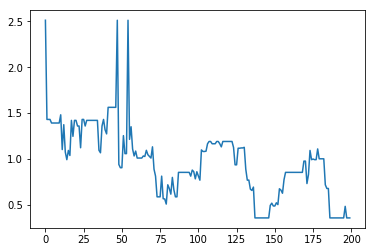

In [361]:
plt.plot(np.array(state_avg_rmsd)[model.active_set][__ft[:200]])

In [453]:
np.array(fields)[[i for i,f in enumerate(fields) if "hn" in f]][66]

'cs.hn_71'

array([  3,   6,  21,  45,  47,  59,  60,  62,  68,  85,  91, 112, 115,
       146, 155, 171, 183, 198, 206, 214, 223, 226, 242, 259, 264, 275,
       276, 278, 286, 292, 305, 306, 321, 330, 331, 342, 344, 348, 364,
       366, 375, 376, 382, 396, 403, 405, 406, 415, 421, 442, 484, 488])

(array([1., 1., 2., 2., 1., 1., 1., 0., 2., 3.]),
 array([5.7 , 5.93, 6.16, 6.39, 6.62, 6.85, 7.08, 7.31, 7.54, 7.77, 8.  ]),
 <a list of 10 Patch objects>)

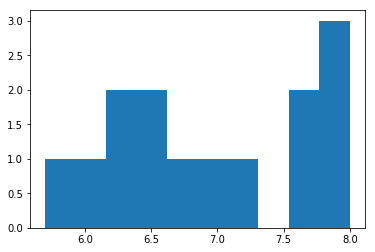

In [356]:
plt.hist(np.unique(state_cs[np.where(pcca2.metastable_assignment==12)[0],:][:,[i for i,f in enumerate(fields) if "hn" in f][42]].round(1)))

(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 1.]),
 array([7.5 , 7.55, 7.6 , 7.65, 7.7 , 7.75, 7.8 , 7.85, 7.9 , 7.95, 8.  ]),
 <a list of 10 Patch objects>)

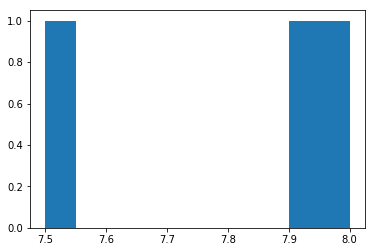

In [360]:
plt.hist(np.unique(state_cs[np.where(pcca2.metastable_assignment==7)[0],:][:,[i for i,f in enumerate(fields) if "hn" in f][42]].round(1)))

In [372]:
mtrajs = [pcca2.metastable_assignment[dt] for dt in model.discrete_trajectories_active]

In [631]:
mtc = np.concatenate(mtrajs[:])
ftc = np.concatenate(y0[:])
dstates = np.unique(dtc)
state_avg_tics = np.array([ftc[mtc==i,:].mean(axis=0) for i in range(model.n_metastable)])

NameError: name 'mtrajs' is not defined

In [543]:
np.array([state_avg_tics[i][0] for i in range(len(state_avg_tics))]).shape,np.array(state_avg_rmsd)[model.active_set].shape

((493,), (492,))

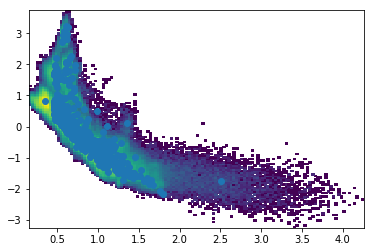

In [555]:
plt.hist2d(np.concatenate(rmsds), np.concatenate(y0)[:,0], bins=128, norm=mpl.colors.LogNorm())
plt.scatter(np.array(state_avg_rmsd)[model.active_set], 
            state_avg_tics[model.active_set,:][:,0])

In [560]:
model.mfpt(491,490)

14157.839433177642

In [813]:
rflux=pyemma.msm.tpt(model, [491],[490])

In [817]:
rflux.flux.max()

3.4482334736487046e-07

In [812]:
rflux.net_flux[:,0].sum()-rflux.net_flux[0].sum()

-1.6179193696297254e-18

In [749]:
_s,_v,_d = np.linalg.svd(np.array(committors).T)

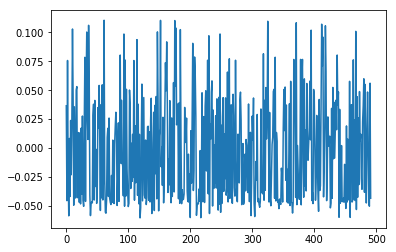

In [754]:
plt.plot(_s[:,1])

In [583]:
committors = []
for i in range(len(model.active_set)):
    if i != 490:
        rflux_=pyemma.msm.tpt(model, [i],[490])
        committors.append(rflux_.committor)#, np.array(state_avg_rmsd)[model.active_set] )


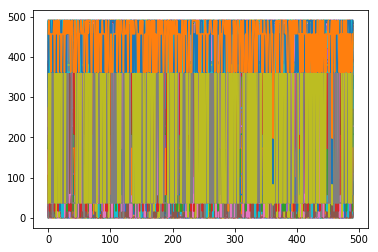

In [587]:
plt.plot(np.argsort(committors, axis=1));

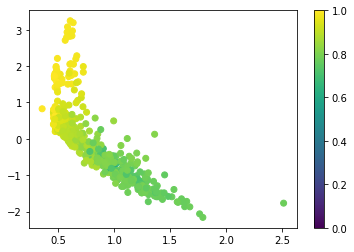

In [612]:
plt.scatter(np.array(state_avg_rmsd)[model.active_set], 
            state_avg_tics[model.active_set,:][:,0], c=committors[15])
plt.colorbar()

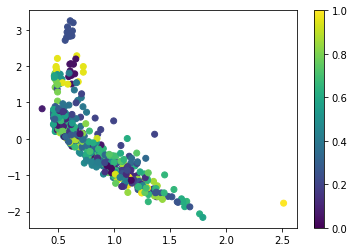

In [688]:
plt.scatter(np.array(state_avg_rmsd)[model.active_set], 
            state_avg_tics[model.active_set,:][:,0], c=np.concatenate([kmeans_committors.dtrajs[0], [50]])/50)
plt.colorbar()


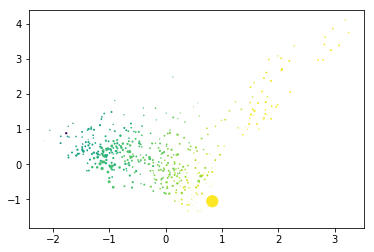

In [709]:
plt.scatter(state_avg_tics[model.active_set,:][:,0], 
            state_avg_tics[model.active_set,:][:,1], s=500*model.stationary_distribution, c=committors[-1])
#plt.colorbar()


In [790]:
ns_=[]
for i in range(10):
    kmeans_committors = pyemma.coordinates.cluster_kmeans(data=[np.array(committors)], k=20)
    ns_.append((kmeans_committors.dtrajs[0]==kmeans_committors.dtrajs[0][-1]).sum())
print(ns_)

11-12-18 18:30:46 pyemma.coordinates.clustering.kmeans.KmeansClustering[1467] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


11-12-18 18:30:46 pyemma.coordinates.clustering.kmeans.KmeansClustering[1471] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


11-12-18 18:30:48 pyemma.coordinates.clustering.kmeans.KmeansClustering[1483] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


11-12-18 18:30:48 pyemma.coordinates.clustering.kmeans.KmeansClustering[1485] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.
[14, 19, 19, 17, 25, 12, 16, 13, 23, 25]


In [789]:
print(np.mean(ns_))

11.2


In [791]:
kmeans_committors.dtrajs[0]

array([10,  3,  8,  1,  4,  0,  2, 12,  9,  0, 15,  7,  2, 10, 16,  3, 19,
       10,  9, 10, 14, 17,  6,  2, 11, 13,  7,  3,  4,  0,  8,  2, 10, 18,
       12, 11, 15, 10,  1,  4,  1,  1, 13,  7, 10, 17, 10,  1,  6,  2,  1,
        7, 16, 19,  0,  4,  7,  1, 10,  1,  1, 15,  1,  4,  4, 13, 16,  7,
       17,  7,  9,  2,  1,  1,  1,  7, 13,  2, 16,  6, 12,  6,  2,  9,  0,
       17,  0,  8, 10, 10,  0, 16,  1, 18,  2,  8,  1, 10, 16,  9,  3,  2,
       10, 10,  1, 14,  9,  6,  3, 10, 13, 11,  1, 16, 18,  7, 10,  1, 13,
        4,  3,  6, 10,  3, 10, 10,  1,  9, 13,  2,  9,  0,  7,  9,  7,  2,
        0, 10,  4,  9, 16, 10,  4, 10, 13, 10, 13, 18, 10,  4,  6, 14, 15,
        1, 16,  1, 12,  2, 10, 10,  8, 10,  5, 10,  7, 13,  9, 10,  1,  2,
        7, 17,  7, 10, 14, 15, 19,  5,  7, 12, 10, 10, 10, 17, 18,  6,  2,
        9,  9, 13,  3,  7, 13, 16, 12,  3,  2,  7, 17, 13,  4, 16, 13, 10,
        5, 13,  7,  8, 10,  7,  4,  2,  2, 13, 13,  3, 10,  4, 14, 10,  3,
       14, 12, 17,  7, 10

In [ ]:
for j in [i for i,dt in enumerate(dtrajs_fixed) if ((500 in dt))]:
    plt.plot(rmsds[j])


In [428]:
source.filenames[464]

['traj_noPBC/SH3_Ubq_Solv_470_eq_prod_nowater_nopbc.xtc']

In [448]:
for j in [i for i,r in enumerate(rmsds) if np.any(r<0.2)]:
    print(j, rmsds[j].min(), rmsds[j].max())


26 0.17812085 0.49663758
40 0.17364438 0.95811874
45 0.16534974 0.4409655
95 0.1817456 0.6323129
121 0.17518689 0.6224519
132 0.16452321 0.4664886
143 0.18698478 0.679725
149 0.1742803 0.59076566
166 0.18436855 0.7925395
174 0.17061463 0.4016238
200 0.15401424 0.49754152
251 0.1893047 0.451108
320 0.18698853 0.38803416
372 0.18967079 0.42170292
383 0.17843787 0.63947535
412 0.158323 0.56445545
416 0.19517933 0.6317699
418 0.16550873 0.5858854
443 0.16355692 0.4737401
474 0.19772157 0.51493925
478 0.15964836 1.1676747
492 0.16887236 0.8670678
514 0.1731604 0.55612963
586 0.16638589 0.55376065
685 0.19541681 0.4777993
704 0.16599265 0.6632481
761 0.17397994 0.5916154
830 0.1974528 0.5663866


In [449]:
source.filenames[26]

['traj_noPBC/SH3_Ubq_Solv_26_eq_prod_nowater_nopbc.xtc']

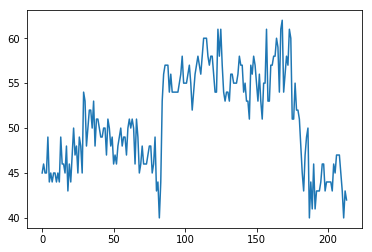

In [807]:
plt.plot(np.sum(data[1][:,:-1]<0.8, axis=1))

In [808]:
rmsds[1]

array([0.61651635, 0.6689488 , 0.7070403 , 0.7079599 , 0.6574001 ,
       0.7244985 , 0.7766846 , 0.7675064 , 0.8313721 , 0.72666043,
       0.7034854 , 0.6934845 , 0.6913592 , 0.7319153 , 0.66375995,
       0.65579873, 0.6868885 , 0.68787676, 0.72158724, 0.6331773 ,
       0.5669435 , 0.7414883 , 0.6915263 , 0.7483665 , 0.77007294,
       0.7738788 , 0.7397702 , 0.6765889 , 0.6066589 , 0.6847639 ,
       0.71148944, 0.77624696, 0.74121517, 0.78346163, 0.76243615,
       0.7846943 , 0.7729434 , 0.826592  , 0.7776699 , 0.76473564,
       0.7314699 , 0.73964447, 0.76729834, 0.7420689 , 0.8050456 ,
       0.7933434 , 0.8032679 , 0.77767605, 0.7463154 , 0.78264356,
       0.8005216 , 0.89447623, 0.89309645, 0.91881484, 0.9369577 ,
       0.9053368 , 0.8851579 , 0.89609987, 0.9048087 , 0.87805927,
       0.9178296 , 0.90226424, 0.91635066, 0.9141234 , 0.9204644 ,
       0.88944477, 0.9325624 , 0.91980726, 0.9272462 , 0.94191253,
       0.9295893 , 0.9172713 , 0.93514323, 0.9271747 , 0.91262

In [829]:
any_contacts = [(d[:,:3]<0.4).sum(axis=1) for d in data]

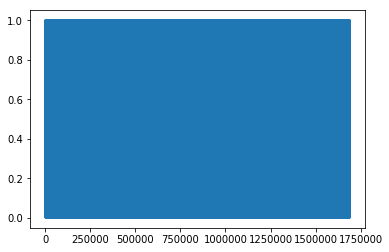

In [830]:
plt.plot(np.concatenate(any_contacts))

In [821]:
feat.describe()

['GROUP_MINDIST 0--1: [PHE 4 N 55 0...PHE 4 O 74 0]--[LEU 8 N 127 0...THR 9 O 159 0]',
 'GROUP_MINDIST 0--2: [PHE 4 N 55 0...PHE 4 O 74 0]--[THR 12 N 189 0...THR 14 O 235 0]',
 'GROUP_MINDIST 0--3: [PHE 4 N 55 0...PHE 4 O 74 0]--[ARG 42 N 655 0...LEU 43 O 697 0]',
 'GROUP_MINDIST 0--4: [PHE 4 N 55 0...PHE 4 O 74 0]--[ALA 46 N 737 0...LEU 50 O 811 0]',
 'GROUP_MINDIST 0--5: [PHE 4 N 55 0...PHE 4 O 74 0]--[LEU 67 N 1059 0...LEU 69 O 1113 0]',
 'GROUP_MINDIST 0--6: [PHE 4 N 55 0...PHE 4 O 74 0]--[VAL 70 N 1114 0...ARG 72 O 1172 0]',
 'GROUP_MINDIST 0--7: [PHE 4 N 55 0...PHE 4 O 74 0]--[LEU 73 N 1173 0...ARG 74 O 1215 0]',
 'GROUP_MINDIST 0--8: [PHE 4 N 55 0...PHE 4 O 74 0]--[PHE 17 N 1495 1...TYR 19 O 1549 1]',
 'GROUP_MINDIST 0--9: [PHE 4 N 55 0...PHE 4 O 74 0]--[GLN 22 N 1575 1...ASP 25 O 1629 1]',
 'GROUP_MINDIST 0--10: [PHE 4 N 55 0...PHE 4 O 74 0]--[LEU 27 N 1645 1...THR 28 O 1677 1]',
 'GROUP_MINDIST 0--11: [PHE 4 N 55 0...PHE 4 O 74 0]--[ILE 43 N 1899 1...ASP 44 O 1929 1]',
 'GROUP

In [832]:
rflux_ = pyemma.msm.tpt(model, [490], [491])

Text(0, 0.5, '$\\max (\\sum_j F^+_{ij}, \\sum_j F^+_{ji})$ ')

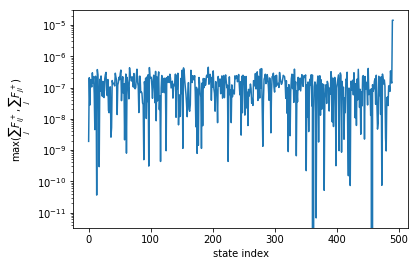

In [859]:
plt.semilogy([np.max([rflux_.net_flux[:,i].sum(),rflux_.net_flux[i].sum()]) for i in range(model.nstates)])

plt.xlabel('state index')
plt.ylabel(r'$\max (\sum_j F^+_{ij}, \sum_j F^+_{ji})$ ')

In [538]:
dtf_bootstraps = np.array_split(np.random.permutation(dtrajs_fixed), 10)
allbut = lambda i,r:[j for j in range(r) if j!=i]

bootstrap_its = []
#loop over bootstrap samples
for _ in range(10):
    #curr_dt = np.concatenate([dtf_bootstraps[x] for x in allbut(_, 10)]).tolist()
    bootstrap_its.append(pyemma.msm.its(dtf_bootstraps[_].tolist(), lags=[2,5,10,25,50,70,80,90,100] )) 

12-12-18 17:41:40 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[1796] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


12-12-18 17:41:44 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[1798] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


12-12-18 17:41:55 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[1800] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


12-12-18 17:41:59 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[1802] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


12-12-18 17:42:17 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[1804] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


12-12-18 17:42:26 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[1806] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


12-12-18 17:42:37 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[1808] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


12-12-18 17:42:41 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[1810] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


12-12-18 17:42:47 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[1812] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


12-12-18 17:42:52 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[1814] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


In [539]:
import msmtools as mt
its_all = pyemma.msm.its(dtrajs_fixed, lags=[2,5,10,25,50,70,80,90,100])

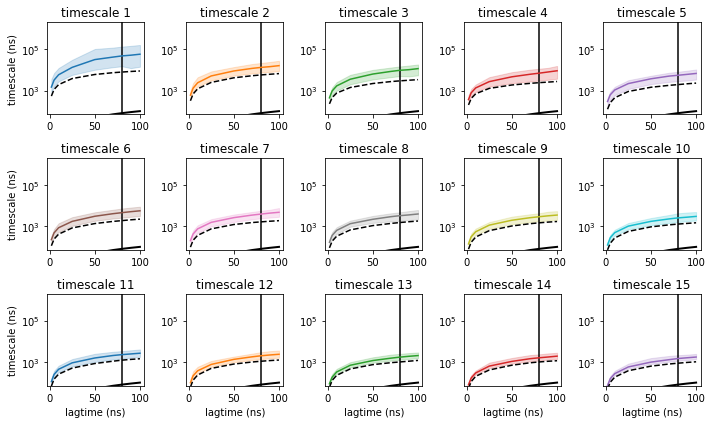

In [685]:
fig, _axs = plt.subplots(ncols=5, nrows=3, figsize=(10,6))
axs=_axs.flatten()
for _ in range(15):
    lo,up=mt.util.statistics.confidence_interval([bss.timescales[:,_] for bss in bootstrap_its])
    axs[_].semilogy(bootstrap_its[0].lags, np.mean([bss.timescales[:,_] for bss in bootstrap_its],axis=0),c=f"C{_%10}")
    axs[_].semilogy(its_all.lags, its_all.timescales[:,_],c='k',ls='--')
    axs[_].vlines(80,bootstrap_its[0].lags[-4], 2e6)
    axs[_].fill_between(bootstrap_its[0].lags, lo,up, alpha=0.2,color=f"C{_%10}")
    axs[_].plot(bootstrap_its[0].lags,bootstrap_its[0].lags,c='k',lw=2)
    axs[_].set_ylim(bootstrap_its[0].lags[-4], 2e6)
    axs[_].set_title(f"timescale {_+1}")
    if _>9:
        axs[_].set_xlabel('lagtime (ns)')
    if _ in [0,5,10]:
        axs[_].set_ylabel('timescale (ns)')

fig.tight_layout()
fig.savefig('timescales.pdf')

In [691]:
bootstrap_its[0].models[0].active_set.shape[0]/502

0.9442231075697212

In [690]:
from functools import reduce
bootstrap_models = [bss.models[-3] for bss in bootstrap_its]
common_set = reduce(np.intersect1d, [bss.models[-3].active_set for bss in bootstrap_its])


In [562]:
[np.setdiff1d(bss.models[-3].active_set, common_set).shape for bss in bootstrap_its]

[(86,), (108,), (100,), (83,), (111,), (85,), (65,), (107,), (111,), (107,)]

In [622]:
yo=[]
for i,msd in enumerate(model.metastable_distributions):
    for bsm in bootstrap_models:
        for k in range(20):
            yo.append( bsm.propagate(msd[bsm.active_set]/msd[bsm.active_set].sum(), k)[(model.metastable_assignments==i)[bsm.active_set]].sum())

In [ ]:
#direct estimation
yo2=[]
for _data_set in dtf_bootstraps:
    for lags in ((1+np.arange(20))*80).astype(int):
        
    

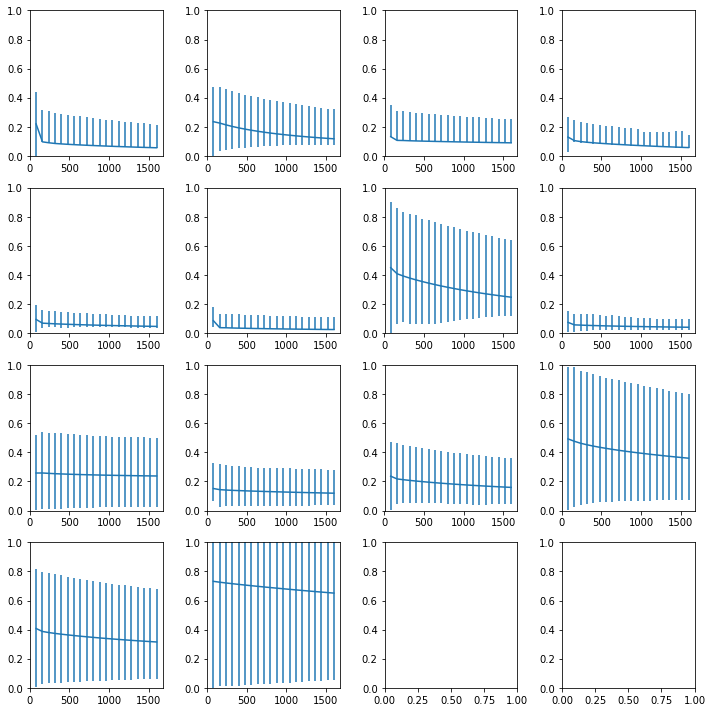

In [682]:
fig,axs = plt.subplots(ncols=4,nrows=4, figsize=(10,10))

ckt_=np.array(yo).reshape((len(model.metastable_distributions), len(bootstrap_models), 20))
for ax, ck in zip(axs.flatten(), ckt_):
    ax.errorbar((1+np.arange(20))*80, ck.mean(axis=0), yerr=mt.util.statistics.confidence_interval(ck, conf=0.65))
    ax.set_ylim(0,1)
fig.tight_layout()

In [670]:
bsm = bootstrap_models[-1]
msd = model.metastable_distributions[0]

for bsm in bootstrap_models:
    data=[bsm.propagate(msd[bsm.active_set]/msd[bsm.active_set].sum(), i)[ (model.metastable_assignments==0)[bsm.active_set]].sum() for i in range(12)]
    plt.errorbar((np.arange(20)+1)*80, )

TypeError: errorbar() missing 1 required positional argument: 'y'

In [604]:
bsm.propagate(msd[bsm.active_set]/msd[bsm.active_set].sum(), 10)[model.metastable_assignments[bsm.active_set]].sum()

2.2381723666357747

In [684]:
ckt_model = model.cktest(14)

12-12-18 20:06:34 pyemma._base.serialization.serialization ERROR    exception during unpickling PCCA(P=array([[6.92044e-01, 0.00000e+00, ..., 1.52543e-03, 0.00000e+00],
       [0.00000e+00, 4.32900e-02, ..., 0.00000e+00, 9.17497e-04],
       ...,
       [6.94277e-04, 0.00000e+00, ..., 1.54383e-01, 0.00000e+00],
       [0.00000e+00, 8.04295e-05, ..., 0.00000e+00, 3.76937e-01]]),
   m=14)
Traceback (most recent call last):
  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/pyemma/_base/serialization/serialization.py", line 451, in __setstate__
    Model.__my_setstate__(self, state)
  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/pyemma/_base/model.py", line 52, in __my_setstate__
    c.set_model_params(self, **params_for_c)
  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/pyemma/msm/models/pcca.py", line 62, in set_model_params
    self._M = pcca(P, m)
  File "/Users/solsson/miniconda3/lib/python3.6/site-packages/msmtools/analysis/dense/pcca.py", lin

KeyboardInterrupt: 

In [612]:
model.metastable_assignments[bsm.active_set]

array([13, 12, 11,  2, 11, 10, 13,  9,  8, 11,  8,  8, 12,  8,  8,  7,  1,
        6,  8, 13, 11, 11, 12,  8, 12,  0,  8,  8,  9, 13, 13, 10,  9,  8,
       11,  8,  8,  3,  8, 11,  8, 12,  9,  8,  8, 13, 11,  8, 10, 12, 12,
       11,  8,  8, 12, 13,  5,  8,  2, 11,  8,  8,  8,  4,  6,  7,  8, 11,
       12,  2,  8,  9, 11, 12,  8, 11, 12, 12,  8, 13, 11, 11, 13, 13, 13,
        7,  8, 11,  9, 13, 12,  8,  2, 11,  8, 11, 12,  8,  9,  8,  9,  7,
        8,  8,  8, 12,  8,  8, 13,  8, 11, 12,  8,  8,  8,  8, 12,  9,  8,
       13,  9, 12,  8, 11, 12,  8,  8, 12,  0, 11,  8, 13,  8,  7, 13, 12,
       11, 13,  9,  8,  8,  8,  8, 11, 11,  8,  8,  8, 12, 11,  8, 12,  8,
        3, 11, 11,  8, 11,  2, 12,  8, 11,  9, 13,  8, 10, 11, 11, 11, 12,
        8,  2, 11,  8,  8,  8,  9, 12, 13,  8,  8,  8,  8, 13, 12, 12,  1,
       11,  8,  9, 12, 13,  8,  8, 11,  8,  8, 13,  8, 11, 12,  8,  7,  8,
        8, 10,  8,  8,  7, 13,  4, 12, 13,  8, 12, 11, 11,  8,  9,  1, 11,
        8, 12,  8,  8, 12

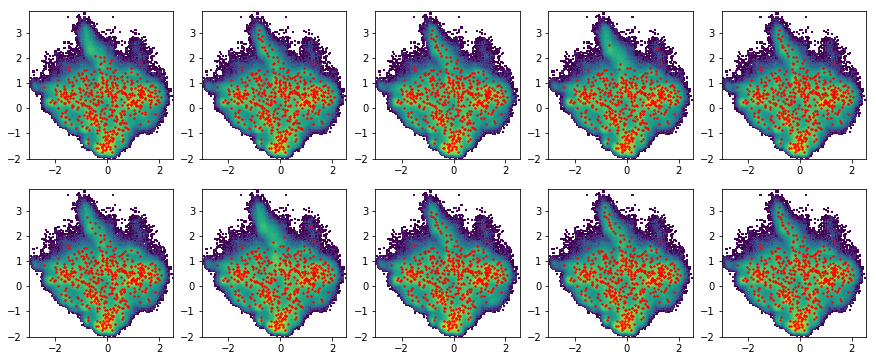

In [643]:
fig,ax = plt.subplots(ncols=5,nrows=2, figsize=(15,6))
for i,bsm in enumerate(bootstrap_models):
    ax.flatten()[i].hist2d(ystack[:,2], ystack[:,1], bins=128, norm=mpl.colors.LogNorm())
    ax.flatten()[i].scatter(state_avg_tics[bsm.active_set,2],state_avg_tics[bsm.active_set,1],s=2,c='r') 

In [636]:
len(bootstrap_models)

10

In [650]:
0.7/model.stationary_distribution[ model.metastable_sets[-1]].sum()

2.281750710963981

In [649]:
model.stationary_distribution[ model.metastable_sets[-1]].sum()

0.3067819795722855

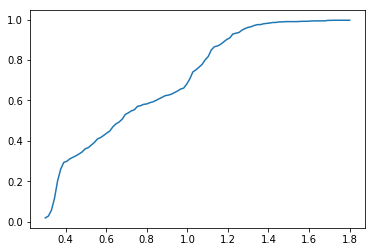

In [668]:
plt.plot(np.linspace(0.3,1.8, 100),[model.stationary_distribution[np.where(state_avg_rmsd<f)].sum() for f in np.linspace(0.3,1.8, 100)] )

In [1372]:
source.filenames

[['traj_noPBC/SH3_Ubq_Solv_0_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_1_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_2_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_3_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_4_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_5_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_6_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_7_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_8_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_9_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_10_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_11_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_12_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_13_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_14_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_15_eq_prod_nowater_nopbc.xtc'],
 ['traj_noPBC/SH3_Ubq_Solv_16_eq_prod_nowater_nopbc.xtc'],
 ['traj

In [1370]:
np.load('traj_noPBC/SH3_Ubq_Solv_943_eq_prod_nowater_nopbc_cf_4aa.npz')['arr_0'].reshape(-1).shape

(1401,)

In [1361]:
[chain_contact[i][j] for i,j in sampled_states[-1]]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [1366]:
source.trajectory_lengths()

array([1061, 1068, 9503, ..., 9161, 9077, 9995])

In [1386]:
associationmodel = pyemma.msm.bayesian_markov_model([cc.astype(int) for cc in chain_contact], lag=80)

In [1391]:
1./(associationmodel.sample_mean('mfpt', 1,0)*1e-9)

28888.718012431753

In [1407]:
np.sum([(np.diff(cc)>0.5).sum() for cc in chain_contact if np.any(cc==0) ])/np.concatenate([cc for cc in chain_contact if np.any(cc==0) ]).shape[0]

0.002951003873562199

In [1421]:
_A = 0.00002951003873562199 # times per nanosecond

In [1422]:
np.concatenate([cc for cc in chain_contact if np.any(cc==0) ]).shape[0]

169095

In [1424]:
1./(_A*associationmodel.stationary_distribution[0]/associationmodel.stationary_distribution[1])

8567791.555160163

In [ ]:
associationmodel = pyemma.msm.bayesian_markov_model([cc.astype(int) for cc in chain_contact], lag=80)

[array([51.015594 , 26.891449 ,  8.347153 , 76.22152  , 65.57417  ,
        44.59028  , 68.652855 , 67.81321  , 42.09317  , 61.19828  ,
        22.728294 , 60.689796 , 44.853935 , 38.97573  , 21.664772 ,
        53.487206 , 31.198494 , 59.188057 , 23.845764 , 89.00793  ,
        30.814201 , 59.368477 , 56.548958 , 62.639023 , 51.417206 ,
        66.79121  , 27.708824 , 59.434334 , 49.50054  , 44.050346 ,
        38.710373 , 35.601723 , 24.378662 , 53.60617  , 24.085266 ,
        52.44776  , 35.209625 , 60.27442  , 47.676826 , 51.55226  ,
        38.80863  , 19.9814   , 50.38759  , 49.02775  , 58.20153  ,
        47.682487 , 76.4234   , 42.15741  , 42.773415 , 51.307854 ,
        48.5393   , 35.79252  , 51.19615  , 86.600136 , 66.28784  ,
        56.68438  , 52.12317  , 73.79078  , 21.98674  , 24.795982 ,
        49.321823 , 30.537506 , 24.993858 , 37.366493 , 26.815025 ,
        29.409752 , 32.651703 , 54.81301  , 94.83616  , 71.98201  ,
        45.21846  , 50.381996 , 60.221992 , 53.6

In [141]:
dtc = np.concatenate(dtrajs_fixed)
cpincer = np.concatenate(pincer)
cpflip = np.concatenate(pflip)

/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


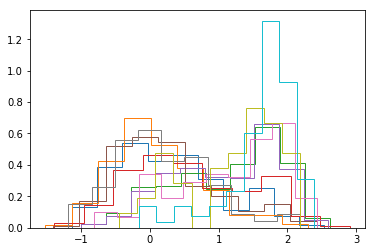

In [142]:
sd=[plt.hist(cpincer[dtc==i],bins=10,histtype='step', normed=True) for i in range(450,460)]

/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


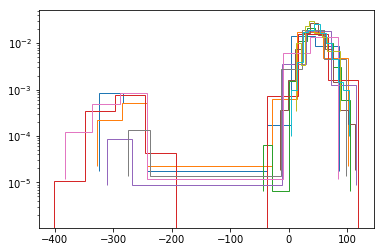

In [143]:
sd=[plt.hist(cpflip[dtc==i],bins=10,histtype='step', normed=True, log=True) for i in range(450,460)]

In [144]:
np.where(model.metastable_assignments==5)

(array([ 21, 226, 345]),)

In [145]:
model.metastable_assignments[-10:]

array([15, 10, 10, 10, 10, 10, 10, 10, 10, 10])

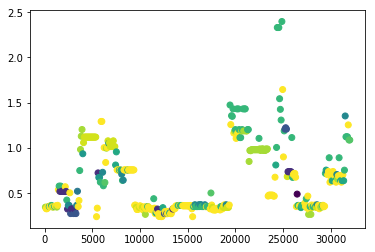

In [146]:
plt.scatter(np.arange(400)*80+80,state_avg_rmsd[dtc[::80][1000:1400]], c=model.metastable_assignments[dtc[::80][1000:1400]])

In [559]:

model.save('_model/Bayesian_MSM.pyemma')

/Users/solsson/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [137]:
model.metastable_memberships.shape

(457, 16)

In [253]:
meta_stable_assignment = model.metastable_assignments.copy()
meta_stable_assignment[-10:] = model.metastable_memberships.shape[1]
new_memberships = np.zeros((model.metastable_memberships.shape[0], model.metastable_memberships.shape[1]+1))
for i,m in enumerate(meta_stable_assignment):
    new_memberships[i, m] = 1

In [279]:
new_memberships.shape

(450, 17)

In [258]:
odel.transition_matrix.copy()

array([[0.90163409, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.9060455 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.87587097, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.76623377, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.35135135,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.88330632]])

(<Figure size 831.226x864 with 1 Axes>, array([[0.96206718, 0.51849143],
        [0.4387592 , 1.        ],
        [0.84399283, 0.        ],
        [0.16619356, 0.12540042],
        [0.2710746 , 0.46895492],
        [0.55759305, 0.8391991 ],
        [0.77411159, 0.28298841],
        [0.62439952, 0.19978402],
        [0.0725444 , 0.36855201],
        [0.36302961, 0.18401541],
        [0.        , 0.57753457],
        [0.65842679, 0.54429613],
        [0.37806711, 0.76640163],
        [0.66636092, 0.7935924 ],
        [0.46445923, 0.55033247],
        [0.45658539, 0.44455037],
        [0.50195913, 0.69277498]]))

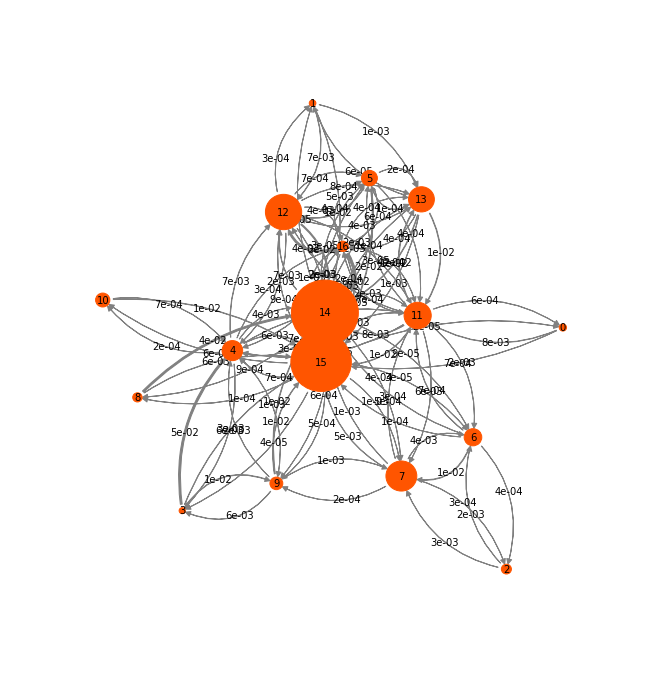

In [272]:
pyemma.plots.plot_markov_model(coarsegrain_tmat(model, new_memberships)[0])
#pyemma.plots.plot_markov_model(, minflux=5e-5)

In [271]:
Pcg

(array([[9.91062563e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.25776555e-03,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.79671937e-04,
         0.00000000e+00],
        [0.00000000e+00, 9.86130350e-01, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         7.44641147e-03, 1.32760577e-03, 5.09563291e-03, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 9.95519125e-01, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 1.91698853e-03, 2.56388607e-03,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.000

In [177]:
mt.analysis.statdist(coarsegrain_tmat(model.P, new_memberships))

NameError: name 'mt' is not defined

In [201]:
np.mean(np.concatenate(chain_contact)>1)

0.003682514125380697

In [202]:
np.concatenate(dtrajs_fixed).shape

(1689335,)

In [203]:
model.stationary_distribution[-10:].sum()

0.002811282904458753

In [204]:
state_avg_rmsd.dot(model.metastable_distributions.T)

array([0.64967471, 0.72188242, 0.96767974, 0.57037849, 0.82183569,
       0.47033127])

In [181]:
pcg, picg, cgem = coarsegrain_tmat(model, new_memberships)

In [182]:
cgem.argmax(axis=0)

array([ 2,  8, 14, 15, 15, 13, 10, 15, 14,  7,  8,  5,  9, 14, 14, 15, 14,
       14,  8, 13, 13, 13, 14,  8, 15,  4, 13,  8,  2, 13, 14,  8,  2, 12,
       15,  8,  2,  8, 13, 15, 15, 13,  5,  6, 13, 14, 14,  8,  4, 14,  0,
       13, 15, 14, 13, 10,  8, 14, 13, 14, 14, 14, 13, 14, 14, 14, 13, 15,
       15,  8,  2, 13, 13,  4, 15, 15, 15, 12,  4,  7, 14,  8, 10, 13, 14,
       14, 14, 10, 13,  5,  8, 14, 15, 13, 15, 13, 15,  8,  2, 14,  2, 13,
       15, 13, 13,  8,  4,  8, 14,  8,  8, 15, 13,  2,  2, 13,  4, 14, 14,
       14, 14, 13,  5, 14, 15,  4, 14, 14, 13,  9,  8,  8, 15, 14,  7, 14,
        2, 13, 15, 14,  8, 14,  8, 13, 14, 15, 15, 13,  2, 13, 11, 13, 14,
        2, 13,  8, 14, 15, 13, 15, 13, 15, 14, 14, 14,  8, 14,  8, 13,  5,
       13, 13, 13, 14,  1, 13,  8, 14, 14, 15,  8,  8,  8, 14, 10, 14, 15,
        5, 13, 14, 10, 15, 15, 13,  8, 13, 13, 14, 15, 15, 15,  8, 14, 15,
       12, 14, 14, 15, 13, 13, 15,  2,  8,  8,  4, 15, 14, 14, 13, 11,  2,
        8, 14, 15,  1, 14

(<Figure size 859.312x864 with 1 Axes>, array([[0.61815189, 0.        ],
        [0.24823058, 0.06261231],
        [0.52378488, 0.19701343],
        [0.        , 0.56251984],
        [0.37976834, 0.71340824],
        [0.54395696, 0.39122896],
        [0.65143464, 0.93880538],
        [0.48161539, 1.        ],
        [0.39872222, 0.41788001],
        [0.73193031, 0.37685498],
        [0.37706271, 0.80091857],
        [0.99457364, 0.55444391],
        [0.8497974 , 0.78554439],
        [0.45226059, 0.58754438],
        [0.6054013 , 0.63599165],
        [0.6790745 , 0.57613125],
        [0.24747091, 0.57170243]]))

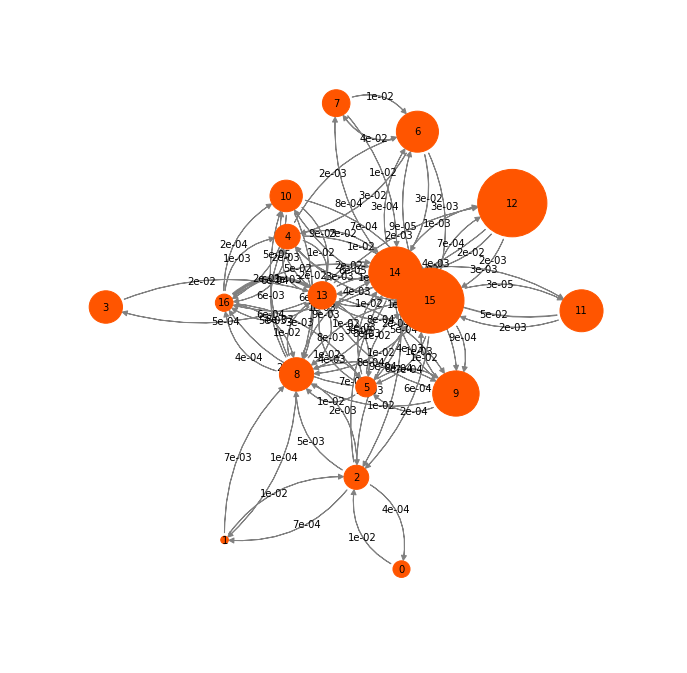

In [184]:
pyemma.plots.plot_markov_model(pcg, state_sizes=cgem.dot(model.stationary_distribution))#, minflux=5e-5)

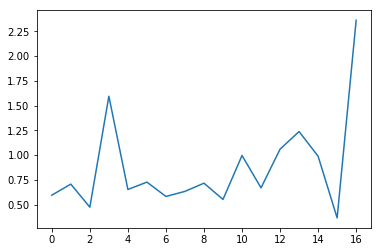

In [192]:
plt.plot(cgem.dot(state_avg_rmsd))

In [185]:
cg_rate_model = np.zeros((cgem.shape[0], cgem.shape[0]))
for i,j in product(range(cgem.shape[0]), repeat = 2):
    cg_rate_model[i, j] = model.mfpt(np.where(cgem.argmax(axis=0)==i)[0],np.where(cgem.argmax(axis=0)==j)[0])

In [186]:
pyemma.plots.plot_network(cg_rate_model[np.where(cg_rate_model<1e5)], state_sizes=cgem.dot(model.stationary_distribution))

/Users/solsson/miniconda3/lib/python3.6/site-packages/pyemma/plots/networks.py:74: UserWarning: The layout optimization method will take a long time for large networks! It is recommended to coarse grain your model first!
  warnings.warn("The layout optimization method will take a long"


ValueError: not enough values to unpack (expected 2, got 1)

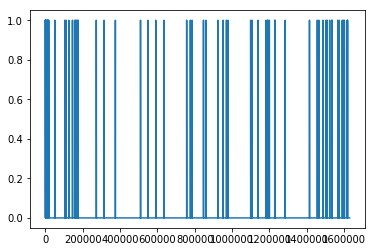

In [201]:
plt.plot(np.concatenate(chain_contact)>2)


In [239]:
flux = pyemma.msm.tpt(model, np.where(cgem.argmax(axis=0)==16)[0] ,np.where(cgem.argmax(axis=0)==15)[0] )

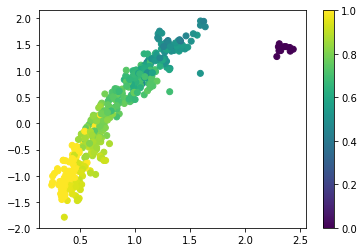

In [240]:
plt.scatter(state_avg_rmsd, state_avg_tics[:,0], c=flux.committor)
plt.colorbar()

In [210]:
plt.plot(np.linspace(0,1,100),[model.stationary_distribution[np.where(flux.committor>(1-alpha))[0]].sum() for alpha in np.linspace(0,1,100)])
plt.vlines(0.15,0,1)

NameError: name 'flux' is not defined

In [66]:
np.unique(new_memberships.argmax(axis=1)[np.where(flux.committor>0.80)[0]],return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12]),
 array([ 7,  1, 13, 47, 11,  4,  4,  3, 22, 41, 76, 96]))

In [67]:
np.unique(new_memberships.argmax(axis=1), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([  7,   7,  13,  59,  11,   4,   4,   3,  32,  61,  41, 112,  96,
         10]))

In [68]:
bound_meta_states_ = np.isin(new_memberships.argmax(axis=1),[0,1,2,5])

In [69]:

CS_exp_unbound=np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,1][reindex_exp]
CS_exp_bound=np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,-1][reindex_exp]


NameError: name 'reindex_exp' is not defined

In [1680]:
delta_binding_expl=np.abs(CS_exp_unbound-CS_exp_bound)

In [1691]:
delta_delta = []
for p in np.linspace(0,1,100):
    sim_bound = CS_sim[flux.committor>p,:].T.dot(model.stationary_distribution[flux.committor>p])/model.stationary_distribution[flux.committor>p].sum()
    sim_unbound = CS_sim[flux.committor<p,:].T.dot(model.stationary_distribution[flux.committor<p])/model.stationary_distribution[flux.committor<p].sum()
    delta_delta.append(np.abs(delta_binding_expl-np.abs(sim_unbound-sim_bound)).mean()) 

/Users/solsson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/solsson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [707]:
fig,ax=plt.subplots(ncols=2, figsize=(6,3))
ax[0].bar(ridx_camshift[reindex_camshift]-0.25,weighed_variance(np.array(state_cs)[:,[i for i,f in enumerate(fields) if "nh" in f][:70]][:,reindex_camshift], model.stationary_distribution)**0.5, width=0.5, label=r"$\sigma_{\delta}$ MSM")
ax[0].bar(ridx_exp[reindex_exp]+0.25, np.abs(np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,1][reindex_exp]-np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,-1][reindex_exp]), width=0.5, label=r"$\Delta\delta$ Experiment" )
ax[0].legend()
ax[0].set_xlabel('Residue')
ax[0].set_ylabel(r'$\sigma_{\delta}$ or $\Delta\delta$ / p.p.m')
ax[0].set_xlim(0,77)
fig.tight_layout()


In [206]:
from scipy.optimize import bisect
def committor_to_KD(p):
    concentration_micro_molar=1994.334288806385
    bound_p = model.stationary_distribution[flux.committor>p].sum()
    return (1-bound_p)/bound_p*concentration_micro_molar

In [3328]:
np.unique(new_membership2[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

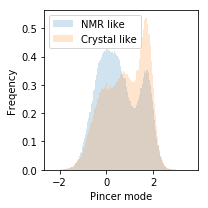

In [3340]:
fig, ax = plt.subplots(1, figsize=(3,3))
ax.hist(pincercat[np.where(new_membership2[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==12)], bins=128, alpha=0.2, label="NMR like", density=True);
ax.hist(pincercat[np.where(new_membership2[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==14)], bins=128, alpha=0.2, label="Crystal like", density=True);
ax.set_xlabel("Pincer mode")
ax.set_ylabel("Freqency")
ax.legend()
fig.tight_layout()
fig.savefig("pincer_bound.pdf")

In [3342]:
apf = [np.load(f"ubq_nowater/pepflip_{i}.npz.npy") for i in range(18)]
ap = [np.load(f"ubq_nowater/pincer_mode_{i}.npz.npy") for i in range(18)]

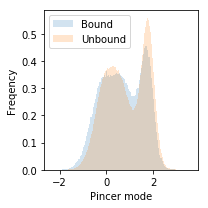

In [3347]:
fig, ax = plt.subplots(1, figsize=(3,3))
ax.hist(pincercat[np.where(new_membership[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==12)], bins=128, alpha=0.2, label="Bound", density=True);
ax.hist(np.concatenate(ap), bins=128, alpha=0.2, label="Unbound", density=True);
#ax.hist(pincercat[np.where(new_membership[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==13)], bins=48, alpha=0.2, label="Bound", density=True);

#ax.hist(pincercat[np.where(new_membership2[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==14)], bins=128, alpha=0.2, label="Crystal like", density=True);
ax.set_xlabel("Pincer mode")
ax.set_ylabel("Freqency")
ax.legend()
fig.tight_layout()
fig.savefig("pincer_bound_both.pdf")

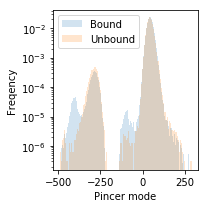

In [3381]:
fig, ax = plt.subplots(1, figsize=(3,3))
ax.hist(pflipcat[np.where(new_membership[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==12)], bins=128, alpha=0.2, label="Bound", density=True);
ax.hist(np.concatenate(apf), bins=128, alpha=0.2, label="Unbound", density=True, log=True);
#ax.hist(pincercat[np.where(new_membership[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==13)], bins=48, alpha=0.2, label="Bound", density=True);

#ax.hist(pincercat[np.where(new_membership2[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==14)], bins=128, alpha=0.2, label="Crystal like", density=True);
ax.set_xlabel("Pincer mode")
ax.set_ylabel("Freqency")
ax.legend()
fig.tight_layout()
fig.savefig("pflip_bound_both.pdf")

In [3358]:
pincercat[np.where(new_membership[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==12)]
np.concatenate(ap)


array([ 0.522037  ,  0.31046137, -0.03333082, ..., -0.92400116,
       -0.02763907, -0.6130745 ], dtype=float32)

In [3360]:
np.sum(np.concatenate(ap)<1.15)/len(np.concatenate(ap))

0.5796083519508458

In [3366]:
np.concatenate(model.discrete_trajectories_active)

array([443, 443, 443, ..., 224, 224, 224])

In [3374]:
np.sum(pincercat[np.where(new_membership[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==12)]<1.15)/len(pincercat[np.where(new_membership[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==12)])

0.6378697375269415

In [3378]:
np.sum(pflipcat[np.where(new_membership[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==12)]<-200)/len(pflipcat[np.where(new_membership[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==12)])

0.01943707058725634

In [3379]:
np.sum(np.concatenate(apf)<-200)/len(np.concatenate(ap))

0.024549482489021748

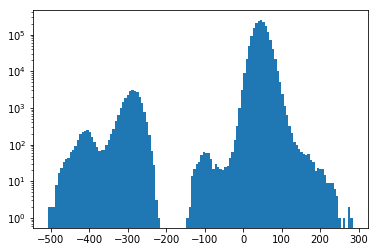

In [3377]:
plt.hist(pflipcat, bins=128,log=True);

In [3362]:
np.sum(np.concatenate(pincercat[np.where(new_membership[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==12)]
)<1.15)#/len(np.concatenate(pincercat[np.where(new_membership[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==12)]
))

ValueError: zero-dimensional arrays cannot be concatenated

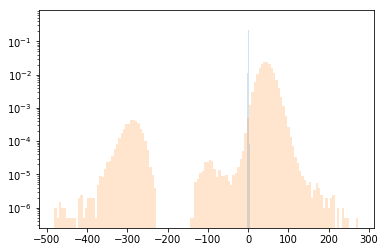

In [3335]:
plt.hist(pincercat[np.where(new_membership2[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==12)], bins=128, alpha=0.2,log=True,density=True);
plt.hist(pflipcat[np.where(new_membership2[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==14)], bins=128, alpha=0.2,log=True,density=True);

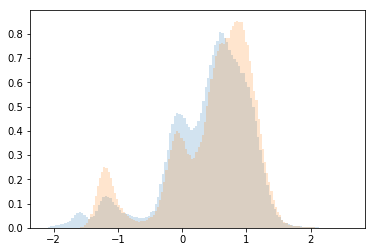

In [3337]:
plt.hist(cterm_order_cat[np.where(new_membership2[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==12)], bins=128, alpha=0.2,log=False,density=True);
plt.hist(cterm_order_cat[np.where(new_membership2[np.concatenate(model.discrete_trajectories_active),:].argmax(axis=1)==14)], bins=128, alpha=0.2,log=False,density=True);

In [1066]:
committor_co = bisect(lambda x:committor_to_KD(x)-370, 0,1)

/Users/solsson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


/Users/solsson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


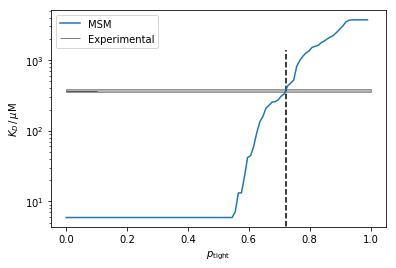

NameError: name 'flux' is not defined

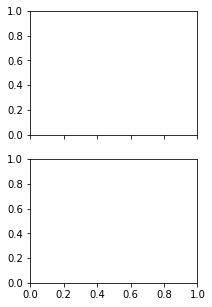

In [207]:
fig,ax = plt.subplots(nrows=2, figsize=(3,5), sharex=True)
concentration_micro_molar=1994.334288806385
ax[0].semilogy(np.linspace(0.0,1.0, 100), 
         [ (1-model.stationary_distribution[flux.committor>_c].sum())/model.stationary_distribution[flux.committor>_c].sum()*concentration_micro_molar 
          for _c in np.linspace(0.0,1.0, 100)], label="MSM")
ax[0].hlines(370,0.0,0.1, lw=0.5, label="Experimental")
ax[0].vlines(committor_co,0,2400,linestyle='dashed')
ax[0].fill_between([0.,1.0], [370+15,370+15], [370-15,370-15], alpha=0.3, color='k')
ax[0].set_ylabel(r"$K_D \, / \, \mu\mathrm{M}$")
ax[0].legend()

ax[1].plot(np.linspace(0.0,1.0, 100),delta_delta)
ax[1].vlines(committor_co,0.15,0.2,linestyle='dashed')

ax[1].set_xlabel(r"$p_{\mathrm{tight}}$")
ax[1].set_ylabel(r"$\langle \Delta \Delta ^{15}\mathrm{N}\delta \rangle$")
fig.tight_layout()
plt.savefig('ptight_delta_delta_Kd.pdf')

NameError: name 'flux' is not defined

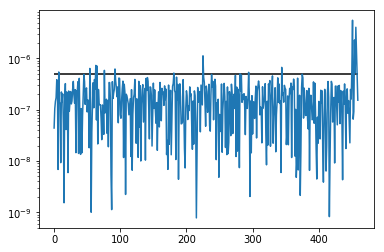

In [1077]:
plt.semilogy([np.max([flux.flux[:,i].sum(),flux.flux[i,:].sum()]) for i in range(model.nstates)])
plt.hlines(5e-7,0,460)

In [1101]:
flux = pyemma.msm.tpt(model, np.where(cgem.argmax(axis=0)==13)[0], np.where(cgem.argmax(axis=0)==12)[0] )

In [1102]:
reactive_flux=np.array([np.max([flux.flux[:,i].sum(),flux.flux[i,:].sum()]) for i in range(model.nstates)])

In [1526]:
np.where(reactive_flux>6e-7)[0]

array([ 54,  63,  65,  92, 225, 344, 450, 451, 454, 456, 457])

In [1542]:
dominant_flux_P = model.P[:, np.where(reactive_flux>6e-7)[0]][np.where(reactive_flux>6e-7)[0],:]
dominant_flux_P = dominant_flux_P/dominant_flux_P.sum(axis=1, keepdims=1)

(<Figure size 864x858.679 with 1 Axes>, array([[0.54229336, 0.73961645],
        [0.73779325, 0.62257747],
        [0.61215491, 0.99384133],
        [0.27354048, 0.97595684],
        [0.87327545, 0.83802898],
        [1.        , 0.54424521],
        [0.33212513, 0.02480372],
        [0.3903205 , 0.3428039 ],
        [0.51628768, 0.        ],
        [0.15656734, 0.13027043],
        [0.        , 0.37547158]]))

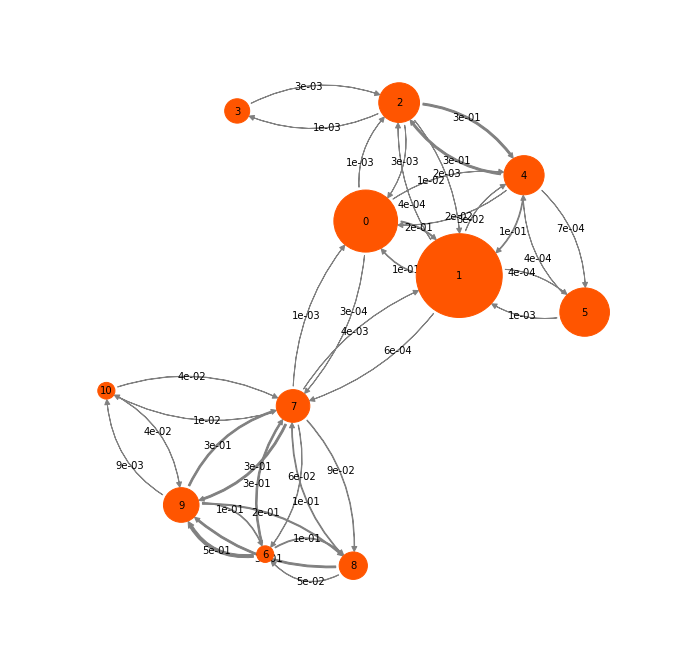

In [1543]:
pyemma.plots.plot_markov_model(dominant_flux_P)

C-term ordering association plot

In [209]:
model.P.shape

(454, 454)

In [211]:
[model.P[x][:x].sum() for x in np.where(np.isin(model.active_set, unbound_idx))[0]]

[0.23222150173221273,
 0.23789321758239518,
 0.14264600238872344,
 0.9472032050495753,
 0.31659110360626047,
 0.4393939397795448,
 0.5805972572594347,
 0.28087858711351854,
 0.5913305558486432,
 0.4627979488103748,
 0.49610389648409087]

In [2]:
reindexed_unbound = np.where(np.isin(model.active_set, unbound_idx))[0]
reindexed_bound = np.where(np.isin(model.active_set, bound_idx))[0]

NameError: name 'np' is not defined

(0, 0.001)

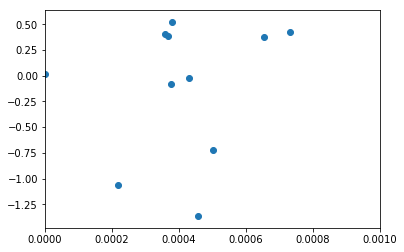

In [261]:
plt.scatter((model.P[reindexed_unbound,:][:,reindexed_bound]*model.stationary_distribution[reindexed_bound]).sum(axis=1) ,
            state_avg_CTICM[reindexed_unbound])
plt.xlim(0,0.001)

array([0.2322215 , 0.24500243, 0.142646  , 0.        , 0.23419392,
       0.29036977, 0.48831798, 0.28087859, 0.45005633, 0.40863046,
       0.28797765])

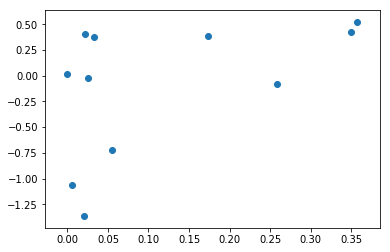

In [237]:
plt.scatter([model.P[reindexed_bound,:][:,x].sum() for x in reindexed_unbound],
            state_avg_CTICM[reindexed_unbound])

In [558]:
model.P[:,np.where(np.isin(model.active_set, unbound_idx))[0]][np.where(np.isin(model.active_set, unbound_idx))[0],:].sum(axis=0)

array([1.01620924, 1.24679723, 0.83396155, 1.00514108, 0.89950764,
       0.76455194, 0.97337318, 0.77649052, 0.6115714 , 0.84917433,
       1.68700585, 0.89391995, 0.05329115, 0.79375142])

In [570]:
unbound_states_in_model = np.where(np.isin(model.active_set, unbound_idx))[0]
model.P[:,unbound_states_in_model][unbound_states_in_model,:].sum(axis=0)

array([1.01620924, 1.24679723, 0.83396155, 1.00514108, 0.89950764,
       0.76455194, 0.97337318, 0.77649052, 0.6115714 , 0.84917433,
       1.68700585, 0.89391995, 0.05329115, 0.79375142])

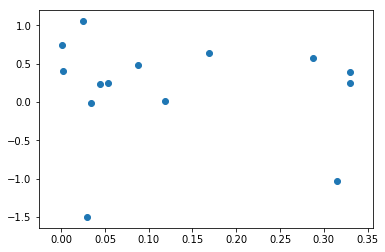

In [600]:
plt.scatter([model.P[:,x][:x].sum() for x in np.where(np.isin(model.active_set, unbound_idx))[0]], state_avg_CTICM[np.where(np.isin(unique_states, unbound_idx))[0]],)

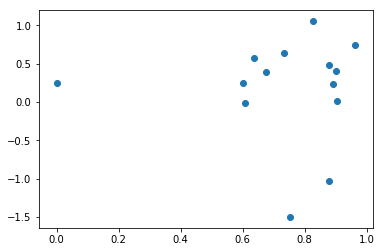

In [601]:
plt.scatter([model.P[x,:][x:].sum() for x in np.where(np.isin(model.active_set, unbound_idx))[0]], state_avg_CTICM[np.where(np.isin(unique_states, unbound_idx))[0]],)

In [2278]:
np.where(np.isin(unique_states, model.active_set[unbound_states_in_model]))[0]
model.active_set[unbound_states_in_model]

array([450, 451, 452, 453, 455, 456, 457, 458, 459, 460, 461, 915, 918,
       922, 923])

2.463297405928887

[442 443 444 445 446 447 448 449 450 451 452 637 638 639 640]


/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


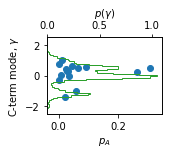

In [3442]:
fig,ax = plt.subplots(ncols=1,figsize=(2.5,2.25))
unbound_states_in_model = np.where(np.isin(model.active_set, unbound_idx))[0]
print(unbound_states_in_model)
norm_ = np.sum([model.P[np.isin(np.arange(641), unbound_states_in_model, invert=True),j].sum()/model.P[:,j].sum() for j in unbound_states_in_model])

ax.scatter([model.P[np.isin(np.arange(641), unbound_states_in_model, invert=True),j].sum()/model.P[:,j].sum()/norm_ for j in unbound_states_in_model], state_avg_CTICM[np.where(np.isin(unique_states, model.active_set[unbound_states_in_model]))[0]]
               )
ax.set_xlabel(r'$p_A$')
ax.set_ylabel(r'C-term mode, $\gamma$')
ax2 = ax.twiny()
ax2.hist(np.concatenate(unbound_only)[:,0][np.isin(dtc, np.where(cgem.argmax(axis=0)==13)[0])], 
         orientation="horizontal", bins=48, normed=True, histtype='step', label="unbound", color="C2")
ax2.set_xlabel(r'$p(\gamma)$')
fig.tight_layout()
ax2.set_ylim(-2.5,2.5)

fig.savefig('asprob_ICterm-mode.pdf')

In [3457]:
state_avg_CTICM[np.where(np.isin(unique_states, model.active_set[unbound_states_in_model]))][
np.argsort([model.P[np.isin(np.arange(641), unbound_states_in_model, invert=True),j].sum()/model.P[:,j].sum()/norm_ for j in unbound_states_in_model])
unbound_states_in_model[np.argsort([model.P[np.isin(np.arange(641), unbound_states_in_model, invert=True),j].sum()/model.P[:,j].sum()/norm_ for j in unbound_states_in_model])][0][-2:]]

SyntaxError: invalid syntax (<ipython-input-3457-7b6726008899>, line 3)

In [3467]:

association_Argmax = np.argsort([model.P[np.isin(np.arange(641), unbound_states_in_model, invert=True),j].sum()/model.P[:,j].sum()/norm_ for j in unbound_states_in_model])

unbound_states_in_model[association_Argmax]

array([446, 640, 444, 443, 448, 452, 449, 445, 450, 639, 442, 447, 451,
       637, 638])

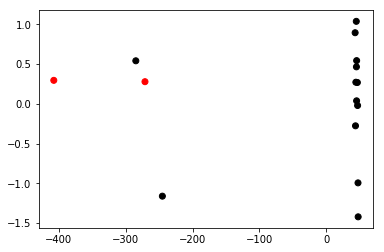

In [3480]:
plt.scatter(state_avg_pflip[[446, 640, 444, 443, 448, 452, 449, 445, 450, 639, 442, 447, 451, 637, 638]],state_avg_CTICM[[446, 640, 444, 443, 448, 452, 449, 445, 450, 639, 442, 447, 451, 637, 638]], c=['k']*13+['r']*2)

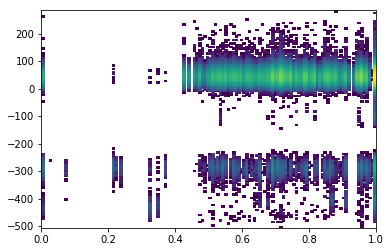

In [3498]:
plt.hist2d(tpt_.committor[np.concatenate(model.discrete_trajectories_active)], pflipcat, bins=128, norm=mpl.colors.LogNorm());

In [3606]:
feat.describe()[-47]

'GROUP_MINDIST 7--14: [LEU 73 N 1173 0...ARG 74 O 1215 0]--[PHE 63 N 2209 1...VAL 64 O 2244 1]'

In [3534]:
data_cat = np.concatenate(data)

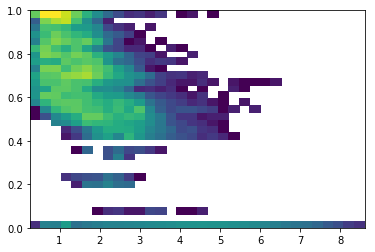

In [3644]:
plt.hist2d(data_cat[:,-81],tpt_.committor[np.concatenate(model.discrete_trajectories_active)],bins=32,norm=mpl.colors.LogNorm()); #feat.describe()[-33]

In [3664]:
cterm_order_cat

array([1.2080972 , 0.98120826, 1.0015395 , ..., 0.78554165, 0.64854777,
       0.8358084 ], dtype=float32)

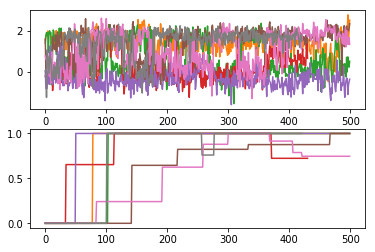

In [3686]:
deadtime = 500
fig, ax = plt.subplots(nrows=2)
k=0
for i,dt in enumerate(model.dtrajs_active):
    if np.isin([0], tpt_.committor[dt]):
        ___start=np.where(tpt_.committor[dt]==0)[0][0]
        if np.any(tpt_.committor[dt][___start:___start+deadtime]==1):
            k=k+1

            ax[0].plot(pincer[i][___start:___start+deadtime], c=f"C{k}");
            ax[1].plot(tpt_.committor[dt][___start:___start+deadtime], c=f"C{k}");
        #

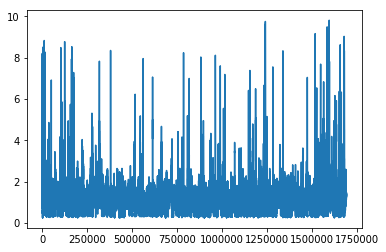

In [3605]:
plt.plot(data_cat[:,-47])

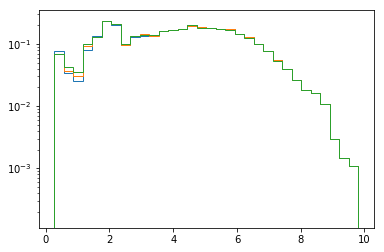

In [3603]:
for i in range(3):
    plt.hist(data_cat[np.where(tpt_.committor[np.concatenate(model.discrete_trajectories_active)]==0)[0]+i*5,-47],bins=32, density=True, log=True, histtype='step');
    

[442 443 444 445 446 447 448 449 450 451 452 637 638 639 640]


/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


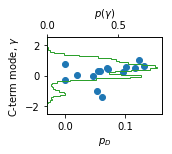

In [2647]:
fig,ax = plt.subplots(ncols=1,figsize=(2.5,2.25))
unbound_states_in_model = np.where(np.isin(model.active_set, unbound_idx))[0]
print(unbound_states_in_model)
norm_ = np.sum([model.P[j, np.isin(np.arange(641), unbound_states_in_model, invert=True)].sum()/model.P[j,:].sum() for j in unbound_states_in_model])
ax.scatter([model.P[j, np.isin(np.arange(641), unbound_states_in_model, invert=True)].sum()/model.P[j,:].sum()/norm_ for j in unbound_states_in_model], state_avg_CTICM[np.where(np.isin(unique_states, model.active_set[unbound_states_in_model]))[0]]
               )
ax.set_xlabel(r'$p_D$')
ax.set_ylabel(r'C-term mode, $\gamma$')
ax2 = ax.twiny()
ax2.hist(np.concatenate(unbound_only)[:,0][np.isin(dtc, np.where(cgem.argmax(axis=0)==12)[0])],
         orientation="horizontal", bins=48, normed=True, histtype='step', label="unbound", color="C2")
ax2.set_xlabel(r'$p(\gamma)$')
ax2.set_ylim(-2.5,2.5)
fig.tight_layout()
fig.savefig('disprob_ICterm-mode.pdf')

In [2347]:
[model.P[j, np.isin(np.arange(641), unbound_states_in_model, invert=True)].sum()/model.P[j,:].sum() for j in unbound_states_in_model]

[0.25883069294460864,
 0.5912622870359326,
 0.09127313144323537,
 0.26504384782419477,
 0.0,
 0.33667605158270053,
 0.29899652121425385,
 0.2791287429658922,
 0.22400164941627915,
 0.4899255398697511,
 0.34124486547090715,
 0.46187169605822087,
 0.5582596827831158,
 0.6319772566442488,
 0.0]

IndexError: index 46 is out of bounds for axis 0 with size 12

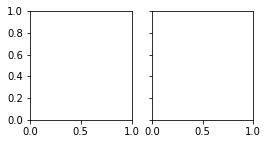

In [2846]:
fig,axs = plt.subplots(ncols=2,figsize=(4,2),sharey=True)
axs[0].scatter(model.P[450:,:][:,:450].sum(axis=1), km2.cluster_centers_[model.P[450:,:][:,:450].sum(axis=1).argsort(),0])
axs[0].set_xlabel(r'Dissociation probability')
axs[0].set_ylabel(r'IC C-term mode')
axs[1].hist(np.concatenate(unbound_only)[:,0][np.isin(dtc, np.where(cgem.argmax(axis=0)==13)[0])], orientation="horizontal", bins=48, normed=True, histtype='step', label="unbound")
axs[1].set_xlabel('Unbound probability')
fig.tight_layout()
fig.savefig('dissprob_ICterm-mode.pdf')

In [1630]:
model.P[450:,:][:,:450].sum(axis=1)

array([0.46562792, 0.68092708, 0.73388624, 0.40170493, 0.52701712,
       0.70112935, 0.56859476, 0.67283548, 0.74379496, 0.67410859])

In [2881]:
np.where(state_avg_icd>1)

(array([443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 647,
        648, 649, 650]),)

In [2882]:
simulation_= model.simulate(10000, start=450)

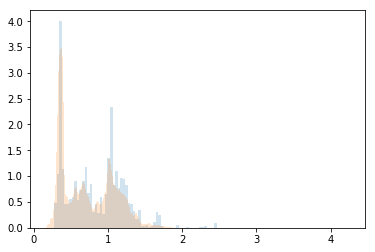

In [2891]:
plt.hist(state_avg_rmsds[simulation_],bins=64, density=True,alpha=0.2);
gfhgf=plt.hist(np.concatenate(rmsds), 1024, log=False, weights=np.concatenate(model.trajectory_weights()), density=True, alpha=0.2)


In [2892]:
state_avg_rmsds[simulation_]

array([1.938333  , 1.938333  , 1.938333  , ..., 0.35448825, 1.3976121 ,
       0.735646  ], dtype=float32)

In [755]:
def change_temperature(pi, Toriginal, Ttarget):
    frac = Toriginal/Ttarget
    logprw = frac*np.log(pi)
    prw = np.exp(logprw)
    return prw/prw.sum()

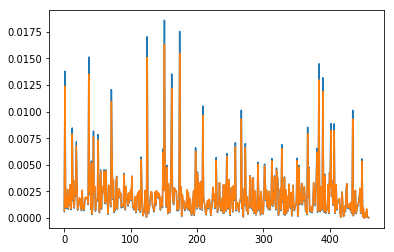

In [758]:
plt.plot(change_temperature(model.pi, 300, 278))
plt.plot(model.pi)

In [759]:
model_278 = pyemma.msm.estimate_markov_model(dtrajs_fixed, lag=80, statdist=change_temperature(model.pi, 300, 278))

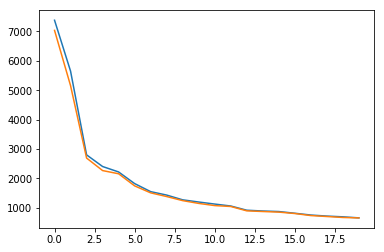

In [763]:
plt.plot(model_278.timescales()[:20])
plt.plot(model.timescales()[:20])

In [215]:
_dist_feats_idx = [i for i,f in enumerate(feat.describe()) if "GROUP_MINDIST" in f]

In [216]:
ncontacts_ = np.concatenate([(d[:,_dist_feats_idx]<0.5).sum(axis=1) for d in data])

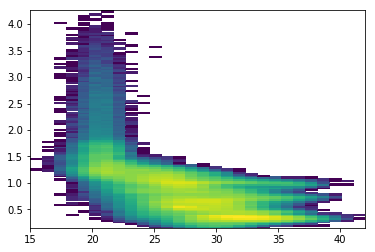

In [217]:
skjfh=plt.hist2d(ncontacts_, np.concatenate(rmsds), bins=[28,128], norm=mpl.colors.LogNorm())

In [218]:
skjfh=plt.hist2d(ncontacts_[bound_state_idx[dtc]], np.concatenate(rmsds)[bound_state_idx[dtc]], bins=[28,128], norm=mpl.colors.LogNorm())

NameError: name 'bound_state_idx' is not defined

In [256]:
def _cc(dtrajs, window = 10):
    dtrajs_fixed2 = []
    for dt in dtrajs:
        dt_ = dt.copy()
        ldt = len(dt_)
        for i in range(ldt):
            if i<window//2:
                state, scount = np.unique(dt[0:window], return_counts=True)
            elif i>(ldt-window//2):
                state, scount = np.unique(dt[-window:], return_counts=True)
            else:
                state, scount = np.unique(dt[i-window//2:i+window//2], return_counts=True)

            dt_[i] = state[np.argmax(scount)]
        dtrajs_fixed2.append(dt_.copy())
    return dtrajs_fixed2

In [ ]:
for cc in _cc([c>2 for c in chain_contact]):
    plt.plot( cc)

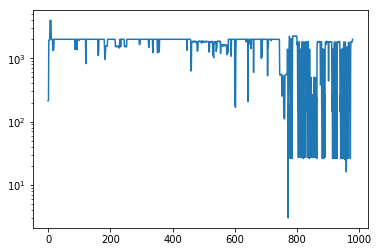

In [253]:
plt.semilogy([len(dt) for dt in dtrajs])


In [811]:
np.concatenate(model.dtrajs_active).shape

(1689335,)

In [816]:
traj_seeing_unbound=[i for i,dt in enumerate(dtrajs_fixed) if np.any(np.isin(dt, range(450,460)))]

In [819]:
np.concatenate([dtrajs_fixed[i] for i in traj_seeing_unbound])

array([452, 452, 452, ..., 183, 253, 253], dtype=int32)

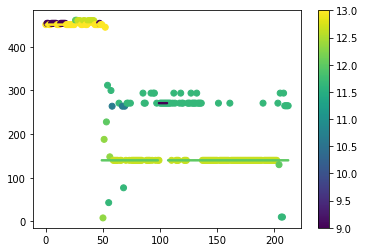

In [2896]:
plt.scatter(np.arange(len(dtrajs_fixed[0])), dtrajs_fixed[0],c=new_membership.argmax(axis=1)[dtrajs_fixed[0]])

plt.scatter(np.arange(len(dtrajs_fixed2[0])), dtrajs_fixed2[0],c=new_membership.argmax(axis=1)[dtrajs_fixed2[0]],s=2)
plt.colorbar()


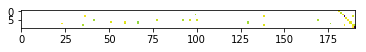

In [2897]:
plt.imshow(model.P[-10:,450:], norm=mpl.colors.LogNorm())

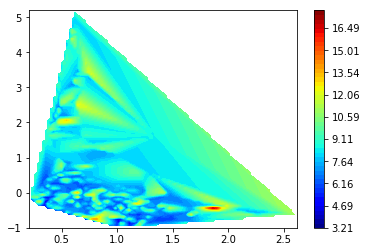

In [2902]:
pyemma.plots.contour(state_avg_rmsds[reindex_obs_set],state_avg_tics[reindex_obs_set, 0], -np.log(model.stationary_distribution))

In [2903]:
state_avg_rmsd[new_memberships.argmax(axis=1)==5]

NameError: name 'state_avg_rmsd' is not defined

In [969]:
source.trajectory_lengths()

array([1061, 1068, 9503, ..., 9161, 9077, 9995])

In [978]:
for i,dt in enumerate(dtrajs_fixed):
    np.save(f"_model/dtrajs_fixed_{i}.npz", dt)

In [1117]:
cgem

(14, 460)

In [1122]:
sampled_states=model.sample_by_distributions(cgem, 50)
for i,sampls in enumerate(sampled_states[:]):
    filename = f"metastable_{i}.xtc"
    pyemma.coordinates.save_traj(nfsource, sampls, outfile=filename)
#model.metastable_distributions

16-12-18 16:02:04 pyemma.coordinates.api INFO     Created file metastable_0.xtc
16-12-18 16:02:04 pyemma.coordinates.api INFO     Created file metastable_1.xtc
16-12-18 16:02:05 pyemma.coordinates.api INFO     Created file metastable_2.xtc
16-12-18 16:02:06 pyemma.coordinates.api INFO     Created file metastable_3.xtc
16-12-18 16:02:06 pyemma.coordinates.api INFO     Created file metastable_4.xtc
16-12-18 16:02:07 pyemma.coordinates.api INFO     Created file metastable_5.xtc
16-12-18 16:02:08 pyemma.coordinates.api INFO     Created file metastable_6.xtc
16-12-18 16:02:08 pyemma.coordinates.api INFO     Created file metastable_7.xtc
16-12-18 16:02:09 pyemma.coordinates.api INFO     Created file metastable_8.xtc
16-12-18 16:02:10 pyemma.coordinates.api INFO     Created file metastable_9.xtc
16-12-18 16:02:11 pyemma.coordinates.api INFO     Created file metastable_10.xtc
16-12-18 16:02:12 pyemma.coordinates.api INFO     Created file metastable_11.xtc
16-12-18 16:02:14 pyemma.coordinates.a

In [2847]:
phi_ex=[model.fingerprint_correlation(CS_sim[:,i]) for i in range(CS_sim.shape[1])]

In [2848]:
phi_ex[0][0]*1e-9

array([           inf, 1.18427186e-05, 9.77644978e-06, 7.44011673e-06,
       4.60592605e-06, 3.67513493e-06, 3.52630517e-06, 2.98403915e-06,
       2.75882973e-06, 2.64126758e-06, 2.46675552e-06, 2.16109599e-06,
       2.08377143e-06, 1.80622558e-06, 1.79435528e-06, 1.70386743e-06,
       1.61901960e-06, 1.58986527e-06, 1.47806558e-06, 1.40441583e-06,
       1.31388792e-06, 1.24473692e-06, 1.22272525e-06, 1.16881542e-06,
       1.14751443e-06, 1.12982721e-06, 1.04172568e-06, 9.49837901e-07,
       9.46298359e-07, 9.31322562e-07, 9.24427616e-07, 9.10561939e-07,
       8.82366075e-07, 8.64623861e-07, 8.45572800e-07, 8.35849621e-07,
       8.09207482e-07, 7.78863539e-07, 7.71609427e-07, 7.16521756e-07,
       7.00758793e-07, 6.89661334e-07, 6.81307544e-07, 6.76089347e-07,
       6.60519703e-07, 6.42164193e-07, 6.29119010e-07, 5.81603870e-07,
       5.65343100e-07, 5.48714983e-07, 5.40746279e-07, 5.37007626e-07,
       5.31089897e-07, 5.26963317e-07, 5.25489814e-07, 5.11213265e-07,
      

In [1713]:
plt.bar()

array([8.5 , 8.75, 9.  , 9.25, 9.5 ])

In [2854]:
len(phi_ex)

51

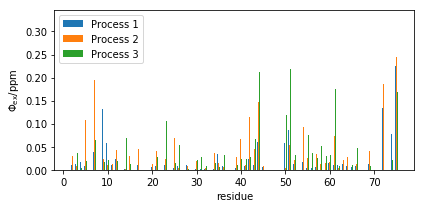

In [2857]:
fig,ax = plt.subplots(figsize=(6,3))
for i,_pe in enumerate(phi_ex):
    
    barpos = np.linspace(ridx_exp[reindex_exp][i]-0.2,ridx_exp[reindex_exp][i]+0.2,3)
    for j,ct in enumerate(_pe[1][1:4]**0.5):
        if i==0:
            ax.bar(barpos[j],ct,  width=0.2, color=f"C{j}", label=f"Process {j+1}")
        else:
            ax.bar(barpos[j],ct,  width=0.2, color=f"C{j}")
#plt.bar(ridx_exp[reindex_exp]+0.25, np.abs(np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,1][reindex_exp]-np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,-1][reindex_exp]), width=0.5, label=r"$\Delta\delta$ Experiment" )
ax.set_xlabel('residue')
ax.set_ylabel(r'$\Phi_{\mathrm{ex}} / \mathrm{ppm}$')
ax.legend()
fig.tight_layout()
fig.savefig('contributions.pdf')

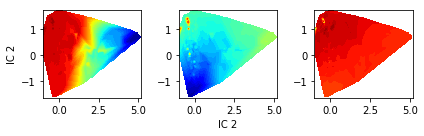

In [2874]:
fig,axs = plt.subplots(ncols=3,figsize=(6,2))
pyemma.plots.contour(state_avg_tics[reindex_obs_set,0],
                             state_avg_tics[reindex_obs_set,1], 
                             model.eigenvectors_right()[:,1],
                            ax=axs[0],colorbar=False)
pyemma.plots.contour(state_avg_tics[reindex_obs_set,0],
                             state_avg_tics[reindex_obs_set,1], 
                             model.eigenvectors_right()[:,2],
                            ax=axs[1],colorbar=False)
pyemma.plots.contour(state_avg_tics[reindex_obs_set,0],
                             state_avg_tics[reindex_obs_set,1], 
                             model.eigenvectors_right()[:,3],
                            ax=axs[2],colorbar=False)
axs[0].set_ylabel('IC 2')
axs[1].set_xlabel('IC 2')

fig.tight_layout()
fig.savefig('TIC_processes.pdf')

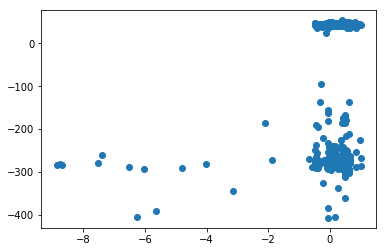

In [2878]:
plt.scatter( model.eigenvectors_right()[:,3], state_avg_pflip[reindex_obs_set])

In [1773]:
np.argsort(model.eigenvectors_right()[model.active_set,3])

array([ 82,  39, 444, 144, 178, 377, 336, 387, 370, 293, 242,   5,  19,
       111,  64, 276, 345, 129, 101, 203, 259, 312,  59, 160, 236,  23,
       255, 391, 107,  85, 430, 318, 122,  81,   3, 238,  70,  84, 253,
        35, 192, 437, 120, 358, 183, 432, 219,  83, 240, 187, 289, 315,
       161, 300, 383,  22, 333, 191, 350, 449, 376, 250, 218, 270,  48,
        11, 190, 146, 443, 365, 305, 180, 150, 324,  99,  13,  28, 413,
       304, 405, 319, 429, 374, 241, 392,  25, 337, 360, 348, 331, 457,
       159, 205, 287,  89, 417, 453, 222,  96, 103, 158, 421, 442, 121,
       330, 440, 353,  34, 355,  30, 213, 310, 450, 110, 458, 133, 231,
       266, 299, 268, 117, 454, 419,  67, 456, 243, 382, 356, 455,  93,
       156, 448, 140, 362, 415, 451, 114, 338, 244, 309, 399,  46, 363,
       452, 327,   0, 127, 176, 361, 388,   7, 230,  80, 254, 226, 202,
       378, 200, 341,  94, 281,  36,  69, 459,  45, 142, 194, 119,  47,
        49, 294, 277, 145, 265,  16, 326, 141, 115, 210, 438, 12

(<Figure size 786.576x864 with 1 Axes>, array([[0.        , 0.        ],
        [0.83164645, 0.95554801],
        [0.68383995, 0.85476384],
        [0.68239803, 0.64558709],
        [0.62079383, 0.42790504],
        [0.32884712, 0.57569076],
        [0.6526158 , 1.        ],
        [0.30908898, 0.91048446],
        [0.84017348, 0.69314963],
        [0.35532246, 0.37602304],
        [0.58186285, 0.67667527],
        [0.55738956, 0.78293858],
        [0.46173358, 0.72038693],
        [0.91038846, 0.78405648]]))

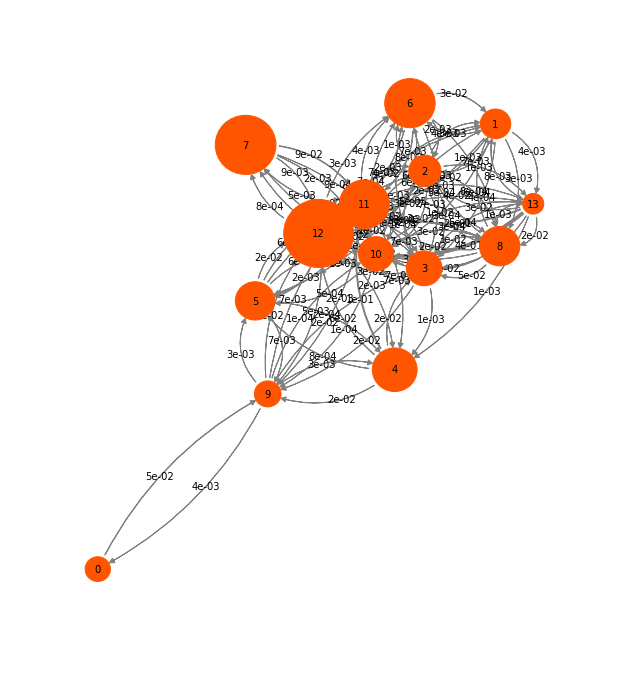

In [1279]:

pyemma.plots.plot_markov_model(pcg, state_sizes=cgem.dot(model.stationary_distribution), minflux=4e-6)

In [3831]:
phiex_sh3 = np.loadtxt('sh3_phiex.txt')

In [3842]:
reindex_sh3 = phiex_sh3[:,0].astype('int')-250

In [3843]:
reindex_sh3

array([ 1, 13, 16, 21, 22, 23, 28, 30, 32, 35, 36, 37, 38, 39, 43, 44, 48,
       49, 50, 53, 54, 58, 59, 60, 61, 63, 64, 65, 66, 68, 73, 76, 77, 79,
       81])

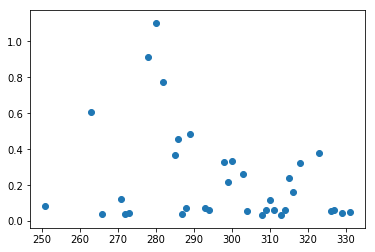

In [3834]:
plt.scatter(*phiex_sh3.T)

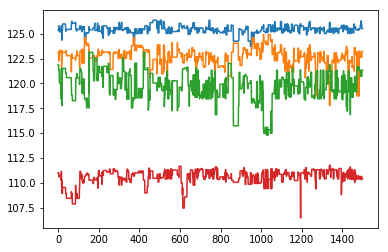

In [2904]:
plt.plot(CS_sim[simulation_[:1500],-4:])


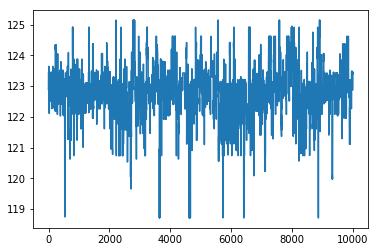

In [2972]:
plt.plot(CS_sim[simulation_[:],[-3]])


In [2948]:
np.where(state_avg_cc[reindex_obs_set]>1.0)

(array([442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 637, 638,
        639, 640]),)

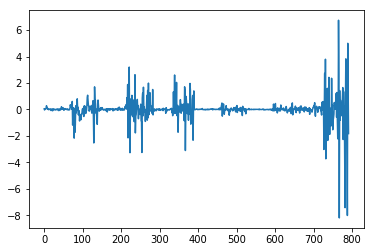

In [3424]:
plt.plot(state_cs[np.where(state_avg_cc[reindex_obs_set]>1),:][0,:,:].mean(axis=0)-state_cs[np.where(state_avg_cc[reindex_obs_set]<1),:][0,:,:].mean(axis=0))

In [3417]:
state_cs[np.where(state_avg_cc[reindex_obs_set]>1),:][0,:,[8,9,28,30,31,50]].mean(axis=1)-state_cs[np.where(state_avg_cc[reindex_obs_set]<1),:][0,:,[8,9,28,30,31,50]].mean(axis=1)

array([174.31473078, 175.87110425, 178.50729582, 177.21595504,
       177.33370966, 177.40417137])

In [3038]:
simulation_= model.simulate(30000, start=640)

In [2950]:
len(simulation_)

10000

In [2951]:
from matplotlib import gridspec

In [2952]:
cs_lbls = [r"%i $\delta^{15}$N$^{\mathrm{H}}$"%(idx) for idx in ridx_camshift[reindex_camshift]]

In [2971]:
cs_lbls[-3]

'72 $\\delta^{15}$N$^{\\mathrm{H}}$'

In [3827]:
unbound_Expl=np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,1][reindex_exp]
bound_Expl=np.loadtxt("/Users/solsson/projects/Ubq_SH3/openmm_equil/data_from_Kalyan/TITR_15N_7C_ED.txt")[1:,-1][reindex_exp]

In [3828]:
new_membership.shape

(641, 14)

/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


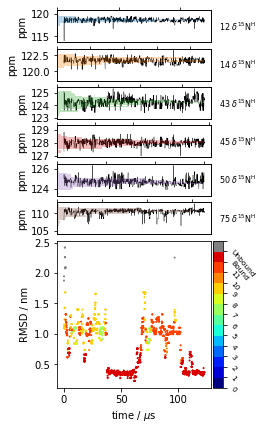

In [3829]:
selected_shifts = [8,9,28,30,31,50]
double_column_width = 6.968
single_column_width= 3.307
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(3.307*1.2,3.307*2.1))
gs = gridspec.GridSpec(10, 20)
ax_cs = [plt.subplot(gs[i, 3:17]) for i in range(6)]
hist_ax = []
for i,cs in enumerate(selected_shifts):
    ax_cs[i].plot((np.arange(3000)*41+41)*1e-3,CS_sim[simulation_[:3000], cs], lw=0.35, color='k')
    ax_cs[i].set_ylabel(r'ppm')
    hist_ax.append(ax_cs[i].twiny())
    hist_ax[-1].hist(CS_sim[simulation_[:], cs], bins=20, orientation='horizontal', alpha=0.3, density=True, color=f"C{i}")
    hist_ax[-1].set_xticklabels([""])
    #ax_cs[i].hlines([bound_Expl[cs]], 80e-3, 120,lw=0.2 )
    ax_cs[i].set_xticks([])
    ax_cs[i].text(1.05,0.5, cs_lbls[cs],transform=ax_cs[i].transAxes, rotation=0, va='center', fontsize=8)
    #plt.hlines()
ridx_camshift[reindex_camshift]
ax_rmsd = plt.subplot(gs[6:, 3:17])
ax_cbar = plt.subplot(gs[6:, 17:18])
#ax_CT = plt.subplot(gs[8:, 3:17])
#ax_cbar = plt.subplot(gs[8:, 17:18])
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[-1] = (.5,.5,.5,1.0)
# create the new map
cmap =  cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0,14,15)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

poels=ax_rmsd.scatter((np.arange(3000)*41+41)*1e-3,state_avg_rmsds[reindex_obs_set][simulation_[:3000]], c=new_membership.argmax(axis=1)[simulation_[:3000]]
            ,norm=norm,cmap=cmap,s=1
           );
ax_rmsd.set_xlabel(r'time / $\mu \mathrm{s}$')
ax_rmsd.set_ylabel(r'RMSD / nm')
cb=plt.colorbar(poels,cax=ax_cbar,ticks=range(15))#,label="state")
#cb.ax.set_yticks(np.linspace(1./15, 14./15, 14))
cb.ax.set_yticklabels([f"{i}" for i in range(12)]+["Bound", "Unbound"], rotation=-50, fontsize=7.5)
#ax_CT.plot((np.arange(3000)*41+41)*1e-3,state_avg_CTICM[reindex_obs_set][simulation_[:3000]], lw=1)
fig.tight_layout(h_pad=0.05, w_pad=10.1)
plt.savefig('cs_msm_sim.pdf')

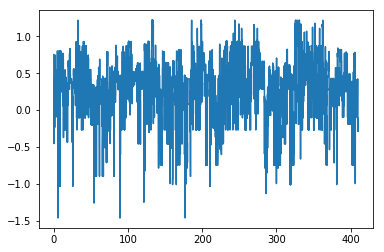

In [2986]:
plt.plot((np.arange(10000)*41+41)*1e-3,state_avg_CTICM[reindex_obs_set][simulation_])

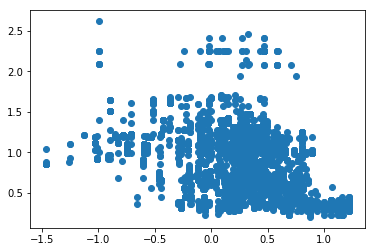

In [2988]:
plt.scatter(state_avg_CTICM[reindex_obs_set][simulation_][:-1],state_avg_rmsds[reindex_obs_set][simulation_][1:])

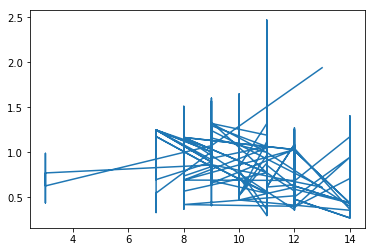

In [2928]:
plt.plot(new_membership2.argmax(axis=1)[simulation_[:1500]], state_avg_rmsds[simulation_[:1500]])

/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '
/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '


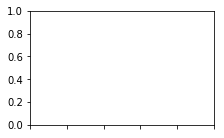

In [1311]:
double_column_width = 6.968
single_column_width= 3.307

fig = plt.figure(figsize=(single_column_width, 3*single_column_width))

gs = gridspec.GridSpec(120, 100,hspace=1.1)
ax = np.array([plt.subplot(gs[i*15 + i*5:(i+1)*15, :])  for i in range(6)])
for _ax in ax:
    _ax.set_xticklabels([])
gs.tight_layout(fig)

In [1187]:
np.where(ridx_exp[reindex_exp]==40)

(array([25]),)

In [3073]:
feat_pre = pyemma.coordinates.featurizer("align_topol.pdb")
atom_pairs = []
expl_dist = []
with open('PRE_FormanKay.dat') as f:
    for line in f.readlines():
        ls = line.split()
        atom_pairs.append([feat_pre.topology.select('resi {} and name {}'.format(ls[0], ls[1])), 
                           feat_pre.topology.select('resi {} and name {}'.format(int(ls[2])-1, ls[3])),  ])
        expl_dist.append(float(ls[-1]))

feat_pre.add_distances(np.array(atom_pairs).reshape(-1,2))

In [3071]:

#### Load data for ubq RDC back-calculation

atom_pairs_rdc = []
expl_rdc = []
with open('rdc_formankay_ubq.rdc') as f:
    for line in f.readlines():
        ls = line.split()
        atom_pairs_rdc.append([feat_pre.topology.select('resi {} and name {}'.format(int(ls[0])-1, ls[1])), 
                               feat_pre.topology.select('resi {} and name {}'.format(int(ls[2])-1, ls[3])),  ])
        expl_rdc.append(float(ls[-1]))

In [3074]:
source_pre = pyemma.coordinates.source([f"joined_strided_trajectories/trajectory_{i}.xtc" for i in range(1015) if i not in skippable], features=feat_pre)

In [3075]:
pre_dist = source_pre.get_output()

In [3088]:
pre_dist_cat = np.vstack(pre_dist)

In [3232]:
state_avg_pre=[(pre_dist_cat[dtc==i]**(-6.)).mean(axis=0)**(-1./6.) for i in unique_states]

In [3229]:
np.corrcoef(np.array(expl_dist)/10.,np.sum([wt.dot(pt**(-6)) for pt, wt in zip(pre_dist, model.trajectory_weights())],axis=0)**(-1./6.) )

array([[1.        , 0.40538059],
       [0.40538059, 1.        ]])

In [3102]:
state_avg_rmsds[np.argsort([np.corrcoef(sap,np.array(expl_dist)/10.)[0,1] for sap in state_avg_pre])[::-1]]

array([2.0735185 , 1.1555383 , 1.0413184 , 0.97592753, 2.3134189 ,
       1.094508  , 0.988659  , 1.1209369 , 2.0885456 , 1.0616682 ,
       1.0173991 , 1.1752094 , 1.1148851 , 1.9431354 , 1.1163497 ,
       0.5289393 , 1.1557574 , 0.9512651 , 1.0607975 , 0.4782828 ,
       2.1425047 , 0.6095251 , 1.0772872 , 0.8492575 , 1.0395545 ,
       0.7312923 , 1.1023053 , 1.1925104 , 1.0862834 , 0.5456805 ,
       0.8555745 , 0.5833022 , 0.8049644 , 1.0054752 , 1.0293394 ,
       0.99779123, 0.5002269 , 0.5912883 , 1.9420971 , 0.7716346 ,
       1.1998303 , 0.65020967, 1.0971527 , 1.1863756 , 2.268184  ,
       0.40737337, 0.67523366, 1.1351326 , 0.85357386, 0.99764884,
       0.60251206, 0.6467444 , 1.0972686 , 0.44319874, 0.9273073 ,
       0.9803146 , 0.87676686, 1.0650139 , 0.6327396 , 0.4463826 ,
       0.36239624, 0.5592806 , 0.43480015, 0.79874533, 1.163733  ,
       0.7070811 , 1.0975115 , 0.65642166, 0.6901244 , 1.0129083 ,
       0.37644023, 1.0011232 , 0.707985  , 0.4202007 , 0.33984

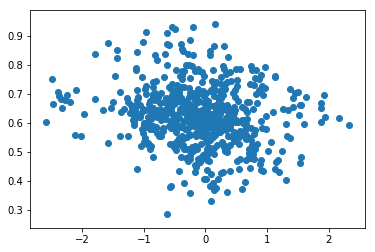

In [3114]:
plt.scatter(state_avg_tics[:,5], [np.std(sap-np.array(expl_dist)/10.) for sap in state_avg_pre])

In [ ]:
plt.scatter(AMM.stationary_distribution.dot(np.array(state_avg_pre)[reindex_obs_set,:]), np.array(expl_dist)/10)

In [3]:
low_concentration_hack = model.stationary_distribution.copy()
low_concentration_hack[state_avg_cc[reindex_obs_set]>1.0] = low_concentration_hack[state_avg_cc[reindex_obs_set]>1.0]*1000.
low_concentration_hack /= low_concentration_hack.sum()

NameError: name 'model' is not defined

In [ ]:
low_concentration_hack.dot(state_avg_rmsds[reindex_obs_set])

array([0.18933383, 0.17727878, 0.143977  , 0.11310644, 0.06420525,
       0.02248405, 0.02344574, 0.07936227, 0.10731866, 0.13106075,
       0.15603111, 0.19826027, 0.19681627, 0.18132821, 0.15155531,
       0.13694205, 0.10468496, 0.09322105, 0.10679338, 0.06039933,
       0.08985425, 0.05027053, 0.02779912, 0.05184865, 0.08216032,
       0.09567683, 0.03947369, 0.02946343, 0.03922013, 0.0708794 ,
       0.1019572 , 0.16576929, 0.15736914, 0.11839842, 0.08984067,
       0.02910148, 0.02079526, 0.05292958, 0.0413262 , 0.07957919,
       0.05238824, 0.0235157 , 0.09075793, 0.08947534, 0.13034642,
       0.09440368, 0.03967267, 0.05907706, 0.08984067, 0.11839842,
       0.1827118 ])

In [1]:
dist_pre_error = np.array([np.array(model.sample_std('expectation', np.array(state_avg_pre)[reindex_obs_set,i] )) for i in range(len(expl_dist))])
fig, ax = plt.subplots(1, figsize=(3,3))
ax.errorbar(low_concentration_hack.dot(np.array(state_avg_pre)[reindex_obs_set,:]**(-3.) )**(-1./3.)*10,
            np.array(expl_dist), xerr=dist_pre_error*10., yerr=2.5*np.ones(len(expl_dist)), fmt='.')
ax.plot(np.linspace(5, 30, 5),  np.linspace(5, 30, 5), color='k' )
#ax.hlines(22,  20, 25, color='k' )

ax.set_xlim(10,28)
ax.set_ylim(10,28)
ax.set_xlabel(r"$\langle d \rangle_{\mathrm{MSM}}\, /\, \AA$")
ax.set_ylabel(r"$\langle d \rangle_{\mathrm{expl}}\, /\, \AA$")
fig.tight_layout()
plt.savefig("pre_backcalc.pdf")

NameError: name 'np' is not defined

array([[13.20876823,  7.93043002],
       [15.6636627 ,  9.51436978],
       [15.19095036, 10.91424257],
       [16.36161794, 14.3579833 ],
       [19.00927798, 17.3740131 ],
       [19.51411223, 17.1259517 ],
       [20.95564727, 18.89039243],
       [20.50451547, 16.64716441],
       [20.14348264, 15.83091565],
       [18.49997183, 14.21013133],
       [15.78763534, 11.87355227],
       [14.2609334 , 10.52052554],
       [12.98077509,  9.52115789],
       [11.78228078,  8.65496017],
       [12.7220679 ,  9.43060937],
       [14.43995882, 10.93001461],
       [16.34094533, 12.92125559],
       [13.24052008, 10.15695232],
       [18.6709229 , 14.58708372],
       [19.17596802, 15.97451735],
       [21.21185768, 17.16416616],
       [20.12166229, 16.29745117],
       [21.47669995, 18.97348445],
       [19.60709845, 18.12563184],
       [17.73045058, 15.08752408],
       [17.01555367, 13.99076953],
       [13.80324577, 12.97451774],
       [13.42610095, 12.11236366],
       [13.59662736,

<BarContainer object of 51 artists>

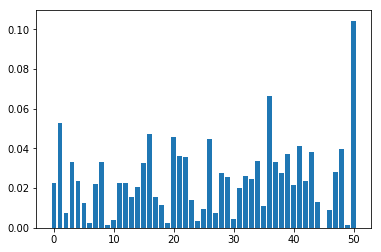

In [3235]:
plt.bar(np.arange(len(expl_dist)),np.sqrt((model.stationary_distribution.dot(np.array(state_avg_pre)[reindex_obs_set,:] )-np.array(expl_dist)/10)**2./np.array(np.array(expl_dist)*10.)) )

In [3168]:
np.mean(np.sqrt((model.stationary_distribution.dot(np.array(state_avg_pre)[reindex_obs_set,:] )*10-np.array(expl_dist))**2./np.array(np.array(expl_dist))))
            

0.7803790949061757

In [3143]:
AMM.stationary_distribution.dot(state_avg_pre[reindex_obs_set])

TypeError: only integer scalar arrays can be converted to a scalar index

In [3124]:
model.stationary_distribution.dot(state_avg_pre)

ValueError: shapes (641,) and (651,51) not aligned: 641 (dim 0) != 651 (dim 0)

In [241]:
sets, cgf=flux.coarse_grain([np.where(cgem.argmax(axis=0)==i)[0] for i in range(14)])

In [242]:
np.array([0.2,0.4,0.6,0.8])*(949-98)

array([170.2, 340.4, 510.6, 680.8])

In [243]:
(cgf.committor[[11,9,12,4,3]]*(949-98))

array([574.72927157, 693.6041693 , 661.83326306, 447.16749784,
       806.37624958])

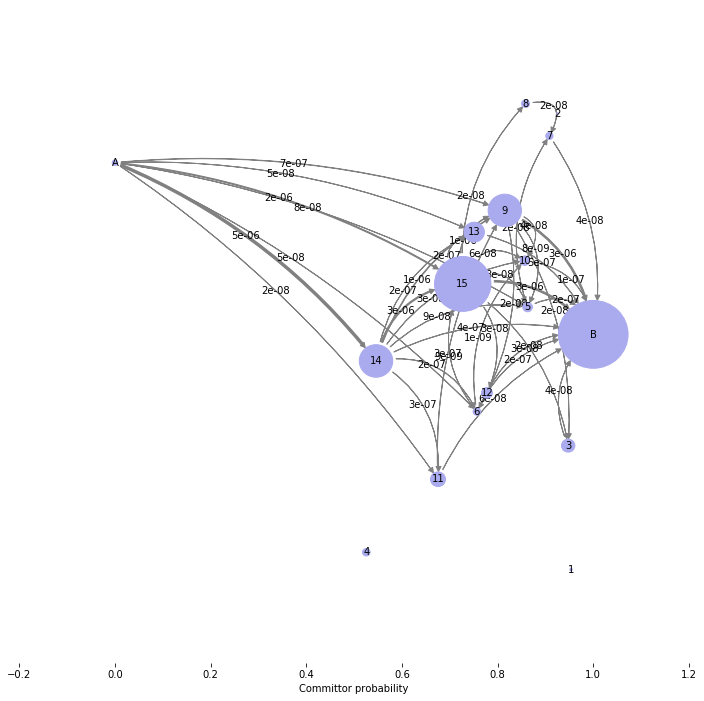

In [244]:
pyemma.plots.plot_flux(cgf,state_colors='#aaaaee')
plt.savefig('binding_flux.pdf')

/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


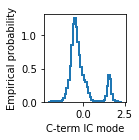

In [233]:
fig=plt.figure(figsize=(2,2))
sdkfn=plt.hist(np.concatenate(unbound_only)[:,0][np.isin(dtc, np.where(cgem.argmax(axis=0)==14)[0])], bins=48, log=False, lw=2, normed=True, histtype='step')#, label="unbound")
plt.xlabel('C-term IC mode')
plt.ylabel('Empirical probability')
plt.tight_layout()
plt.savefig('unbound_pincer.pdf')

/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


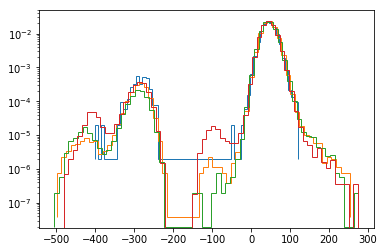

In [1264]:
sdkfn=plt.hist(np.concatenate(pflip)[np.isin(dtc, np.where(cgem.argmax(axis=0)==13)[0])], bins=64, log=True, normed=True, histtype='step')
sdkfn=plt.hist(np.concatenate(pflip)[np.isin(dtc, np.where(cgem.argmax(axis=0)==10)[0])], bins=64, log=True,normed=True, histtype='step')
sdkfn=plt.hist(np.concatenate(pflip)[np.isin(dtc, np.where(cgem.argmax(axis=0)==11)[0])], bins=64, log=True,normed=True, histtype='step')
sdkfn=plt.hist(np.concatenate(pflip)[np.isin(dtc, np.where(cgem.argmax(axis=0)==12)[0])], bins=64, log=True,normed=True, histtype='step')


array([-1.0275341 , -0.8747814 , -0.78138125, ..., -0.86258286,
       -0.69464666, -0.75221163], dtype=float32)

/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


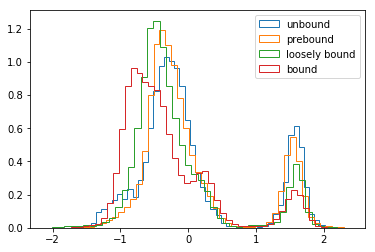

In [1272]:
sdkfn=plt.hist(np.concatenate(unbound_only)[:,0][np.isin(dtc, np.where(cgem.argmax(axis=0)==13)[0])], bins=48, normed=True, histtype='step', label="unbound")
sdkfn=plt.hist(np.concatenate(unbound_only)[:,0][np.isin(dtc, np.where(cgem.argmax(axis=0)==10)[0])], bins=48, normed=True, histtype='step', label="prebound")
sdkfn=plt.hist(np.concatenate(unbound_only)[:,0][np.isin(dtc, np.where(cgem.argmax(axis=0)==11)[0])], bins=48, normed=True, histtype='step',  label="loosely bound")
sdkfn=plt.hist(np.concatenate(unbound_only)[:,0][np.isin(dtc, np.where(cgem.argmax(axis=0)==12)[0])], bins=48, normed=True, histtype='step', label="bound")
plt.legend()

In [1277]:
np.where(unbound_only[-2][:,0]>1.0)

(array([625, 628, 631, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642,
        643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655,
        664, 689, 691]),)

In [1471]:
cgem.argmax(axis=1).shape

(14,)

In [1473]:
model.mfpt(np.where(cgem.argmax(axis=0)==12)[0],np.where(cgem.argmax(axis=0)==13)[0])

59100.069206771164

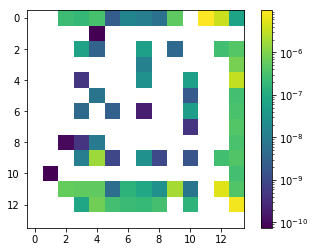

In [1469]:
plt.imshow(cgf.flux,norm=mpl.colors.LogNorm());plt.colorbar()

In [1481]:
cgem.argmax(axis=1)[11]

125

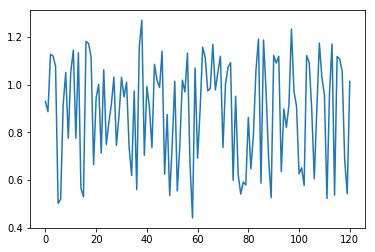

In [1482]:
plt.plot(state_avg_rmsd[np.where(cgem.argmax(axis=0)==11)[0]])

In [1483]:
np.where(cgem.argmax(axis=0)==11)[0]

array([  4,   9,  12,  17,  24,  29,  30,  32,  38,  45,  51,  55,  58,
        60,  61,  68,  77,  78,  79,  88,  90,  91,  94, 102, 103, 104,
       112, 115, 123, 124, 125, 132, 134, 141, 142, 143, 147, 149, 154,
       157, 163, 164, 165, 166, 167, 168, 169, 173, 179, 186, 196, 199,
       200, 207, 217, 223, 224, 226, 227, 230, 231, 232, 234, 237, 239,
       244, 246, 247, 257, 258, 260, 269, 271, 273, 274, 278, 281, 282,
       284, 290, 291, 295, 297, 299, 302, 310, 311, 317, 322, 325, 329,
       332, 334, 338, 339, 340, 342, 346, 349, 352, 357, 371, 378, 379,
       381, 385, 395, 396, 400, 403, 405, 409, 410, 418, 420, 423, 426,
       427, 431, 433, 439])

/Users/solsson/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


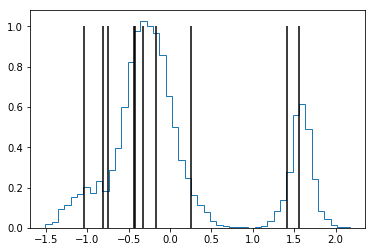

In [1519]:
sdkfn=plt.hist(np.concatenate(unbound_only)[:,0][np.isin(dtc, np.where(cgem.argmax(axis=0)==13)[0])], bins=48, normed=True, histtype='step', label="unbound")
plt.vlines(km2.cluster_centers_[:,0], 0,1)

In [1522]:
np.argsort(km2.cluster_centers_[:,0])


array([7, 2, 9, 1, 5, 3, 6, 0, 8, 4])

In [1523]:
454

454

In [1524]:
km2.cluster_centers_[:,0]

array([ 0.2531022 , -0.43574184, -0.81543225, -0.32950696,  1.5579956 ,
       -0.42325863, -0.16973768, -1.0427283 ,  1.4135814 , -0.7468937 ],
      dtype=float32)

In [1581]:
sovs=model.generate_traj(200, start=459)

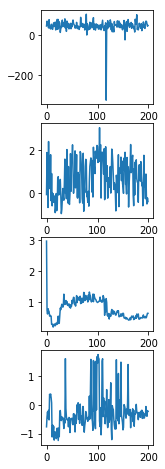

In [1582]:
fig,axs = plt.subplots(nrows=4, figsize=(2,8))
axs[0].plot([pflip[i][j] for i,j in sovs])
axs[1].plot([pincer[i][j] for i,j in sovs])
axs[2].plot([rmsds[i][j] for i,j in sovs])
axs[3].plot([unbound_only[i][j,0] for i,j in sovs])

In [1655]:
[i for i,(r,cc) in enumerate(zip(rmsds, chain_contact)) if (np.any(r<0.4) and np.any(cc>1.))]

[13, 17, 51, 140, 269, 288, 292, 344, 409, 464, 800, 877]

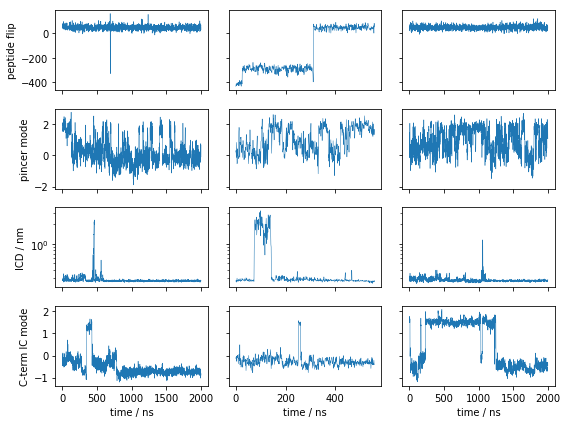

In [1670]:
tidx=[464, 800,288]
fig,axs = plt.subplots(nrows=4,ncols=3, figsize=(8,6),sharex='col',sharey='row')
axs[0,0].plot(pflip[tidx[0]][:2000],lw=0.5)

axs[0,0].set_ylabel('peptide flip')
axs[1,0].set_ylabel('pincer mode')
axs[2,0].set_ylabel('ICD / nm')
axs[3,0].set_ylabel('C-term IC mode')

axs[1,0].plot(pincer[tidx[0]][:2000],lw=0.5 )
axs[2,0].semilogy(chain_contact[tidx[0]][:2000],lw=0.5 )
axs[3,0].plot(unbound_only[tidx[0]][:,0][:2000],lw=0.5 )
axs[3,0].set_xlabel('time / ns')
      
axs[0,1].plot(pflip[tidx[1]][:1000],lw=0.5)
axs[1,1].plot(pincer[tidx[1]][:1000],lw=0.5 )
axs[2,1].semilogy(chain_contact[tidx[1]][:1000],lw=0.5 )
axs[3,1].plot(unbound_only[tidx[1]][:,0][:1000],lw=0.5 )
axs[3,1].set_xlabel('time / ns')


axs[0,2].plot(pflip[tidx[2]][:2000],lw=0.5)
axs[1,2].plot(pincer[tidx[2]][:2000],lw=0.5 )
axs[2,2].semilogy(chain_contact[tidx[2]][:2000],lw=0.5 )
axs[3,2].plot(unbound_only[tidx[2]][:,0][:2000],lw=0.5 )
axs[3,2].set_xlabel('time / ns')
plt.tight_layout()
plt.savefig('example_Trajectories.pdf')

In [1604]:
np.corrcoef(np.concatenate(pflip)[:-1], dtc[1:]<450)

array([[1.        , 0.00374009],
       [0.00374009, 1.        ]])

In [1611]:
unbound_tica

TICA(commute_map=False, dim=-1, epsilon=1e-06, kinetic_map=True, lag=20,
   ncov_max=inf, reversible=True, skip=0, stride=2, var_cutoff=0.95,
   weights=None)

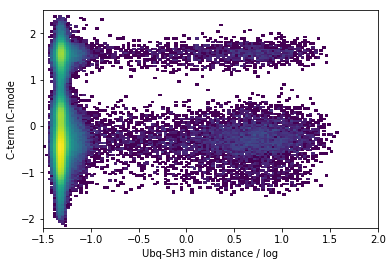

In [1620]:
plt.hist2d(np.log(np.concatenate(chain_contact)), unbound_project[:,0],bins=[np.linspace(-1.5,2, 128), np.linspace(-2.2,2.5, 128)], norm=mpl.colors.LogNorm())
plt.xlabel('Ubq-SH3 min distance / log')
plt.ylabel('C-term IC-mode')
plt.savefig('rawdata_dist_icmode.pdf')

Text(0, 0.5, 'C-term IC-mode')

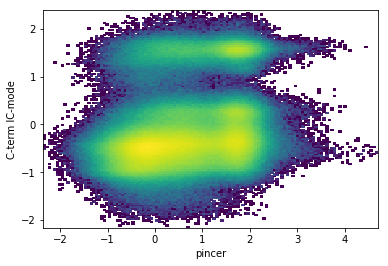

In [1804]:
plt.hist2d(np.concatenate(pincer)[np.concatenate(chain_contact)<1.0], unbound_project[np.concatenate(chain_contact)<1.0,0],bins=128, norm=mpl.colors.LogNorm())
plt.xlabel('pincer')
plt.ylabel('C-term IC-mode')
#plt.savefig('rawdata_dist_icmode.pdf')

Text(0, 0.5, 'C-term IC-mode')

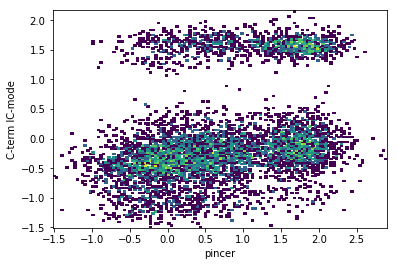

In [1803]:
plt.hist2d(np.concatenate(pincer)[np.concatenate(chain_contact)>1.0], unbound_project[np.concatenate(chain_contact)>1.0,0],bins=128, norm=mpl.colors.LogNorm())
plt.xlabel('pincer')
plt.ylabel('C-term IC-mode')
#plt.savefig('rawdata_dist_icmode.pdf')

Text(0, 0.5, 'C-term IC-mode')

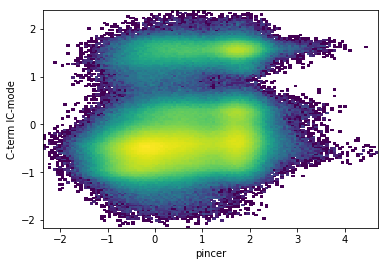

In [212]:
plt.hist2d(np.concatenate(pincer), unbound_project[:,0],bins=128, norm=mpl.colors.LogNorm())
plt.xlabel('pincer')
plt.ylabel('C-term IC-mode')
#plt.savefig('rawdata_dist_icmode.pdf')

Text(0, 0.5, 'C-term IC-mode')

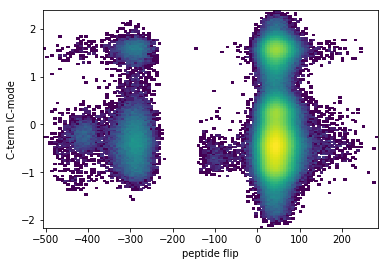

In [213]:
plt.hist2d(np.concatenate(pflip), unbound_project[:,0],bins=128, norm=mpl.colors.LogNorm())
plt.xlabel('peptide flip')
plt.ylabel('C-term IC-mode')
#plt.savefig('rawdata_dist_icmode.pdf')

/Users/solsson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


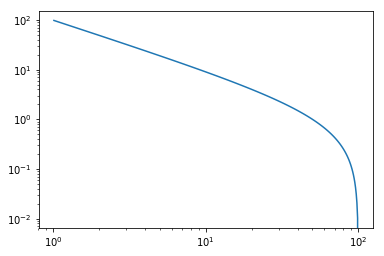

In [1801]:
plt.loglog(np.linspace(0,1,100)*100, (1-np.linspace(0,1,100))/np.linspace(0,1,100))

In [1800]:
km2.cluster_centers_[:,0][np.argsort(km2.cluster_centers_[:,0])]

array([-1.0427283 , -0.81543225, -0.7468937 , -0.43574184, -0.42325863,
       -0.32950696, -0.16973768,  0.2531022 ,  1.4135814 ,  1.5579956 ],
      dtype=float32)

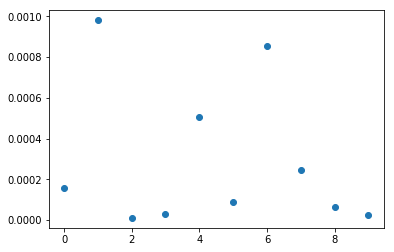

In [1799]:
plt.plot(np.argsort(km2.cluster_centers_[:,0]), model.stationary_distribution[450:][np.argsort(km2.cluster_centers_[:,0])],'o')

In [214]:
model.sample_conf('mfpt',[6, 0, 8, 4],[3,7, 2, 9, 1, 5]  )

(20120.95853754, 23104.271768024217)

In [215]:
md.load("ubi_xray46_fit_pincer_sorted.pdb").save_xtc("ubi_xray46_fit_pincer_sorted.xtc")

In [216]:
feat_xtal_ = pyemma.coordinates.featurizer(topfile="ubi_xray46_fit_pincer_sorted.pdb")

feat_xtal_.add_backbone_torsions(' or '.join([f'resi {i}' for i in range(69,76)]),cossin=True)
xtal_backbone_tors = pyemma.coordinates.load("ubi_xray46_fit_pincer_sorted.xtc",features=feat_xtal_)

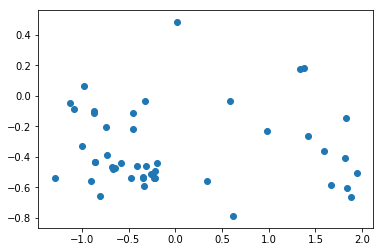

In [217]:
plt.scatter([-1.2920509576797485, -1.1293247938156128, -1.0799856185913086, -1.0016710758209229, -0.9724970459938049, -0.8984596133232117, -0.8722151517868042, -0.8702338933944702, -0.8562580943107605, -0.8562580943107605, -0.8086021542549133, -0.742949903011322, -0.726742148399353, -0.6741460561752319, -0.6655547022819519, -0.644569456577301, -0.5834217667579651, -0.473397433757782, -0.4570342004299164, -0.4535110592842102, -0.40470385551452637, -0.3450518250465393, -0.3428567051887512, -0.3334079086780548, -0.3264364004135132, -0.3169865012168884, -0.262016236782074, -0.22698959708213806, -0.21745960414409637, -0.21726825833320618, -0.19297091662883759, 0.01943209022283554, 0.3442772328853607, 0.5860190987586975, 0.6137315630912781, 0.9802151322364807, 1.3372974395751953, 1.3781088590621948, 1.4195547103881836, 1.5927443504333496, 1.6692551374435425, 1.813398003578186, 1.8326270580291748, 1.8335269689559937, 1.877500057220459, 1.9473531246185303],unbound_tica.transform(xtal_backbone_tors)[:,0])

In [2757]:
from itertools import product


array([[  0,  76],
       [  0,  77],
       [  0,  78],
       ...,
       [ 74, 147],
       [ 74, 148],
       [ 74, 149]])

In [2662]:
hbs = [md.load(f'set_{i:06d}.xtc', top="align_topol.pdb") for i in range(15)]

In [2758]:
baker_hubbard = [md.compute_contacts(hb, contacts=np.array(list(product(list(range(75)), list(range(76,150))))), periodic=False) for hb in hbs]

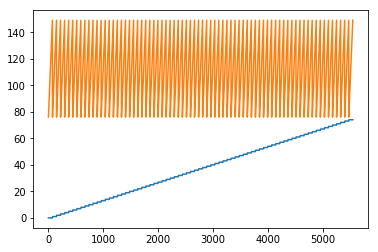

In [2759]:
plt.plot(baker_hubbard[0][1])

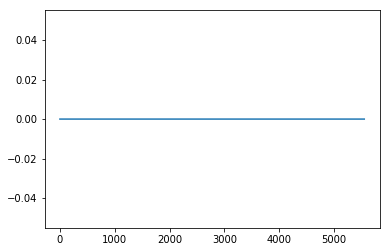

In [2760]:
plt.plot(hbmat[tuple(baker_hubbard[0][1].T)]) #plt.plot(np.exp(-baker_hubbard[0][0].var(axis=0)))

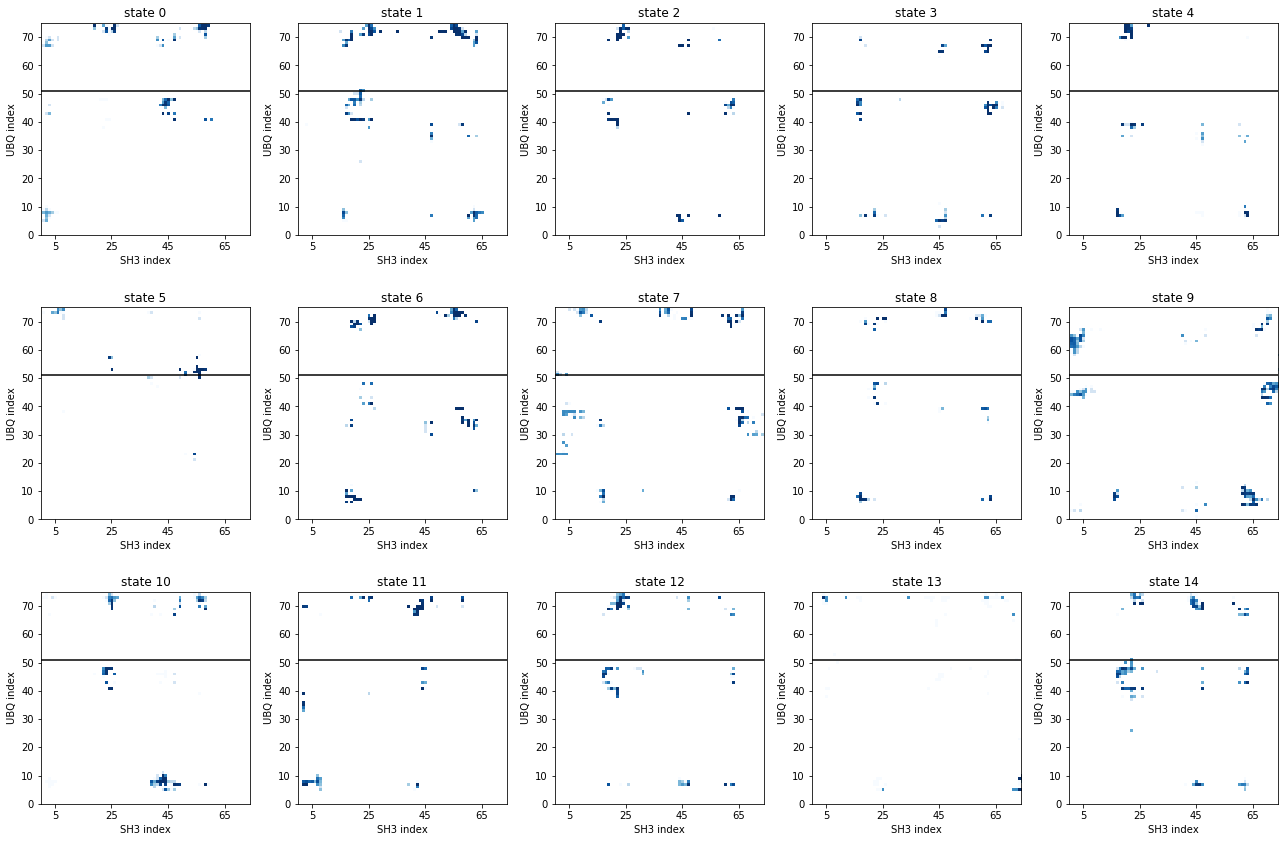

In [2804]:
hbmat = np.zeros((150,150))
fig, ax = plt.subplots(ncols=5,nrows=3, figsize=(18,12))#, sharex=True,sharey=True)
asf = ax.ravel()
for i,_hb in enumerate(baker_hubbard):
    hbmat[tuple(_hb[1].T)] = (_hb[0]<0.5).mean(axis=0)#**2.

    asf[i].imshow(hbmat, cmap='Blues',norm=mpl.colors.LogNorm())
    asf[i].set_ylim(0,75)
    asf[i].set_xlim(75,149)
    asf[i].set_xlabel("SH3 index")
    asf[i].set_ylabel("UBQ index")
    asf[i].set_xticklabels(['',"5", "25", "45", "65"])
    asf[i].set_title(f"state {i}")
    asf[i].hlines(51,0,150)
#     ax.ravel()[i].colorbar()
fig.tight_layout()
fig.savefig("contactmaps.pdf")

In [2684]:
TTTT=hbs[0].topology.atom(aid2)

In [2712]:
state_avg_rmsds[reindex_obs_set][new_membership2[:,-2]==1]

array([2.0885456, 2.1182709, 2.268184 , 2.41756  , 2.619108 , 2.2581964,
       1.938333 , 2.0735185, 2.25211  , 2.0776095, 2.3154604, 2.1425047,
       1.9420971, 1.9431354, 1.8736302], dtype=float32)

In [4]:
cc

NameError: name 'cc' is not defined